In [1]:
from google.colab import drive
drive.mount('/content/drive')
main_dir = 'drive/MyDrive/GSN/churn_text_prediction'

Mounted at /content/drive


In [2]:
import os
os.chdir(main_dir)

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.3 MB/s eta 0:00:00


In [4]:
import yaml
import pandas as pd
from pathlib import Path
import numpy as np

In [5]:
os.chdir('scripts')

In [6]:
with open("../model_cased/google/params.yaml", "r") as params_file:
    params_google = yaml.safe_load(params_file)
with open("../model_cased/deepl/params.yaml", "r") as params_file:
    params_deepl = yaml.safe_load(params_file)
with open("../model_cased/azure/params.yaml", "r") as params_file:
    params_azure = yaml.safe_load(params_file)

Wczytanie danych przetłumaczonych

In [7]:
df_text_google = pd.read_csv(Path(params_google['data_dir'], 'df_text_google.csv'))
df_text_deepl = pd.read_csv(Path(params_deepl['data_dir'], 'df_text_deepl.csv'))
df_text_azure = pd.read_csv(Path(params_azure['data_dir'], 'df_text_azure.csv'), index_col =0)

In [8]:
df_text_azure.head(3)

,churn,chat_log
0,no,Klient: Tekst.\r\nTelCom Agent: Jakie jest min...
1,no,Klient: Tylko głos.\r\nTelCom Agent: A ile by ...
2,no,Nan


Stwórz datasety

In [9]:
def create_joint_dataset(
    df_categorical, 
    df_text
):
    df_text_no = df_text[df_text.churn == 'no'].reset_index(drop=True)
    df_text_yes = df_text[df_text.churn == 'yes'].reset_index(drop=True)

    df_cat_no = df_categorical[df_categorical.churn == 'no'].reset_index(drop=True)[:len(df_text_no)]
    df_cat_yes = df_categorical[df_categorical.churn == 'yes'].reset_index(drop=True)[:len(df_text_yes)]

    df_no = pd.concat([df_text_no, df_cat_no.iloc[:,:-1]], axis=1)
    df_yes = pd.concat([df_text_yes, df_cat_yes.iloc[:,:-1]], axis=1)

    df = pd.concat([df_no, df_yes], axis=0)

    # shuffle data
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [10]:
# load data
df_categorical = pd.read_csv(Path('../data', "train.csv"))

In [11]:
# create joint dataset
df_google = create_joint_dataset(df_categorical, df_text_google)
df_deepl = create_joint_dataset(df_categorical, df_text_deepl)
df_azure = create_joint_dataset(df_categorical, df_text_azure)

In [12]:
from sklearn.model_selection import train_test_split
import json

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [14]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm.notebook import tqdm

In [15]:
import train

In [26]:
def plot_train_stats(
        params
):
    model_dir = params['model_dir']
    scores_df = pd.read_csv(Path(model_dir, 'training_scores.csv'))
    scores_df.plot(xlabel='Epochs', ylabel='AUC Score', title='AUC Score', ylim = (.8, None))
    return None

In [17]:
from utils import *


# Googlowe tłumaczenie

In [76]:
df_google = pd.read_csv(Path(params_google['data_dir'], "churn_dataset_google.csv"))
X_train, X_test, y_train, y_test = main_transformation(df_google, params_google['model_dir'], 'dkleczek/bert-base-polish-cased-v1', use_existing=True, test_size=0.33)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Using already prepared data.


((2233, 841), (1100, 841), (2233, 1), (1100, 1))

In [28]:
params_google['weight_decay'] = 0.01
params_google['epochs'] = 500
params_google['pos_weight'] = 5.9

In [29]:
train.train(
    X=X_train,
    y=y_train,
    X_test=X_test,
    y_test=y_test,
    params = params_google
)

starting epoch:  1
Train Epoch: 1, train-auc-score: 0.9245


INFO:train:Train Epoch: 1, train-auc-score: 0.9245


test_auc_score: 0.9407


INFO:train:test_auc_score: 0.9407


starting epoch:  2
Train Epoch: 2, train-auc-score: 0.9311


INFO:train:Train Epoch: 2, train-auc-score: 0.9311


test_auc_score: 0.9452


INFO:train:test_auc_score: 0.9452


starting epoch:  3
Train Epoch: 3, train-auc-score: 0.9467


INFO:train:Train Epoch: 3, train-auc-score: 0.9467


test_auc_score: 0.9543


INFO:train:test_auc_score: 0.9543


starting epoch:  4
Train Epoch: 4, train-auc-score: 0.9513


INFO:train:Train Epoch: 4, train-auc-score: 0.9513


test_auc_score: 0.9609


INFO:train:test_auc_score: 0.9609


starting epoch:  5
Train Epoch: 5, train-auc-score: 0.9506


INFO:train:Train Epoch: 5, train-auc-score: 0.9506


test_auc_score: 0.9522


INFO:train:test_auc_score: 0.9522


starting epoch:  6
Train Epoch: 6, train-auc-score: 0.9671


INFO:train:Train Epoch: 6, train-auc-score: 0.9671


test_auc_score: 0.9663


INFO:train:test_auc_score: 0.9663


starting epoch:  7
Train Epoch: 7, train-auc-score: 0.9563


INFO:train:Train Epoch: 7, train-auc-score: 0.9563


test_auc_score: 0.9572


INFO:train:test_auc_score: 0.9572


starting epoch:  8
Train Epoch: 8, train-auc-score: 0.9698


INFO:train:Train Epoch: 8, train-auc-score: 0.9698


test_auc_score: 0.9698


INFO:train:test_auc_score: 0.9698


starting epoch:  9
Train Epoch: 9, train-auc-score: 0.9735


INFO:train:Train Epoch: 9, train-auc-score: 0.9735


test_auc_score: 0.9720


INFO:train:test_auc_score: 0.9720


starting epoch:  10
Train Epoch: 10, train-auc-score: 0.9520


INFO:train:Train Epoch: 10, train-auc-score: 0.9520


test_auc_score: 0.9478


INFO:train:test_auc_score: 0.9478


starting epoch:  11
Train Epoch: 11, train-auc-score: 0.9598


INFO:train:Train Epoch: 11, train-auc-score: 0.9598


test_auc_score: 0.9609


INFO:train:test_auc_score: 0.9609


starting epoch:  12
Train Epoch: 12, train-auc-score: 0.9739


INFO:train:Train Epoch: 12, train-auc-score: 0.9739


test_auc_score: 0.9708


INFO:train:test_auc_score: 0.9708


starting epoch:  13
Train Epoch: 13, train-auc-score: 0.9731


INFO:train:Train Epoch: 13, train-auc-score: 0.9731


test_auc_score: 0.9721


INFO:train:test_auc_score: 0.9721


starting epoch:  14
Train Epoch: 14, train-auc-score: 0.9692


INFO:train:Train Epoch: 14, train-auc-score: 0.9692


test_auc_score: 0.9680


INFO:train:test_auc_score: 0.9680


starting epoch:  15
Train Epoch: 15, train-auc-score: 0.9726


INFO:train:Train Epoch: 15, train-auc-score: 0.9726


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  16
Train Epoch: 16, train-auc-score: 0.9825


INFO:train:Train Epoch: 16, train-auc-score: 0.9825


test_auc_score: 0.9746


INFO:train:test_auc_score: 0.9746


starting epoch:  17
Train Epoch: 17, train-auc-score: 0.9743


INFO:train:Train Epoch: 17, train-auc-score: 0.9743


test_auc_score: 0.9705


INFO:train:test_auc_score: 0.9705


starting epoch:  18
Train Epoch: 18, train-auc-score: 0.9811


INFO:train:Train Epoch: 18, train-auc-score: 0.9811


test_auc_score: 0.9723


INFO:train:test_auc_score: 0.9723


starting epoch:  19
Train Epoch: 19, train-auc-score: 0.9699


INFO:train:Train Epoch: 19, train-auc-score: 0.9699


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  20
Train Epoch: 20, train-auc-score: 0.9840


INFO:train:Train Epoch: 20, train-auc-score: 0.9840


test_auc_score: 0.9735


INFO:train:test_auc_score: 0.9735


starting epoch:  21
Train Epoch: 21, train-auc-score: 0.9850


INFO:train:Train Epoch: 21, train-auc-score: 0.9850


test_auc_score: 0.9748


INFO:train:test_auc_score: 0.9748


starting epoch:  22
Train Epoch: 22, train-auc-score: 0.9823


INFO:train:Train Epoch: 22, train-auc-score: 0.9823


test_auc_score: 0.9774


INFO:train:test_auc_score: 0.9774


starting epoch:  23
Train Epoch: 23, train-auc-score: 0.9857


INFO:train:Train Epoch: 23, train-auc-score: 0.9857


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  24
Train Epoch: 24, train-auc-score: 0.9732


INFO:train:Train Epoch: 24, train-auc-score: 0.9732


test_auc_score: 0.9622


INFO:train:test_auc_score: 0.9622


starting epoch:  25
Train Epoch: 25, train-auc-score: 0.9811


INFO:train:Train Epoch: 25, train-auc-score: 0.9811


test_auc_score: 0.9752


INFO:train:test_auc_score: 0.9752


starting epoch:  26
Train Epoch: 26, train-auc-score: 0.9874


INFO:train:Train Epoch: 26, train-auc-score: 0.9874


test_auc_score: 0.9786


INFO:train:test_auc_score: 0.9786


starting epoch:  27
Train Epoch: 27, train-auc-score: 0.9788


INFO:train:Train Epoch: 27, train-auc-score: 0.9788


test_auc_score: 0.9735


INFO:train:test_auc_score: 0.9735


starting epoch:  28
Train Epoch: 28, train-auc-score: 0.9792


INFO:train:Train Epoch: 28, train-auc-score: 0.9792


test_auc_score: 0.9718


INFO:train:test_auc_score: 0.9718


starting epoch:  29
Train Epoch: 29, train-auc-score: 0.9797


INFO:train:Train Epoch: 29, train-auc-score: 0.9797


test_auc_score: 0.9692


INFO:train:test_auc_score: 0.9692


starting epoch:  30
Train Epoch: 30, train-auc-score: 0.9829


INFO:train:Train Epoch: 30, train-auc-score: 0.9829


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  31
Train Epoch: 31, train-auc-score: 0.9846


INFO:train:Train Epoch: 31, train-auc-score: 0.9846


test_auc_score: 0.9777


INFO:train:test_auc_score: 0.9777


starting epoch:  32
Train Epoch: 32, train-auc-score: 0.9862


INFO:train:Train Epoch: 32, train-auc-score: 0.9862


test_auc_score: 0.9795


INFO:train:test_auc_score: 0.9795


starting epoch:  33
Train Epoch: 33, train-auc-score: 0.9814


INFO:train:Train Epoch: 33, train-auc-score: 0.9814


test_auc_score: 0.9763


INFO:train:test_auc_score: 0.9763


starting epoch:  34
Train Epoch: 34, train-auc-score: 0.9489


INFO:train:Train Epoch: 34, train-auc-score: 0.9489


test_auc_score: 0.9416


INFO:train:test_auc_score: 0.9416


starting epoch:  35
Train Epoch: 35, train-auc-score: 0.9860


INFO:train:Train Epoch: 35, train-auc-score: 0.9860


test_auc_score: 0.9777


INFO:train:test_auc_score: 0.9777


starting epoch:  36
Train Epoch: 36, train-auc-score: 0.9868


INFO:train:Train Epoch: 36, train-auc-score: 0.9868


test_auc_score: 0.9764


INFO:train:test_auc_score: 0.9764


starting epoch:  37
Train Epoch: 37, train-auc-score: 0.9873


INFO:train:Train Epoch: 37, train-auc-score: 0.9873


test_auc_score: 0.9782


INFO:train:test_auc_score: 0.9782


starting epoch:  38
Train Epoch: 38, train-auc-score: 0.9864


INFO:train:Train Epoch: 38, train-auc-score: 0.9864


test_auc_score: 0.9772


INFO:train:test_auc_score: 0.9772


starting epoch:  39
Train Epoch: 39, train-auc-score: 0.9858


INFO:train:Train Epoch: 39, train-auc-score: 0.9858


test_auc_score: 0.9774


INFO:train:test_auc_score: 0.9774


starting epoch:  40
Train Epoch: 40, train-auc-score: 0.9865


INFO:train:Train Epoch: 40, train-auc-score: 0.9865


test_auc_score: 0.9781


INFO:train:test_auc_score: 0.9781


starting epoch:  41
Train Epoch: 41, train-auc-score: 0.9858


INFO:train:Train Epoch: 41, train-auc-score: 0.9858


test_auc_score: 0.9784


INFO:train:test_auc_score: 0.9784


starting epoch:  42
Train Epoch: 42, train-auc-score: 0.9886


INFO:train:Train Epoch: 42, train-auc-score: 0.9886


test_auc_score: 0.9793


INFO:train:test_auc_score: 0.9793


starting epoch:  43
Train Epoch: 43, train-auc-score: 0.9890


INFO:train:Train Epoch: 43, train-auc-score: 0.9890


test_auc_score: 0.9800


INFO:train:test_auc_score: 0.9800


starting epoch:  44
Train Epoch: 44, train-auc-score: 0.9658


INFO:train:Train Epoch: 44, train-auc-score: 0.9658


test_auc_score: 0.9464


INFO:train:test_auc_score: 0.9464


starting epoch:  45
Train Epoch: 45, train-auc-score: 0.9882


INFO:train:Train Epoch: 45, train-auc-score: 0.9882


test_auc_score: 0.9791


INFO:train:test_auc_score: 0.9791


starting epoch:  46
Train Epoch: 46, train-auc-score: 0.9820


INFO:train:Train Epoch: 46, train-auc-score: 0.9820


test_auc_score: 0.9744


INFO:train:test_auc_score: 0.9744


starting epoch:  47
Train Epoch: 47, train-auc-score: 0.9867


INFO:train:Train Epoch: 47, train-auc-score: 0.9867


test_auc_score: 0.9809


INFO:train:test_auc_score: 0.9809


starting epoch:  48
Train Epoch: 48, train-auc-score: 0.9836


INFO:train:Train Epoch: 48, train-auc-score: 0.9836


test_auc_score: 0.9764


INFO:train:test_auc_score: 0.9764


starting epoch:  49
Train Epoch: 49, train-auc-score: 0.9729


INFO:train:Train Epoch: 49, train-auc-score: 0.9729


test_auc_score: 0.9664


INFO:train:test_auc_score: 0.9664


starting epoch:  50
Train Epoch: 50, train-auc-score: 0.9877


INFO:train:Train Epoch: 50, train-auc-score: 0.9877


test_auc_score: 0.9751


INFO:train:test_auc_score: 0.9751


starting epoch:  51
Train Epoch: 51, train-auc-score: 0.9894


INFO:train:Train Epoch: 51, train-auc-score: 0.9894


test_auc_score: 0.9801


INFO:train:test_auc_score: 0.9801


starting epoch:  52
Train Epoch: 52, train-auc-score: 0.9814


INFO:train:Train Epoch: 52, train-auc-score: 0.9814


test_auc_score: 0.9720


INFO:train:test_auc_score: 0.9720


starting epoch:  53
Train Epoch: 53, train-auc-score: 0.9836


INFO:train:Train Epoch: 53, train-auc-score: 0.9836


test_auc_score: 0.9711


INFO:train:test_auc_score: 0.9711


starting epoch:  54
Train Epoch: 54, train-auc-score: 0.9860


INFO:train:Train Epoch: 54, train-auc-score: 0.9860


test_auc_score: 0.9748


INFO:train:test_auc_score: 0.9748


starting epoch:  55
Train Epoch: 55, train-auc-score: 0.9892


INFO:train:Train Epoch: 55, train-auc-score: 0.9892


test_auc_score: 0.9810


INFO:train:test_auc_score: 0.9810


starting epoch:  56
Train Epoch: 56, train-auc-score: 0.9894


INFO:train:Train Epoch: 56, train-auc-score: 0.9894


test_auc_score: 0.9795


INFO:train:test_auc_score: 0.9795


starting epoch:  57
Train Epoch: 57, train-auc-score: 0.9808


INFO:train:Train Epoch: 57, train-auc-score: 0.9808


test_auc_score: 0.9712


INFO:train:test_auc_score: 0.9712


starting epoch:  58
Train Epoch: 58, train-auc-score: 0.9898


INFO:train:Train Epoch: 58, train-auc-score: 0.9898


test_auc_score: 0.9797


INFO:train:test_auc_score: 0.9797


starting epoch:  59
Train Epoch: 59, train-auc-score: 0.9861


INFO:train:Train Epoch: 59, train-auc-score: 0.9861


test_auc_score: 0.9754


INFO:train:test_auc_score: 0.9754


starting epoch:  60
Train Epoch: 60, train-auc-score: 0.9884


INFO:train:Train Epoch: 60, train-auc-score: 0.9884


test_auc_score: 0.9785


INFO:train:test_auc_score: 0.9785


starting epoch:  61
Train Epoch: 61, train-auc-score: 0.9821


INFO:train:Train Epoch: 61, train-auc-score: 0.9821


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  62
Train Epoch: 62, train-auc-score: 0.9865


INFO:train:Train Epoch: 62, train-auc-score: 0.9865


test_auc_score: 0.9797


INFO:train:test_auc_score: 0.9797


starting epoch:  63
Train Epoch: 63, train-auc-score: 0.9900


INFO:train:Train Epoch: 63, train-auc-score: 0.9900


test_auc_score: 0.9789


INFO:train:test_auc_score: 0.9789


starting epoch:  64
Train Epoch: 64, train-auc-score: 0.9879


INFO:train:Train Epoch: 64, train-auc-score: 0.9879


test_auc_score: 0.9770


INFO:train:test_auc_score: 0.9770


starting epoch:  65
Train Epoch: 65, train-auc-score: 0.9809


INFO:train:Train Epoch: 65, train-auc-score: 0.9809


test_auc_score: 0.9711


INFO:train:test_auc_score: 0.9711


starting epoch:  66
Train Epoch: 66, train-auc-score: 0.9698


INFO:train:Train Epoch: 66, train-auc-score: 0.9698


test_auc_score: 0.9637


INFO:train:test_auc_score: 0.9637


starting epoch:  67
Train Epoch: 67, train-auc-score: 0.9880


INFO:train:Train Epoch: 67, train-auc-score: 0.9880


test_auc_score: 0.9815


INFO:train:test_auc_score: 0.9815


starting epoch:  68
Train Epoch: 68, train-auc-score: 0.9663


INFO:train:Train Epoch: 68, train-auc-score: 0.9663


test_auc_score: 0.9592


INFO:train:test_auc_score: 0.9592


starting epoch:  69
Train Epoch: 69, train-auc-score: 0.9874


INFO:train:Train Epoch: 69, train-auc-score: 0.9874


test_auc_score: 0.9793


INFO:train:test_auc_score: 0.9793


starting epoch:  70
Train Epoch: 70, train-auc-score: 0.9902


INFO:train:Train Epoch: 70, train-auc-score: 0.9902


test_auc_score: 0.9808


INFO:train:test_auc_score: 0.9808


starting epoch:  71
Train Epoch: 71, train-auc-score: 0.9875


INFO:train:Train Epoch: 71, train-auc-score: 0.9875


test_auc_score: 0.9788


INFO:train:test_auc_score: 0.9788


starting epoch:  72
Train Epoch: 72, train-auc-score: 0.9879


INFO:train:Train Epoch: 72, train-auc-score: 0.9879


test_auc_score: 0.9795


INFO:train:test_auc_score: 0.9795


starting epoch:  73
Train Epoch: 73, train-auc-score: 0.9886


INFO:train:Train Epoch: 73, train-auc-score: 0.9886


test_auc_score: 0.9807


INFO:train:test_auc_score: 0.9807


starting epoch:  74
Train Epoch: 74, train-auc-score: 0.9882


INFO:train:Train Epoch: 74, train-auc-score: 0.9882


test_auc_score: 0.9818


INFO:train:test_auc_score: 0.9818


starting epoch:  75
Train Epoch: 75, train-auc-score: 0.9879


INFO:train:Train Epoch: 75, train-auc-score: 0.9879


test_auc_score: 0.9741


INFO:train:test_auc_score: 0.9741


starting epoch:  76
Train Epoch: 76, train-auc-score: 0.9887


INFO:train:Train Epoch: 76, train-auc-score: 0.9887


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  77
Train Epoch: 77, train-auc-score: 0.9898


INFO:train:Train Epoch: 77, train-auc-score: 0.9898


test_auc_score: 0.9804


INFO:train:test_auc_score: 0.9804


starting epoch:  78
Train Epoch: 78, train-auc-score: 0.9798


INFO:train:Train Epoch: 78, train-auc-score: 0.9798


test_auc_score: 0.9631


INFO:train:test_auc_score: 0.9631


starting epoch:  79
Train Epoch: 79, train-auc-score: 0.9874


INFO:train:Train Epoch: 79, train-auc-score: 0.9874


test_auc_score: 0.9796


INFO:train:test_auc_score: 0.9796


starting epoch:  80
Train Epoch: 80, train-auc-score: 0.9863


INFO:train:Train Epoch: 80, train-auc-score: 0.9863


test_auc_score: 0.9732


INFO:train:test_auc_score: 0.9732


starting epoch:  81
Train Epoch: 81, train-auc-score: 0.9862


INFO:train:Train Epoch: 81, train-auc-score: 0.9862


test_auc_score: 0.9798


INFO:train:test_auc_score: 0.9798


starting epoch:  82
Train Epoch: 82, train-auc-score: 0.9890


INFO:train:Train Epoch: 82, train-auc-score: 0.9890


test_auc_score: 0.9777


INFO:train:test_auc_score: 0.9777


starting epoch:  83
Train Epoch: 83, train-auc-score: 0.9868


INFO:train:Train Epoch: 83, train-auc-score: 0.9868


test_auc_score: 0.9741


INFO:train:test_auc_score: 0.9741


starting epoch:  84
Train Epoch: 84, train-auc-score: 0.9676


INFO:train:Train Epoch: 84, train-auc-score: 0.9676


test_auc_score: 0.9510


INFO:train:test_auc_score: 0.9510


starting epoch:  85
Train Epoch: 85, train-auc-score: 0.9869


INFO:train:Train Epoch: 85, train-auc-score: 0.9869


test_auc_score: 0.9805


INFO:train:test_auc_score: 0.9805


starting epoch:  86
Train Epoch: 86, train-auc-score: 0.9870


INFO:train:Train Epoch: 86, train-auc-score: 0.9870


test_auc_score: 0.9792


INFO:train:test_auc_score: 0.9792


starting epoch:  87
Train Epoch: 87, train-auc-score: 0.9892


INFO:train:Train Epoch: 87, train-auc-score: 0.9892


test_auc_score: 0.9803


INFO:train:test_auc_score: 0.9803


starting epoch:  88
Train Epoch: 88, train-auc-score: 0.9857


INFO:train:Train Epoch: 88, train-auc-score: 0.9857


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  89
Train Epoch: 89, train-auc-score: 0.9829


INFO:train:Train Epoch: 89, train-auc-score: 0.9829


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  90
Train Epoch: 90, train-auc-score: 0.9866


INFO:train:Train Epoch: 90, train-auc-score: 0.9866


test_auc_score: 0.9801


INFO:train:test_auc_score: 0.9801


starting epoch:  91
Train Epoch: 91, train-auc-score: 0.9871


INFO:train:Train Epoch: 91, train-auc-score: 0.9871


test_auc_score: 0.9781


INFO:train:test_auc_score: 0.9781


starting epoch:  92
Train Epoch: 92, train-auc-score: 0.9762


INFO:train:Train Epoch: 92, train-auc-score: 0.9762


test_auc_score: 0.9657


INFO:train:test_auc_score: 0.9657


starting epoch:  93
Train Epoch: 93, train-auc-score: 0.9843


INFO:train:Train Epoch: 93, train-auc-score: 0.9843


test_auc_score: 0.9751


INFO:train:test_auc_score: 0.9751


starting epoch:  94
Train Epoch: 94, train-auc-score: 0.9881


INFO:train:Train Epoch: 94, train-auc-score: 0.9881


test_auc_score: 0.9807


INFO:train:test_auc_score: 0.9807


starting epoch:  95
Train Epoch: 95, train-auc-score: 0.9774


INFO:train:Train Epoch: 95, train-auc-score: 0.9774


test_auc_score: 0.9730


INFO:train:test_auc_score: 0.9730


starting epoch:  96
Train Epoch: 96, train-auc-score: 0.9873


INFO:train:Train Epoch: 96, train-auc-score: 0.9873


test_auc_score: 0.9763


INFO:train:test_auc_score: 0.9763


starting epoch:  97
Train Epoch: 97, train-auc-score: 0.9906


INFO:train:Train Epoch: 97, train-auc-score: 0.9906


test_auc_score: 0.9816


INFO:train:test_auc_score: 0.9816


starting epoch:  98
Train Epoch: 98, train-auc-score: 0.9900


INFO:train:Train Epoch: 98, train-auc-score: 0.9900


test_auc_score: 0.9810


INFO:train:test_auc_score: 0.9810


starting epoch:  99
Train Epoch: 99, train-auc-score: 0.9904


INFO:train:Train Epoch: 99, train-auc-score: 0.9904


test_auc_score: 0.9793


INFO:train:test_auc_score: 0.9793


starting epoch:  100
Train Epoch: 100, train-auc-score: 0.9869


INFO:train:Train Epoch: 100, train-auc-score: 0.9869


test_auc_score: 0.9768


INFO:train:test_auc_score: 0.9768


starting epoch:  101
Train Epoch: 101, train-auc-score: 0.9834


INFO:train:Train Epoch: 101, train-auc-score: 0.9834


test_auc_score: 0.9766


INFO:train:test_auc_score: 0.9766


starting epoch:  102
Train Epoch: 102, train-auc-score: 0.9876


INFO:train:Train Epoch: 102, train-auc-score: 0.9876


test_auc_score: 0.9804


INFO:train:test_auc_score: 0.9804


starting epoch:  103
Train Epoch: 103, train-auc-score: 0.9894


INFO:train:Train Epoch: 103, train-auc-score: 0.9894


test_auc_score: 0.9803


INFO:train:test_auc_score: 0.9803


starting epoch:  104
Train Epoch: 104, train-auc-score: 0.9897


INFO:train:Train Epoch: 104, train-auc-score: 0.9897


test_auc_score: 0.9773


INFO:train:test_auc_score: 0.9773


starting epoch:  105
Train Epoch: 105, train-auc-score: 0.9874


INFO:train:Train Epoch: 105, train-auc-score: 0.9874


test_auc_score: 0.9804


INFO:train:test_auc_score: 0.9804


starting epoch:  106
Train Epoch: 106, train-auc-score: 0.9879


INFO:train:Train Epoch: 106, train-auc-score: 0.9879


test_auc_score: 0.9799


INFO:train:test_auc_score: 0.9799


starting epoch:  107
Train Epoch: 107, train-auc-score: 0.9858


INFO:train:Train Epoch: 107, train-auc-score: 0.9858


test_auc_score: 0.9779


INFO:train:test_auc_score: 0.9779


starting epoch:  108
Train Epoch: 108, train-auc-score: 0.9873


INFO:train:Train Epoch: 108, train-auc-score: 0.9873


test_auc_score: 0.9737


INFO:train:test_auc_score: 0.9737


starting epoch:  109
Train Epoch: 109, train-auc-score: 0.9876


INFO:train:Train Epoch: 109, train-auc-score: 0.9876


test_auc_score: 0.9810


INFO:train:test_auc_score: 0.9810


starting epoch:  110
Train Epoch: 110, train-auc-score: 0.9883


INFO:train:Train Epoch: 110, train-auc-score: 0.9883


test_auc_score: 0.9805


INFO:train:test_auc_score: 0.9805


starting epoch:  111
Train Epoch: 111, train-auc-score: 0.9894


INFO:train:Train Epoch: 111, train-auc-score: 0.9894


test_auc_score: 0.9784


INFO:train:test_auc_score: 0.9784


starting epoch:  112
Train Epoch: 112, train-auc-score: 0.9897


INFO:train:Train Epoch: 112, train-auc-score: 0.9897


test_auc_score: 0.9806


INFO:train:test_auc_score: 0.9806


starting epoch:  113
Train Epoch: 113, train-auc-score: 0.9871


INFO:train:Train Epoch: 113, train-auc-score: 0.9871


test_auc_score: 0.9800


INFO:train:test_auc_score: 0.9800


starting epoch:  114
Train Epoch: 114, train-auc-score: 0.9914


INFO:train:Train Epoch: 114, train-auc-score: 0.9914


test_auc_score: 0.9788


INFO:train:test_auc_score: 0.9788


starting epoch:  115
Train Epoch: 115, train-auc-score: 0.9882


INFO:train:Train Epoch: 115, train-auc-score: 0.9882


test_auc_score: 0.9800


INFO:train:test_auc_score: 0.9800


starting epoch:  116
Train Epoch: 116, train-auc-score: 0.9863


INFO:train:Train Epoch: 116, train-auc-score: 0.9863


test_auc_score: 0.9800


INFO:train:test_auc_score: 0.9800


starting epoch:  117
Train Epoch: 117, train-auc-score: 0.9887


INFO:train:Train Epoch: 117, train-auc-score: 0.9887


test_auc_score: 0.9801


INFO:train:test_auc_score: 0.9801


starting epoch:  118
Train Epoch: 118, train-auc-score: 0.9800


INFO:train:Train Epoch: 118, train-auc-score: 0.9800


test_auc_score: 0.9688


INFO:train:test_auc_score: 0.9688


starting epoch:  119
Train Epoch: 119, train-auc-score: 0.9852


INFO:train:Train Epoch: 119, train-auc-score: 0.9852


test_auc_score: 0.9797


INFO:train:test_auc_score: 0.9797


starting epoch:  120
Train Epoch: 120, train-auc-score: 0.9893


INFO:train:Train Epoch: 120, train-auc-score: 0.9893


test_auc_score: 0.9762


INFO:train:test_auc_score: 0.9762


starting epoch:  121
Train Epoch: 121, train-auc-score: 0.9709


INFO:train:Train Epoch: 121, train-auc-score: 0.9709


test_auc_score: 0.9633


INFO:train:test_auc_score: 0.9633


starting epoch:  122
Train Epoch: 122, train-auc-score: 0.9890


INFO:train:Train Epoch: 122, train-auc-score: 0.9890


test_auc_score: 0.9789


INFO:train:test_auc_score: 0.9789


starting epoch:  123
Train Epoch: 123, train-auc-score: 0.9854


INFO:train:Train Epoch: 123, train-auc-score: 0.9854


test_auc_score: 0.9731


INFO:train:test_auc_score: 0.9731


starting epoch:  124
Train Epoch: 124, train-auc-score: 0.9859


INFO:train:Train Epoch: 124, train-auc-score: 0.9859


test_auc_score: 0.9774


INFO:train:test_auc_score: 0.9774


starting epoch:  125
Train Epoch: 125, train-auc-score: 0.9875


INFO:train:Train Epoch: 125, train-auc-score: 0.9875


test_auc_score: 0.9787


INFO:train:test_auc_score: 0.9787


starting epoch:  126
Train Epoch: 126, train-auc-score: 0.9883


INFO:train:Train Epoch: 126, train-auc-score: 0.9883


test_auc_score: 0.9803


INFO:train:test_auc_score: 0.9803


starting epoch:  127
Train Epoch: 127, train-auc-score: 0.9887


INFO:train:Train Epoch: 127, train-auc-score: 0.9887


test_auc_score: 0.9805


INFO:train:test_auc_score: 0.9805


starting epoch:  128
Train Epoch: 128, train-auc-score: 0.9896


INFO:train:Train Epoch: 128, train-auc-score: 0.9896


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  129
Train Epoch: 129, train-auc-score: 0.9805


INFO:train:Train Epoch: 129, train-auc-score: 0.9805


test_auc_score: 0.9723


INFO:train:test_auc_score: 0.9723


starting epoch:  130
Train Epoch: 130, train-auc-score: 0.9893


INFO:train:Train Epoch: 130, train-auc-score: 0.9893


test_auc_score: 0.9786


INFO:train:test_auc_score: 0.9786


starting epoch:  131
Train Epoch: 131, train-auc-score: 0.9849


INFO:train:Train Epoch: 131, train-auc-score: 0.9849


test_auc_score: 0.9801


INFO:train:test_auc_score: 0.9801


starting epoch:  132
Train Epoch: 132, train-auc-score: 0.9760


INFO:train:Train Epoch: 132, train-auc-score: 0.9760


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  133
Train Epoch: 133, train-auc-score: 0.9874


INFO:train:Train Epoch: 133, train-auc-score: 0.9874


test_auc_score: 0.9731


INFO:train:test_auc_score: 0.9731


starting epoch:  134
Train Epoch: 134, train-auc-score: 0.9798


INFO:train:Train Epoch: 134, train-auc-score: 0.9798


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  135
Train Epoch: 135, train-auc-score: 0.9887


INFO:train:Train Epoch: 135, train-auc-score: 0.9887


test_auc_score: 0.9805


INFO:train:test_auc_score: 0.9805


starting epoch:  136
Train Epoch: 136, train-auc-score: 0.9890


INFO:train:Train Epoch: 136, train-auc-score: 0.9890


test_auc_score: 0.9795


INFO:train:test_auc_score: 0.9795


starting epoch:  137
Train Epoch: 137, train-auc-score: 0.9619


INFO:train:Train Epoch: 137, train-auc-score: 0.9619


test_auc_score: 0.9558


INFO:train:test_auc_score: 0.9558


starting epoch:  138
Train Epoch: 138, train-auc-score: 0.9883


INFO:train:Train Epoch: 138, train-auc-score: 0.9883


test_auc_score: 0.9801


INFO:train:test_auc_score: 0.9801


starting epoch:  139
Train Epoch: 139, train-auc-score: 0.9860


INFO:train:Train Epoch: 139, train-auc-score: 0.9860


test_auc_score: 0.9765


INFO:train:test_auc_score: 0.9765


starting epoch:  140
Train Epoch: 140, train-auc-score: 0.9885


INFO:train:Train Epoch: 140, train-auc-score: 0.9885


test_auc_score: 0.9796


INFO:train:test_auc_score: 0.9796


starting epoch:  141
Train Epoch: 141, train-auc-score: 0.9858


INFO:train:Train Epoch: 141, train-auc-score: 0.9858


test_auc_score: 0.9793


INFO:train:test_auc_score: 0.9793


starting epoch:  142
Train Epoch: 142, train-auc-score: 0.9883


INFO:train:Train Epoch: 142, train-auc-score: 0.9883


test_auc_score: 0.9790


INFO:train:test_auc_score: 0.9790


starting epoch:  143
Train Epoch: 143, train-auc-score: 0.9888


INFO:train:Train Epoch: 143, train-auc-score: 0.9888


test_auc_score: 0.9796


INFO:train:test_auc_score: 0.9796


starting epoch:  144
Train Epoch: 144, train-auc-score: 0.9867


INFO:train:Train Epoch: 144, train-auc-score: 0.9867


test_auc_score: 0.9765


INFO:train:test_auc_score: 0.9765


starting epoch:  145
Train Epoch: 145, train-auc-score: 0.9859


INFO:train:Train Epoch: 145, train-auc-score: 0.9859


test_auc_score: 0.9777


INFO:train:test_auc_score: 0.9777


starting epoch:  146
Train Epoch: 146, train-auc-score: 0.9864


INFO:train:Train Epoch: 146, train-auc-score: 0.9864


test_auc_score: 0.9763


INFO:train:test_auc_score: 0.9763


starting epoch:  147
Train Epoch: 147, train-auc-score: 0.9841


INFO:train:Train Epoch: 147, train-auc-score: 0.9841


test_auc_score: 0.9771


INFO:train:test_auc_score: 0.9771


starting epoch:  148
Train Epoch: 148, train-auc-score: 0.9882


INFO:train:Train Epoch: 148, train-auc-score: 0.9882


test_auc_score: 0.9809


INFO:train:test_auc_score: 0.9809


starting epoch:  149
Train Epoch: 149, train-auc-score: 0.9820


INFO:train:Train Epoch: 149, train-auc-score: 0.9820


test_auc_score: 0.9721


INFO:train:test_auc_score: 0.9721


starting epoch:  150
Train Epoch: 150, train-auc-score: 0.9895


INFO:train:Train Epoch: 150, train-auc-score: 0.9895


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  151
Train Epoch: 151, train-auc-score: 0.9868


INFO:train:Train Epoch: 151, train-auc-score: 0.9868


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  152
Train Epoch: 152, train-auc-score: 0.9854


INFO:train:Train Epoch: 152, train-auc-score: 0.9854


test_auc_score: 0.9768


INFO:train:test_auc_score: 0.9768


starting epoch:  153
Train Epoch: 153, train-auc-score: 0.9875


INFO:train:Train Epoch: 153, train-auc-score: 0.9875


test_auc_score: 0.9795


INFO:train:test_auc_score: 0.9795


starting epoch:  154
Train Epoch: 154, train-auc-score: 0.9839


INFO:train:Train Epoch: 154, train-auc-score: 0.9839


test_auc_score: 0.9781


INFO:train:test_auc_score: 0.9781


starting epoch:  155
Train Epoch: 155, train-auc-score: 0.9866


INFO:train:Train Epoch: 155, train-auc-score: 0.9866


test_auc_score: 0.9810


INFO:train:test_auc_score: 0.9810


starting epoch:  156
Train Epoch: 156, train-auc-score: 0.9850


INFO:train:Train Epoch: 156, train-auc-score: 0.9850


test_auc_score: 0.9758


INFO:train:test_auc_score: 0.9758


starting epoch:  157
Train Epoch: 157, train-auc-score: 0.9897


INFO:train:Train Epoch: 157, train-auc-score: 0.9897


test_auc_score: 0.9799


INFO:train:test_auc_score: 0.9799


starting epoch:  158
Train Epoch: 158, train-auc-score: 0.9857


INFO:train:Train Epoch: 158, train-auc-score: 0.9857


test_auc_score: 0.9793


INFO:train:test_auc_score: 0.9793


starting epoch:  159
Train Epoch: 159, train-auc-score: 0.9889


INFO:train:Train Epoch: 159, train-auc-score: 0.9889


test_auc_score: 0.9815


INFO:train:test_auc_score: 0.9815


starting epoch:  160
Train Epoch: 160, train-auc-score: 0.9889


INFO:train:Train Epoch: 160, train-auc-score: 0.9889


test_auc_score: 0.9815


INFO:train:test_auc_score: 0.9815


starting epoch:  161
Train Epoch: 161, train-auc-score: 0.9899


INFO:train:Train Epoch: 161, train-auc-score: 0.9899


test_auc_score: 0.9804


INFO:train:test_auc_score: 0.9804


starting epoch:  162
Train Epoch: 162, train-auc-score: 0.9893


INFO:train:Train Epoch: 162, train-auc-score: 0.9893


test_auc_score: 0.9761


INFO:train:test_auc_score: 0.9761


starting epoch:  163
Train Epoch: 163, train-auc-score: 0.9895


INFO:train:Train Epoch: 163, train-auc-score: 0.9895


test_auc_score: 0.9804


INFO:train:test_auc_score: 0.9804


starting epoch:  164
Train Epoch: 164, train-auc-score: 0.9846


INFO:train:Train Epoch: 164, train-auc-score: 0.9846


test_auc_score: 0.9778


INFO:train:test_auc_score: 0.9778


starting epoch:  165
Train Epoch: 165, train-auc-score: 0.9883


INFO:train:Train Epoch: 165, train-auc-score: 0.9883


test_auc_score: 0.9802


INFO:train:test_auc_score: 0.9802


starting epoch:  166
Train Epoch: 166, train-auc-score: 0.9880


INFO:train:Train Epoch: 166, train-auc-score: 0.9880


test_auc_score: 0.9809


INFO:train:test_auc_score: 0.9809


starting epoch:  167
Train Epoch: 167, train-auc-score: 0.9880


INFO:train:Train Epoch: 167, train-auc-score: 0.9880


test_auc_score: 0.9810


INFO:train:test_auc_score: 0.9810


starting epoch:  168
Train Epoch: 168, train-auc-score: 0.9900


INFO:train:Train Epoch: 168, train-auc-score: 0.9900


test_auc_score: 0.9804


INFO:train:test_auc_score: 0.9804


starting epoch:  169
Train Epoch: 169, train-auc-score: 0.9669


INFO:train:Train Epoch: 169, train-auc-score: 0.9669


test_auc_score: 0.9588


INFO:train:test_auc_score: 0.9588


starting epoch:  170
Train Epoch: 170, train-auc-score: 0.9879


INFO:train:Train Epoch: 170, train-auc-score: 0.9879


test_auc_score: 0.9818


INFO:train:test_auc_score: 0.9818


starting epoch:  171
Train Epoch: 171, train-auc-score: 0.9827


INFO:train:Train Epoch: 171, train-auc-score: 0.9827


test_auc_score: 0.9673


INFO:train:test_auc_score: 0.9673


starting epoch:  172
Train Epoch: 172, train-auc-score: 0.9887


INFO:train:Train Epoch: 172, train-auc-score: 0.9887


test_auc_score: 0.9789


INFO:train:test_auc_score: 0.9789


starting epoch:  173
Train Epoch: 173, train-auc-score: 0.9898


INFO:train:Train Epoch: 173, train-auc-score: 0.9898


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  174
Train Epoch: 174, train-auc-score: 0.9844


INFO:train:Train Epoch: 174, train-auc-score: 0.9844


test_auc_score: 0.9757


INFO:train:test_auc_score: 0.9757


starting epoch:  175
Train Epoch: 175, train-auc-score: 0.9883


INFO:train:Train Epoch: 175, train-auc-score: 0.9883


test_auc_score: 0.9791


INFO:train:test_auc_score: 0.9791


starting epoch:  176
Train Epoch: 176, train-auc-score: 0.9875


INFO:train:Train Epoch: 176, train-auc-score: 0.9875


test_auc_score: 0.9812


INFO:train:test_auc_score: 0.9812


starting epoch:  177
Train Epoch: 177, train-auc-score: 0.9866


INFO:train:Train Epoch: 177, train-auc-score: 0.9866


test_auc_score: 0.9790


INFO:train:test_auc_score: 0.9790


starting epoch:  178
Train Epoch: 178, train-auc-score: 0.9900


INFO:train:Train Epoch: 178, train-auc-score: 0.9900


test_auc_score: 0.9822


INFO:train:test_auc_score: 0.9822


starting epoch:  179
Train Epoch: 179, train-auc-score: 0.9886


INFO:train:Train Epoch: 179, train-auc-score: 0.9886


test_auc_score: 0.9784


INFO:train:test_auc_score: 0.9784


starting epoch:  180
Train Epoch: 180, train-auc-score: 0.9898


INFO:train:Train Epoch: 180, train-auc-score: 0.9898


test_auc_score: 0.9818


INFO:train:test_auc_score: 0.9818


starting epoch:  181
Train Epoch: 181, train-auc-score: 0.9870


INFO:train:Train Epoch: 181, train-auc-score: 0.9870


test_auc_score: 0.9762


INFO:train:test_auc_score: 0.9762


starting epoch:  182
Train Epoch: 182, train-auc-score: 0.9892


INFO:train:Train Epoch: 182, train-auc-score: 0.9892


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  183
Train Epoch: 183, train-auc-score: 0.9874


INFO:train:Train Epoch: 183, train-auc-score: 0.9874


test_auc_score: 0.9768


INFO:train:test_auc_score: 0.9768


starting epoch:  184
Train Epoch: 184, train-auc-score: 0.9903


INFO:train:Train Epoch: 184, train-auc-score: 0.9903


test_auc_score: 0.9804


INFO:train:test_auc_score: 0.9804


starting epoch:  185
Train Epoch: 185, train-auc-score: 0.9885


INFO:train:Train Epoch: 185, train-auc-score: 0.9885


test_auc_score: 0.9811


INFO:train:test_auc_score: 0.9811


starting epoch:  186
Train Epoch: 186, train-auc-score: 0.9838


INFO:train:Train Epoch: 186, train-auc-score: 0.9838


test_auc_score: 0.9749


INFO:train:test_auc_score: 0.9749


starting epoch:  187
Train Epoch: 187, train-auc-score: 0.9866


INFO:train:Train Epoch: 187, train-auc-score: 0.9866


test_auc_score: 0.9743


INFO:train:test_auc_score: 0.9743


starting epoch:  188
Train Epoch: 188, train-auc-score: 0.9804


INFO:train:Train Epoch: 188, train-auc-score: 0.9804


test_auc_score: 0.9683


INFO:train:test_auc_score: 0.9683


starting epoch:  189
Train Epoch: 189, train-auc-score: 0.9890


INFO:train:Train Epoch: 189, train-auc-score: 0.9890


test_auc_score: 0.9778


INFO:train:test_auc_score: 0.9778


starting epoch:  190
Train Epoch: 190, train-auc-score: 0.9871


INFO:train:Train Epoch: 190, train-auc-score: 0.9871


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  191
Train Epoch: 191, train-auc-score: 0.9885


INFO:train:Train Epoch: 191, train-auc-score: 0.9885


test_auc_score: 0.9800


INFO:train:test_auc_score: 0.9800


starting epoch:  192
Train Epoch: 192, train-auc-score: 0.9881


INFO:train:Train Epoch: 192, train-auc-score: 0.9881


test_auc_score: 0.9802


INFO:train:test_auc_score: 0.9802


starting epoch:  193
Train Epoch: 193, train-auc-score: 0.9847


INFO:train:Train Epoch: 193, train-auc-score: 0.9847


test_auc_score: 0.9736


INFO:train:test_auc_score: 0.9736


starting epoch:  194
Train Epoch: 194, train-auc-score: 0.9869


INFO:train:Train Epoch: 194, train-auc-score: 0.9869


test_auc_score: 0.9796


INFO:train:test_auc_score: 0.9796


starting epoch:  195
Train Epoch: 195, train-auc-score: 0.9890


INFO:train:Train Epoch: 195, train-auc-score: 0.9890


test_auc_score: 0.9821


INFO:train:test_auc_score: 0.9821


starting epoch:  196
Train Epoch: 196, train-auc-score: 0.9856


INFO:train:Train Epoch: 196, train-auc-score: 0.9856


test_auc_score: 0.9784


INFO:train:test_auc_score: 0.9784


starting epoch:  197
Train Epoch: 197, train-auc-score: 0.9828


INFO:train:Train Epoch: 197, train-auc-score: 0.9828


test_auc_score: 0.9742


INFO:train:test_auc_score: 0.9742


starting epoch:  198
Train Epoch: 198, train-auc-score: 0.9890


INFO:train:Train Epoch: 198, train-auc-score: 0.9890


test_auc_score: 0.9787


INFO:train:test_auc_score: 0.9787


starting epoch:  199
Train Epoch: 199, train-auc-score: 0.9836


INFO:train:Train Epoch: 199, train-auc-score: 0.9836


test_auc_score: 0.9750


INFO:train:test_auc_score: 0.9750


starting epoch:  200
Train Epoch: 200, train-auc-score: 0.9895


INFO:train:Train Epoch: 200, train-auc-score: 0.9895


test_auc_score: 0.9799


INFO:train:test_auc_score: 0.9799


starting epoch:  201
Train Epoch: 201, train-auc-score: 0.9832


INFO:train:Train Epoch: 201, train-auc-score: 0.9832


test_auc_score: 0.9748


INFO:train:test_auc_score: 0.9748


starting epoch:  202
Train Epoch: 202, train-auc-score: 0.9857


INFO:train:Train Epoch: 202, train-auc-score: 0.9857


test_auc_score: 0.9778


INFO:train:test_auc_score: 0.9778


starting epoch:  203
Train Epoch: 203, train-auc-score: 0.9847


INFO:train:Train Epoch: 203, train-auc-score: 0.9847


test_auc_score: 0.9791


INFO:train:test_auc_score: 0.9791


starting epoch:  204
Train Epoch: 204, train-auc-score: 0.9883


INFO:train:Train Epoch: 204, train-auc-score: 0.9883


test_auc_score: 0.9777


INFO:train:test_auc_score: 0.9777


starting epoch:  205
Train Epoch: 205, train-auc-score: 0.9834


INFO:train:Train Epoch: 205, train-auc-score: 0.9834


test_auc_score: 0.9737


INFO:train:test_auc_score: 0.9737


starting epoch:  206
Train Epoch: 206, train-auc-score: 0.9878


INFO:train:Train Epoch: 206, train-auc-score: 0.9878


test_auc_score: 0.9793


INFO:train:test_auc_score: 0.9793


starting epoch:  207
Train Epoch: 207, train-auc-score: 0.9897


INFO:train:Train Epoch: 207, train-auc-score: 0.9897


test_auc_score: 0.9812


INFO:train:test_auc_score: 0.9812


starting epoch:  208
Train Epoch: 208, train-auc-score: 0.9873


INFO:train:Train Epoch: 208, train-auc-score: 0.9873


test_auc_score: 0.9784


INFO:train:test_auc_score: 0.9784


starting epoch:  209
Train Epoch: 209, train-auc-score: 0.9875


INFO:train:Train Epoch: 209, train-auc-score: 0.9875


test_auc_score: 0.9798


INFO:train:test_auc_score: 0.9798


starting epoch:  210
Train Epoch: 210, train-auc-score: 0.9873


INFO:train:Train Epoch: 210, train-auc-score: 0.9873


test_auc_score: 0.9786


INFO:train:test_auc_score: 0.9786


starting epoch:  211
Train Epoch: 211, train-auc-score: 0.9886


INFO:train:Train Epoch: 211, train-auc-score: 0.9886


test_auc_score: 0.9812


INFO:train:test_auc_score: 0.9812


starting epoch:  212
Train Epoch: 212, train-auc-score: 0.9909


INFO:train:Train Epoch: 212, train-auc-score: 0.9909


test_auc_score: 0.9823


INFO:train:test_auc_score: 0.9823


starting epoch:  213
Train Epoch: 213, train-auc-score: 0.9849


INFO:train:Train Epoch: 213, train-auc-score: 0.9849


test_auc_score: 0.9777


INFO:train:test_auc_score: 0.9777


starting epoch:  214
Train Epoch: 214, train-auc-score: 0.9901


INFO:train:Train Epoch: 214, train-auc-score: 0.9901


test_auc_score: 0.9807


INFO:train:test_auc_score: 0.9807


starting epoch:  215
Train Epoch: 215, train-auc-score: 0.9701


INFO:train:Train Epoch: 215, train-auc-score: 0.9701


test_auc_score: 0.9638


INFO:train:test_auc_score: 0.9638


starting epoch:  216
Train Epoch: 216, train-auc-score: 0.9850


INFO:train:Train Epoch: 216, train-auc-score: 0.9850


test_auc_score: 0.9767


INFO:train:test_auc_score: 0.9767


starting epoch:  217
Train Epoch: 217, train-auc-score: 0.9898


INFO:train:Train Epoch: 217, train-auc-score: 0.9898


test_auc_score: 0.9782


INFO:train:test_auc_score: 0.9782


starting epoch:  218
Train Epoch: 218, train-auc-score: 0.9899


INFO:train:Train Epoch: 218, train-auc-score: 0.9899


test_auc_score: 0.9778


INFO:train:test_auc_score: 0.9778


starting epoch:  219
Train Epoch: 219, train-auc-score: 0.9809


INFO:train:Train Epoch: 219, train-auc-score: 0.9809


test_auc_score: 0.9682


INFO:train:test_auc_score: 0.9682


starting epoch:  220
Train Epoch: 220, train-auc-score: 0.9902


INFO:train:Train Epoch: 220, train-auc-score: 0.9902


test_auc_score: 0.9808


INFO:train:test_auc_score: 0.9808


starting epoch:  221
Train Epoch: 221, train-auc-score: 0.9886


INFO:train:Train Epoch: 221, train-auc-score: 0.9886


test_auc_score: 0.9798


INFO:train:test_auc_score: 0.9798


starting epoch:  222
Train Epoch: 222, train-auc-score: 0.9813


INFO:train:Train Epoch: 222, train-auc-score: 0.9813


test_auc_score: 0.9723


INFO:train:test_auc_score: 0.9723


starting epoch:  223
Train Epoch: 223, train-auc-score: 0.9829


INFO:train:Train Epoch: 223, train-auc-score: 0.9829


test_auc_score: 0.9754


INFO:train:test_auc_score: 0.9754


starting epoch:  224
Train Epoch: 224, train-auc-score: 0.9855


INFO:train:Train Epoch: 224, train-auc-score: 0.9855


test_auc_score: 0.9786


INFO:train:test_auc_score: 0.9786


starting epoch:  225
Train Epoch: 225, train-auc-score: 0.9888


INFO:train:Train Epoch: 225, train-auc-score: 0.9888


test_auc_score: 0.9807


INFO:train:test_auc_score: 0.9807


starting epoch:  226
Train Epoch: 226, train-auc-score: 0.9743


INFO:train:Train Epoch: 226, train-auc-score: 0.9743


test_auc_score: 0.9661


INFO:train:test_auc_score: 0.9661


starting epoch:  227
Train Epoch: 227, train-auc-score: 0.9878


INFO:train:Train Epoch: 227, train-auc-score: 0.9878


test_auc_score: 0.9806


INFO:train:test_auc_score: 0.9806


starting epoch:  228
Train Epoch: 228, train-auc-score: 0.9868


INFO:train:Train Epoch: 228, train-auc-score: 0.9868


test_auc_score: 0.9805


INFO:train:test_auc_score: 0.9805


starting epoch:  229
Train Epoch: 229, train-auc-score: 0.9876


INFO:train:Train Epoch: 229, train-auc-score: 0.9876


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  230
Train Epoch: 230, train-auc-score: 0.9844


INFO:train:Train Epoch: 230, train-auc-score: 0.9844


test_auc_score: 0.9737


INFO:train:test_auc_score: 0.9737


starting epoch:  231
Train Epoch: 231, train-auc-score: 0.9885


INFO:train:Train Epoch: 231, train-auc-score: 0.9885


test_auc_score: 0.9793


INFO:train:test_auc_score: 0.9793


starting epoch:  232
Train Epoch: 232, train-auc-score: 0.9898


INFO:train:Train Epoch: 232, train-auc-score: 0.9898


test_auc_score: 0.9803


INFO:train:test_auc_score: 0.9803


starting epoch:  233
Train Epoch: 233, train-auc-score: 0.9883


INFO:train:Train Epoch: 233, train-auc-score: 0.9883


test_auc_score: 0.9785


INFO:train:test_auc_score: 0.9785


starting epoch:  234
Train Epoch: 234, train-auc-score: 0.9780


INFO:train:Train Epoch: 234, train-auc-score: 0.9780


test_auc_score: 0.9700


INFO:train:test_auc_score: 0.9700


starting epoch:  235
Train Epoch: 235, train-auc-score: 0.9665


INFO:train:Train Epoch: 235, train-auc-score: 0.9665


test_auc_score: 0.9550


INFO:train:test_auc_score: 0.9550


starting epoch:  236
Train Epoch: 236, train-auc-score: 0.9885


INFO:train:Train Epoch: 236, train-auc-score: 0.9885


test_auc_score: 0.9793


INFO:train:test_auc_score: 0.9793


starting epoch:  237
Train Epoch: 237, train-auc-score: 0.9899


INFO:train:Train Epoch: 237, train-auc-score: 0.9899


test_auc_score: 0.9788


INFO:train:test_auc_score: 0.9788


starting epoch:  238
Train Epoch: 238, train-auc-score: 0.9894


INFO:train:Train Epoch: 238, train-auc-score: 0.9894


test_auc_score: 0.9795


INFO:train:test_auc_score: 0.9795


starting epoch:  239
Train Epoch: 239, train-auc-score: 0.9886


INFO:train:Train Epoch: 239, train-auc-score: 0.9886


test_auc_score: 0.9814


INFO:train:test_auc_score: 0.9814


starting epoch:  240
Train Epoch: 240, train-auc-score: 0.9889


INFO:train:Train Epoch: 240, train-auc-score: 0.9889


test_auc_score: 0.9803


INFO:train:test_auc_score: 0.9803


starting epoch:  241
Train Epoch: 241, train-auc-score: 0.9866


INFO:train:Train Epoch: 241, train-auc-score: 0.9866


test_auc_score: 0.9763


INFO:train:test_auc_score: 0.9763


starting epoch:  242
Train Epoch: 242, train-auc-score: 0.9866


INFO:train:Train Epoch: 242, train-auc-score: 0.9866


test_auc_score: 0.9753


INFO:train:test_auc_score: 0.9753


starting epoch:  243
Train Epoch: 243, train-auc-score: 0.9879


INFO:train:Train Epoch: 243, train-auc-score: 0.9879


test_auc_score: 0.9773


INFO:train:test_auc_score: 0.9773


starting epoch:  244
Train Epoch: 244, train-auc-score: 0.9713


INFO:train:Train Epoch: 244, train-auc-score: 0.9713


test_auc_score: 0.9630


INFO:train:test_auc_score: 0.9630


starting epoch:  245
Train Epoch: 245, train-auc-score: 0.9870


INFO:train:Train Epoch: 245, train-auc-score: 0.9870


test_auc_score: 0.9776


INFO:train:test_auc_score: 0.9776


starting epoch:  246
Train Epoch: 246, train-auc-score: 0.9899


INFO:train:Train Epoch: 246, train-auc-score: 0.9899


test_auc_score: 0.9814


INFO:train:test_auc_score: 0.9814


starting epoch:  247
Train Epoch: 247, train-auc-score: 0.9893


INFO:train:Train Epoch: 247, train-auc-score: 0.9893


test_auc_score: 0.9787


INFO:train:test_auc_score: 0.9787


starting epoch:  248
Train Epoch: 248, train-auc-score: 0.9776


INFO:train:Train Epoch: 248, train-auc-score: 0.9776


test_auc_score: 0.9689


INFO:train:test_auc_score: 0.9689


starting epoch:  249
Train Epoch: 249, train-auc-score: 0.9888


INFO:train:Train Epoch: 249, train-auc-score: 0.9888


test_auc_score: 0.9799


INFO:train:test_auc_score: 0.9799


starting epoch:  250
Train Epoch: 250, train-auc-score: 0.9794


INFO:train:Train Epoch: 250, train-auc-score: 0.9794


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  251
Train Epoch: 251, train-auc-score: 0.9900


INFO:train:Train Epoch: 251, train-auc-score: 0.9900


test_auc_score: 0.9801


INFO:train:test_auc_score: 0.9801


starting epoch:  252
Train Epoch: 252, train-auc-score: 0.9833


INFO:train:Train Epoch: 252, train-auc-score: 0.9833


test_auc_score: 0.9771


INFO:train:test_auc_score: 0.9771


starting epoch:  253
Train Epoch: 253, train-auc-score: 0.9879


INFO:train:Train Epoch: 253, train-auc-score: 0.9879


test_auc_score: 0.9768


INFO:train:test_auc_score: 0.9768


starting epoch:  254
Train Epoch: 254, train-auc-score: 0.9857


INFO:train:Train Epoch: 254, train-auc-score: 0.9857


test_auc_score: 0.9788


INFO:train:test_auc_score: 0.9788


starting epoch:  255
Train Epoch: 255, train-auc-score: 0.9764


INFO:train:Train Epoch: 255, train-auc-score: 0.9764


test_auc_score: 0.9695


INFO:train:test_auc_score: 0.9695


starting epoch:  256
Train Epoch: 256, train-auc-score: 0.9875


INFO:train:Train Epoch: 256, train-auc-score: 0.9875


test_auc_score: 0.9805


INFO:train:test_auc_score: 0.9805


starting epoch:  257
Train Epoch: 257, train-auc-score: 0.9900


INFO:train:Train Epoch: 257, train-auc-score: 0.9900


test_auc_score: 0.9807


INFO:train:test_auc_score: 0.9807


starting epoch:  258
Train Epoch: 258, train-auc-score: 0.9872


INFO:train:Train Epoch: 258, train-auc-score: 0.9872


test_auc_score: 0.9795


INFO:train:test_auc_score: 0.9795


starting epoch:  259
Train Epoch: 259, train-auc-score: 0.9810


INFO:train:Train Epoch: 259, train-auc-score: 0.9810


test_auc_score: 0.9675


INFO:train:test_auc_score: 0.9675


starting epoch:  260
Train Epoch: 260, train-auc-score: 0.9878


INFO:train:Train Epoch: 260, train-auc-score: 0.9878


test_auc_score: 0.9782


INFO:train:test_auc_score: 0.9782


starting epoch:  261
Train Epoch: 261, train-auc-score: 0.9895


INFO:train:Train Epoch: 261, train-auc-score: 0.9895


test_auc_score: 0.9800


INFO:train:test_auc_score: 0.9800


starting epoch:  262
Train Epoch: 262, train-auc-score: 0.9865


INFO:train:Train Epoch: 262, train-auc-score: 0.9865


test_auc_score: 0.9744


INFO:train:test_auc_score: 0.9744


starting epoch:  263
Train Epoch: 263, train-auc-score: 0.9807


INFO:train:Train Epoch: 263, train-auc-score: 0.9807


test_auc_score: 0.9709


INFO:train:test_auc_score: 0.9709


starting epoch:  264
Train Epoch: 264, train-auc-score: 0.9821


INFO:train:Train Epoch: 264, train-auc-score: 0.9821


test_auc_score: 0.9743


INFO:train:test_auc_score: 0.9743


starting epoch:  265
Train Epoch: 265, train-auc-score: 0.9900


INFO:train:Train Epoch: 265, train-auc-score: 0.9900


test_auc_score: 0.9792


INFO:train:test_auc_score: 0.9792


starting epoch:  266
Train Epoch: 266, train-auc-score: 0.9876


INFO:train:Train Epoch: 266, train-auc-score: 0.9876


test_auc_score: 0.9789


INFO:train:test_auc_score: 0.9789


starting epoch:  267
Train Epoch: 267, train-auc-score: 0.9858


INFO:train:Train Epoch: 267, train-auc-score: 0.9858


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  268
Train Epoch: 268, train-auc-score: 0.9869


INFO:train:Train Epoch: 268, train-auc-score: 0.9869


test_auc_score: 0.9817


INFO:train:test_auc_score: 0.9817


starting epoch:  269
Train Epoch: 269, train-auc-score: 0.9837


INFO:train:Train Epoch: 269, train-auc-score: 0.9837


test_auc_score: 0.9731


INFO:train:test_auc_score: 0.9731


starting epoch:  270
Train Epoch: 270, train-auc-score: 0.9861


INFO:train:Train Epoch: 270, train-auc-score: 0.9861


test_auc_score: 0.9768


INFO:train:test_auc_score: 0.9768


starting epoch:  271
Train Epoch: 271, train-auc-score: 0.9888


INFO:train:Train Epoch: 271, train-auc-score: 0.9888


test_auc_score: 0.9804


INFO:train:test_auc_score: 0.9804


starting epoch:  272
Train Epoch: 272, train-auc-score: 0.9887


INFO:train:Train Epoch: 272, train-auc-score: 0.9887


test_auc_score: 0.9806


INFO:train:test_auc_score: 0.9806


starting epoch:  273
Train Epoch: 273, train-auc-score: 0.9737


INFO:train:Train Epoch: 273, train-auc-score: 0.9737


test_auc_score: 0.9577


INFO:train:test_auc_score: 0.9577


starting epoch:  274
Train Epoch: 274, train-auc-score: 0.9853


INFO:train:Train Epoch: 274, train-auc-score: 0.9853


test_auc_score: 0.9784


INFO:train:test_auc_score: 0.9784


starting epoch:  275
Train Epoch: 275, train-auc-score: 0.9863


INFO:train:Train Epoch: 275, train-auc-score: 0.9863


test_auc_score: 0.9789


INFO:train:test_auc_score: 0.9789


starting epoch:  276
Train Epoch: 276, train-auc-score: 0.9880


INFO:train:Train Epoch: 276, train-auc-score: 0.9880


test_auc_score: 0.9800


INFO:train:test_auc_score: 0.9800


starting epoch:  277
Train Epoch: 277, train-auc-score: 0.9892


INFO:train:Train Epoch: 277, train-auc-score: 0.9892


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  278
Train Epoch: 278, train-auc-score: 0.9880


INFO:train:Train Epoch: 278, train-auc-score: 0.9880


test_auc_score: 0.9799


INFO:train:test_auc_score: 0.9799


starting epoch:  279
Train Epoch: 279, train-auc-score: 0.9903


INFO:train:Train Epoch: 279, train-auc-score: 0.9903


test_auc_score: 0.9803


INFO:train:test_auc_score: 0.9803


starting epoch:  280
Train Epoch: 280, train-auc-score: 0.9856


INFO:train:Train Epoch: 280, train-auc-score: 0.9856


test_auc_score: 0.9763


INFO:train:test_auc_score: 0.9763


starting epoch:  281
Train Epoch: 281, train-auc-score: 0.9875


INFO:train:Train Epoch: 281, train-auc-score: 0.9875


test_auc_score: 0.9805


INFO:train:test_auc_score: 0.9805


starting epoch:  282
Train Epoch: 282, train-auc-score: 0.9884


INFO:train:Train Epoch: 282, train-auc-score: 0.9884


test_auc_score: 0.9783


INFO:train:test_auc_score: 0.9783


starting epoch:  283
Train Epoch: 283, train-auc-score: 0.9899


INFO:train:Train Epoch: 283, train-auc-score: 0.9899


test_auc_score: 0.9801


INFO:train:test_auc_score: 0.9801


starting epoch:  284
Train Epoch: 284, train-auc-score: 0.9811


INFO:train:Train Epoch: 284, train-auc-score: 0.9811


test_auc_score: 0.9664


INFO:train:test_auc_score: 0.9664


starting epoch:  285
Train Epoch: 285, train-auc-score: 0.9894


INFO:train:Train Epoch: 285, train-auc-score: 0.9894


test_auc_score: 0.9799


INFO:train:test_auc_score: 0.9799


starting epoch:  286
Train Epoch: 286, train-auc-score: 0.9873


INFO:train:Train Epoch: 286, train-auc-score: 0.9873


test_auc_score: 0.9792


INFO:train:test_auc_score: 0.9792


starting epoch:  287
Train Epoch: 287, train-auc-score: 0.9882


INFO:train:Train Epoch: 287, train-auc-score: 0.9882


test_auc_score: 0.9799


INFO:train:test_auc_score: 0.9799


starting epoch:  288
Train Epoch: 288, train-auc-score: 0.9881


INFO:train:Train Epoch: 288, train-auc-score: 0.9881


test_auc_score: 0.9761


INFO:train:test_auc_score: 0.9761


starting epoch:  289
Train Epoch: 289, train-auc-score: 0.9881


INFO:train:Train Epoch: 289, train-auc-score: 0.9881


test_auc_score: 0.9798


INFO:train:test_auc_score: 0.9798


starting epoch:  290
Train Epoch: 290, train-auc-score: 0.9859


INFO:train:Train Epoch: 290, train-auc-score: 0.9859


test_auc_score: 0.9791


INFO:train:test_auc_score: 0.9791


starting epoch:  291
Train Epoch: 291, train-auc-score: 0.9896


INFO:train:Train Epoch: 291, train-auc-score: 0.9896


test_auc_score: 0.9805


INFO:train:test_auc_score: 0.9805


starting epoch:  292
Train Epoch: 292, train-auc-score: 0.9733


INFO:train:Train Epoch: 292, train-auc-score: 0.9733


test_auc_score: 0.9682


INFO:train:test_auc_score: 0.9682


starting epoch:  293
Train Epoch: 293, train-auc-score: 0.9861


INFO:train:Train Epoch: 293, train-auc-score: 0.9861


test_auc_score: 0.9819


INFO:train:test_auc_score: 0.9819


starting epoch:  294
Train Epoch: 294, train-auc-score: 0.9878


INFO:train:Train Epoch: 294, train-auc-score: 0.9878


test_auc_score: 0.9815


INFO:train:test_auc_score: 0.9815


starting epoch:  295
Train Epoch: 295, train-auc-score: 0.9905


INFO:train:Train Epoch: 295, train-auc-score: 0.9905


test_auc_score: 0.9808


INFO:train:test_auc_score: 0.9808


starting epoch:  296
Train Epoch: 296, train-auc-score: 0.9796


INFO:train:Train Epoch: 296, train-auc-score: 0.9796


test_auc_score: 0.9742


INFO:train:test_auc_score: 0.9742


starting epoch:  297
Train Epoch: 297, train-auc-score: 0.9883


INFO:train:Train Epoch: 297, train-auc-score: 0.9883


test_auc_score: 0.9823


INFO:train:test_auc_score: 0.9823


starting epoch:  298
Train Epoch: 298, train-auc-score: 0.9903


INFO:train:Train Epoch: 298, train-auc-score: 0.9903


test_auc_score: 0.9792


INFO:train:test_auc_score: 0.9792


starting epoch:  299
Train Epoch: 299, train-auc-score: 0.9851


INFO:train:Train Epoch: 299, train-auc-score: 0.9851


test_auc_score: 0.9775


INFO:train:test_auc_score: 0.9775


starting epoch:  300
Train Epoch: 300, train-auc-score: 0.9889


INFO:train:Train Epoch: 300, train-auc-score: 0.9889


test_auc_score: 0.9793


INFO:train:test_auc_score: 0.9793


starting epoch:  301
Train Epoch: 301, train-auc-score: 0.9700


INFO:train:Train Epoch: 301, train-auc-score: 0.9700


test_auc_score: 0.9553


INFO:train:test_auc_score: 0.9553


starting epoch:  302
Train Epoch: 302, train-auc-score: 0.9874


INFO:train:Train Epoch: 302, train-auc-score: 0.9874


test_auc_score: 0.9805


INFO:train:test_auc_score: 0.9805


starting epoch:  303
Train Epoch: 303, train-auc-score: 0.9882


INFO:train:Train Epoch: 303, train-auc-score: 0.9882


test_auc_score: 0.9817


INFO:train:test_auc_score: 0.9817


starting epoch:  304
Train Epoch: 304, train-auc-score: 0.9868


INFO:train:Train Epoch: 304, train-auc-score: 0.9868


test_auc_score: 0.9786


INFO:train:test_auc_score: 0.9786


starting epoch:  305
Train Epoch: 305, train-auc-score: 0.9887


INFO:train:Train Epoch: 305, train-auc-score: 0.9887


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  306
Train Epoch: 306, train-auc-score: 0.9821


INFO:train:Train Epoch: 306, train-auc-score: 0.9821


test_auc_score: 0.9698


INFO:train:test_auc_score: 0.9698


starting epoch:  307
Train Epoch: 307, train-auc-score: 0.9867


INFO:train:Train Epoch: 307, train-auc-score: 0.9867


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  308
Train Epoch: 308, train-auc-score: 0.9885


INFO:train:Train Epoch: 308, train-auc-score: 0.9885


test_auc_score: 0.9782


INFO:train:test_auc_score: 0.9782


starting epoch:  309
Train Epoch: 309, train-auc-score: 0.9772


INFO:train:Train Epoch: 309, train-auc-score: 0.9772


test_auc_score: 0.9728


INFO:train:test_auc_score: 0.9728


starting epoch:  310
Train Epoch: 310, train-auc-score: 0.9758


INFO:train:Train Epoch: 310, train-auc-score: 0.9758


test_auc_score: 0.9642


INFO:train:test_auc_score: 0.9642


starting epoch:  311
Train Epoch: 311, train-auc-score: 0.9900


INFO:train:Train Epoch: 311, train-auc-score: 0.9900


test_auc_score: 0.9810


INFO:train:test_auc_score: 0.9810


starting epoch:  312
Train Epoch: 312, train-auc-score: 0.9871


INFO:train:Train Epoch: 312, train-auc-score: 0.9871


test_auc_score: 0.9796


INFO:train:test_auc_score: 0.9796


starting epoch:  313
Train Epoch: 313, train-auc-score: 0.9867


INFO:train:Train Epoch: 313, train-auc-score: 0.9867


test_auc_score: 0.9807


INFO:train:test_auc_score: 0.9807


starting epoch:  314
Train Epoch: 314, train-auc-score: 0.9824


INFO:train:Train Epoch: 314, train-auc-score: 0.9824


test_auc_score: 0.9727


INFO:train:test_auc_score: 0.9727


starting epoch:  315
Train Epoch: 315, train-auc-score: 0.9772


INFO:train:Train Epoch: 315, train-auc-score: 0.9772


test_auc_score: 0.9673


INFO:train:test_auc_score: 0.9673


starting epoch:  316
Train Epoch: 316, train-auc-score: 0.9833


INFO:train:Train Epoch: 316, train-auc-score: 0.9833


test_auc_score: 0.9738


INFO:train:test_auc_score: 0.9738


starting epoch:  317
Train Epoch: 317, train-auc-score: 0.9740


INFO:train:Train Epoch: 317, train-auc-score: 0.9740


test_auc_score: 0.9651


INFO:train:test_auc_score: 0.9651


starting epoch:  318
Train Epoch: 318, train-auc-score: 0.9893


INFO:train:Train Epoch: 318, train-auc-score: 0.9893


test_auc_score: 0.9795


INFO:train:test_auc_score: 0.9795


starting epoch:  319
Train Epoch: 319, train-auc-score: 0.9857


INFO:train:Train Epoch: 319, train-auc-score: 0.9857


test_auc_score: 0.9754


INFO:train:test_auc_score: 0.9754


starting epoch:  320
Train Epoch: 320, train-auc-score: 0.9780


INFO:train:Train Epoch: 320, train-auc-score: 0.9780


test_auc_score: 0.9716


INFO:train:test_auc_score: 0.9716


starting epoch:  321
Train Epoch: 321, train-auc-score: 0.9910


INFO:train:Train Epoch: 321, train-auc-score: 0.9910


test_auc_score: 0.9793


INFO:train:test_auc_score: 0.9793


starting epoch:  322
Train Epoch: 322, train-auc-score: 0.9855


INFO:train:Train Epoch: 322, train-auc-score: 0.9855


test_auc_score: 0.9786


INFO:train:test_auc_score: 0.9786


starting epoch:  323
Train Epoch: 323, train-auc-score: 0.9860


INFO:train:Train Epoch: 323, train-auc-score: 0.9860


test_auc_score: 0.9772


INFO:train:test_auc_score: 0.9772


starting epoch:  324
Train Epoch: 324, train-auc-score: 0.9803


INFO:train:Train Epoch: 324, train-auc-score: 0.9803


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  325
Train Epoch: 325, train-auc-score: 0.9807


INFO:train:Train Epoch: 325, train-auc-score: 0.9807


test_auc_score: 0.9727


INFO:train:test_auc_score: 0.9727


starting epoch:  326
Train Epoch: 326, train-auc-score: 0.9844


INFO:train:Train Epoch: 326, train-auc-score: 0.9844


test_auc_score: 0.9658


INFO:train:test_auc_score: 0.9658


starting epoch:  327
Train Epoch: 327, train-auc-score: 0.9866


INFO:train:Train Epoch: 327, train-auc-score: 0.9866


test_auc_score: 0.9783


INFO:train:test_auc_score: 0.9783


starting epoch:  328
Train Epoch: 328, train-auc-score: 0.9889


INFO:train:Train Epoch: 328, train-auc-score: 0.9889


test_auc_score: 0.9790


INFO:train:test_auc_score: 0.9790


starting epoch:  329
Train Epoch: 329, train-auc-score: 0.9878


INFO:train:Train Epoch: 329, train-auc-score: 0.9878


test_auc_score: 0.9803


INFO:train:test_auc_score: 0.9803


starting epoch:  330
Train Epoch: 330, train-auc-score: 0.9879


INFO:train:Train Epoch: 330, train-auc-score: 0.9879


test_auc_score: 0.9782


INFO:train:test_auc_score: 0.9782


starting epoch:  331
Train Epoch: 331, train-auc-score: 0.9877


INFO:train:Train Epoch: 331, train-auc-score: 0.9877


test_auc_score: 0.9777


INFO:train:test_auc_score: 0.9777


starting epoch:  332
Train Epoch: 332, train-auc-score: 0.9896


INFO:train:Train Epoch: 332, train-auc-score: 0.9896


test_auc_score: 0.9809


INFO:train:test_auc_score: 0.9809


starting epoch:  333
Train Epoch: 333, train-auc-score: 0.9832


INFO:train:Train Epoch: 333, train-auc-score: 0.9832


test_auc_score: 0.9764


INFO:train:test_auc_score: 0.9764


starting epoch:  334
Train Epoch: 334, train-auc-score: 0.9857


INFO:train:Train Epoch: 334, train-auc-score: 0.9857


test_auc_score: 0.9784


INFO:train:test_auc_score: 0.9784


starting epoch:  335
Train Epoch: 335, train-auc-score: 0.9848


INFO:train:Train Epoch: 335, train-auc-score: 0.9848


test_auc_score: 0.9761


INFO:train:test_auc_score: 0.9761


starting epoch:  336
Train Epoch: 336, train-auc-score: 0.9876


INFO:train:Train Epoch: 336, train-auc-score: 0.9876


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  337
Train Epoch: 337, train-auc-score: 0.9880


INFO:train:Train Epoch: 337, train-auc-score: 0.9880


test_auc_score: 0.9806


INFO:train:test_auc_score: 0.9806


starting epoch:  338
Train Epoch: 338, train-auc-score: 0.9867


INFO:train:Train Epoch: 338, train-auc-score: 0.9867


test_auc_score: 0.9787


INFO:train:test_auc_score: 0.9787


starting epoch:  339
Train Epoch: 339, train-auc-score: 0.9842


INFO:train:Train Epoch: 339, train-auc-score: 0.9842


test_auc_score: 0.9756


INFO:train:test_auc_score: 0.9756


starting epoch:  340
Train Epoch: 340, train-auc-score: 0.9838


INFO:train:Train Epoch: 340, train-auc-score: 0.9838


test_auc_score: 0.9743


INFO:train:test_auc_score: 0.9743


starting epoch:  341
Train Epoch: 341, train-auc-score: 0.9896


INFO:train:Train Epoch: 341, train-auc-score: 0.9896


test_auc_score: 0.9804


INFO:train:test_auc_score: 0.9804


starting epoch:  342
Train Epoch: 342, train-auc-score: 0.9894


INFO:train:Train Epoch: 342, train-auc-score: 0.9894


test_auc_score: 0.9802


INFO:train:test_auc_score: 0.9802


starting epoch:  343
Train Epoch: 343, train-auc-score: 0.9880


INFO:train:Train Epoch: 343, train-auc-score: 0.9880


test_auc_score: 0.9808


INFO:train:test_auc_score: 0.9808


starting epoch:  344
Train Epoch: 344, train-auc-score: 0.9881


INFO:train:Train Epoch: 344, train-auc-score: 0.9881


test_auc_score: 0.9798


INFO:train:test_auc_score: 0.9798


starting epoch:  345
Train Epoch: 345, train-auc-score: 0.9901


INFO:train:Train Epoch: 345, train-auc-score: 0.9901


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  346
Train Epoch: 346, train-auc-score: 0.9899


INFO:train:Train Epoch: 346, train-auc-score: 0.9899


test_auc_score: 0.9801


INFO:train:test_auc_score: 0.9801


starting epoch:  347
Train Epoch: 347, train-auc-score: 0.9846


INFO:train:Train Epoch: 347, train-auc-score: 0.9846


test_auc_score: 0.9755


INFO:train:test_auc_score: 0.9755


starting epoch:  348
Train Epoch: 348, train-auc-score: 0.9861


INFO:train:Train Epoch: 348, train-auc-score: 0.9861


test_auc_score: 0.9805


INFO:train:test_auc_score: 0.9805


starting epoch:  349
Train Epoch: 349, train-auc-score: 0.9850


INFO:train:Train Epoch: 349, train-auc-score: 0.9850


test_auc_score: 0.9782


INFO:train:test_auc_score: 0.9782


starting epoch:  350
Train Epoch: 350, train-auc-score: 0.9873


INFO:train:Train Epoch: 350, train-auc-score: 0.9873


test_auc_score: 0.9774


INFO:train:test_auc_score: 0.9774


starting epoch:  351
Train Epoch: 351, train-auc-score: 0.9880


INFO:train:Train Epoch: 351, train-auc-score: 0.9880


test_auc_score: 0.9798


INFO:train:test_auc_score: 0.9798


starting epoch:  352
Train Epoch: 352, train-auc-score: 0.9853


INFO:train:Train Epoch: 352, train-auc-score: 0.9853


test_auc_score: 0.9767


INFO:train:test_auc_score: 0.9767


starting epoch:  353
Train Epoch: 353, train-auc-score: 0.9899


INFO:train:Train Epoch: 353, train-auc-score: 0.9899


test_auc_score: 0.9811


INFO:train:test_auc_score: 0.9811


starting epoch:  354
Train Epoch: 354, train-auc-score: 0.9866


INFO:train:Train Epoch: 354, train-auc-score: 0.9866


test_auc_score: 0.9792


INFO:train:test_auc_score: 0.9792


starting epoch:  355
Train Epoch: 355, train-auc-score: 0.9869


INFO:train:Train Epoch: 355, train-auc-score: 0.9869


test_auc_score: 0.9800


INFO:train:test_auc_score: 0.9800


starting epoch:  356
Train Epoch: 356, train-auc-score: 0.9873


INFO:train:Train Epoch: 356, train-auc-score: 0.9873


test_auc_score: 0.9802


INFO:train:test_auc_score: 0.9802


starting epoch:  357
Train Epoch: 357, train-auc-score: 0.9792


INFO:train:Train Epoch: 357, train-auc-score: 0.9792


test_auc_score: 0.9646


INFO:train:test_auc_score: 0.9646


starting epoch:  358
Train Epoch: 358, train-auc-score: 0.9878


INFO:train:Train Epoch: 358, train-auc-score: 0.9878


test_auc_score: 0.9768


INFO:train:test_auc_score: 0.9768


starting epoch:  359
Train Epoch: 359, train-auc-score: 0.9886


INFO:train:Train Epoch: 359, train-auc-score: 0.9886


test_auc_score: 0.9814


INFO:train:test_auc_score: 0.9814


starting epoch:  360
Train Epoch: 360, train-auc-score: 0.9874


INFO:train:Train Epoch: 360, train-auc-score: 0.9874


test_auc_score: 0.9788


INFO:train:test_auc_score: 0.9788


starting epoch:  361
Train Epoch: 361, train-auc-score: 0.9861


INFO:train:Train Epoch: 361, train-auc-score: 0.9861


test_auc_score: 0.9789


INFO:train:test_auc_score: 0.9789


starting epoch:  362
Train Epoch: 362, train-auc-score: 0.9891


INFO:train:Train Epoch: 362, train-auc-score: 0.9891


test_auc_score: 0.9813


INFO:train:test_auc_score: 0.9813


starting epoch:  363
Train Epoch: 363, train-auc-score: 0.9867


INFO:train:Train Epoch: 363, train-auc-score: 0.9867


test_auc_score: 0.9809


INFO:train:test_auc_score: 0.9809


starting epoch:  364
Train Epoch: 364, train-auc-score: 0.9835


INFO:train:Train Epoch: 364, train-auc-score: 0.9835


test_auc_score: 0.9755


INFO:train:test_auc_score: 0.9755


starting epoch:  365
Train Epoch: 365, train-auc-score: 0.9874


INFO:train:Train Epoch: 365, train-auc-score: 0.9874


test_auc_score: 0.9816


INFO:train:test_auc_score: 0.9816


starting epoch:  366
Train Epoch: 366, train-auc-score: 0.9800


INFO:train:Train Epoch: 366, train-auc-score: 0.9800


test_auc_score: 0.9720


INFO:train:test_auc_score: 0.9720


starting epoch:  367
Train Epoch: 367, train-auc-score: 0.9904


INFO:train:Train Epoch: 367, train-auc-score: 0.9904


test_auc_score: 0.9822


INFO:train:test_auc_score: 0.9822


starting epoch:  368
Train Epoch: 368, train-auc-score: 0.9891


INFO:train:Train Epoch: 368, train-auc-score: 0.9891


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  369
Train Epoch: 369, train-auc-score: 0.9865


INFO:train:Train Epoch: 369, train-auc-score: 0.9865


test_auc_score: 0.9792


INFO:train:test_auc_score: 0.9792


starting epoch:  370
Train Epoch: 370, train-auc-score: 0.9898


INFO:train:Train Epoch: 370, train-auc-score: 0.9898


test_auc_score: 0.9812


INFO:train:test_auc_score: 0.9812


starting epoch:  371
Train Epoch: 371, train-auc-score: 0.9887


INFO:train:Train Epoch: 371, train-auc-score: 0.9887


test_auc_score: 0.9808


INFO:train:test_auc_score: 0.9808


starting epoch:  372
Train Epoch: 372, train-auc-score: 0.9869


INFO:train:Train Epoch: 372, train-auc-score: 0.9869


test_auc_score: 0.9779


INFO:train:test_auc_score: 0.9779


starting epoch:  373
Train Epoch: 373, train-auc-score: 0.9885


INFO:train:Train Epoch: 373, train-auc-score: 0.9885


test_auc_score: 0.9802


INFO:train:test_auc_score: 0.9802


starting epoch:  374
Train Epoch: 374, train-auc-score: 0.9871


INFO:train:Train Epoch: 374, train-auc-score: 0.9871


test_auc_score: 0.9811


INFO:train:test_auc_score: 0.9811


starting epoch:  375
Train Epoch: 375, train-auc-score: 0.9889


INFO:train:Train Epoch: 375, train-auc-score: 0.9889


test_auc_score: 0.9803


INFO:train:test_auc_score: 0.9803


starting epoch:  376
Train Epoch: 376, train-auc-score: 0.9860


INFO:train:Train Epoch: 376, train-auc-score: 0.9860


test_auc_score: 0.9758


INFO:train:test_auc_score: 0.9758


starting epoch:  377
Train Epoch: 377, train-auc-score: 0.9889


INFO:train:Train Epoch: 377, train-auc-score: 0.9889


test_auc_score: 0.9796


INFO:train:test_auc_score: 0.9796


starting epoch:  378
Train Epoch: 378, train-auc-score: 0.9854


INFO:train:Train Epoch: 378, train-auc-score: 0.9854


test_auc_score: 0.9791


INFO:train:test_auc_score: 0.9791


starting epoch:  379
Train Epoch: 379, train-auc-score: 0.9888


INFO:train:Train Epoch: 379, train-auc-score: 0.9888


test_auc_score: 0.9796


INFO:train:test_auc_score: 0.9796


starting epoch:  380
Train Epoch: 380, train-auc-score: 0.9900


INFO:train:Train Epoch: 380, train-auc-score: 0.9900


test_auc_score: 0.9798


INFO:train:test_auc_score: 0.9798


starting epoch:  381
Train Epoch: 381, train-auc-score: 0.9861


INFO:train:Train Epoch: 381, train-auc-score: 0.9861


test_auc_score: 0.9782


INFO:train:test_auc_score: 0.9782


starting epoch:  382
Train Epoch: 382, train-auc-score: 0.9880


INFO:train:Train Epoch: 382, train-auc-score: 0.9880


test_auc_score: 0.9806


INFO:train:test_auc_score: 0.9806


starting epoch:  383
Train Epoch: 383, train-auc-score: 0.9842


INFO:train:Train Epoch: 383, train-auc-score: 0.9842


test_auc_score: 0.9776


INFO:train:test_auc_score: 0.9776


starting epoch:  384
Train Epoch: 384, train-auc-score: 0.9888


INFO:train:Train Epoch: 384, train-auc-score: 0.9888


test_auc_score: 0.9762


INFO:train:test_auc_score: 0.9762


starting epoch:  385
Train Epoch: 385, train-auc-score: 0.9884


INFO:train:Train Epoch: 385, train-auc-score: 0.9884


test_auc_score: 0.9805


INFO:train:test_auc_score: 0.9805


starting epoch:  386
Train Epoch: 386, train-auc-score: 0.9906


INFO:train:Train Epoch: 386, train-auc-score: 0.9906


test_auc_score: 0.9809


INFO:train:test_auc_score: 0.9809


starting epoch:  387
Train Epoch: 387, train-auc-score: 0.9875


INFO:train:Train Epoch: 387, train-auc-score: 0.9875


test_auc_score: 0.9816


INFO:train:test_auc_score: 0.9816


starting epoch:  388
Train Epoch: 388, train-auc-score: 0.9895


INFO:train:Train Epoch: 388, train-auc-score: 0.9895


test_auc_score: 0.9802


INFO:train:test_auc_score: 0.9802


starting epoch:  389
Train Epoch: 389, train-auc-score: 0.9791


INFO:train:Train Epoch: 389, train-auc-score: 0.9791


test_auc_score: 0.9668


INFO:train:test_auc_score: 0.9668


starting epoch:  390
Train Epoch: 390, train-auc-score: 0.9896


INFO:train:Train Epoch: 390, train-auc-score: 0.9896


test_auc_score: 0.9803


INFO:train:test_auc_score: 0.9803


starting epoch:  391
Train Epoch: 391, train-auc-score: 0.9881


INFO:train:Train Epoch: 391, train-auc-score: 0.9881


test_auc_score: 0.9806


INFO:train:test_auc_score: 0.9806


starting epoch:  392
Train Epoch: 392, train-auc-score: 0.9879


INFO:train:Train Epoch: 392, train-auc-score: 0.9879


test_auc_score: 0.9789


INFO:train:test_auc_score: 0.9789


starting epoch:  393
Train Epoch: 393, train-auc-score: 0.9833


INFO:train:Train Epoch: 393, train-auc-score: 0.9833


test_auc_score: 0.9742


INFO:train:test_auc_score: 0.9742


starting epoch:  394
Train Epoch: 394, train-auc-score: 0.9871


INFO:train:Train Epoch: 394, train-auc-score: 0.9871


test_auc_score: 0.9786


INFO:train:test_auc_score: 0.9786


starting epoch:  395
Train Epoch: 395, train-auc-score: 0.9881


INFO:train:Train Epoch: 395, train-auc-score: 0.9881


test_auc_score: 0.9802


INFO:train:test_auc_score: 0.9802


starting epoch:  396
Train Epoch: 396, train-auc-score: 0.9874


INFO:train:Train Epoch: 396, train-auc-score: 0.9874


test_auc_score: 0.9734


INFO:train:test_auc_score: 0.9734


starting epoch:  397
Train Epoch: 397, train-auc-score: 0.9883


INFO:train:Train Epoch: 397, train-auc-score: 0.9883


test_auc_score: 0.9786


INFO:train:test_auc_score: 0.9786


starting epoch:  398
Train Epoch: 398, train-auc-score: 0.9821


INFO:train:Train Epoch: 398, train-auc-score: 0.9821


test_auc_score: 0.9747


INFO:train:test_auc_score: 0.9747


starting epoch:  399
Train Epoch: 399, train-auc-score: 0.9878


INFO:train:Train Epoch: 399, train-auc-score: 0.9878


test_auc_score: 0.9778


INFO:train:test_auc_score: 0.9778


starting epoch:  400
Train Epoch: 400, train-auc-score: 0.9818


INFO:train:Train Epoch: 400, train-auc-score: 0.9818


test_auc_score: 0.9754


INFO:train:test_auc_score: 0.9754


starting epoch:  401
Train Epoch: 401, train-auc-score: 0.9860


INFO:train:Train Epoch: 401, train-auc-score: 0.9860


test_auc_score: 0.9745


INFO:train:test_auc_score: 0.9745


starting epoch:  402
Train Epoch: 402, train-auc-score: 0.9895


INFO:train:Train Epoch: 402, train-auc-score: 0.9895


test_auc_score: 0.9784


INFO:train:test_auc_score: 0.9784


starting epoch:  403
Train Epoch: 403, train-auc-score: 0.9872


INFO:train:Train Epoch: 403, train-auc-score: 0.9872


test_auc_score: 0.9780


INFO:train:test_auc_score: 0.9780


starting epoch:  404
Train Epoch: 404, train-auc-score: 0.9878


INFO:train:Train Epoch: 404, train-auc-score: 0.9878


test_auc_score: 0.9789


INFO:train:test_auc_score: 0.9789


starting epoch:  405
Train Epoch: 405, train-auc-score: 0.9828


INFO:train:Train Epoch: 405, train-auc-score: 0.9828


test_auc_score: 0.9756


INFO:train:test_auc_score: 0.9756


starting epoch:  406
Train Epoch: 406, train-auc-score: 0.9874


INFO:train:Train Epoch: 406, train-auc-score: 0.9874


test_auc_score: 0.9735


INFO:train:test_auc_score: 0.9735


starting epoch:  407
Train Epoch: 407, train-auc-score: 0.9771


INFO:train:Train Epoch: 407, train-auc-score: 0.9771


test_auc_score: 0.9627


INFO:train:test_auc_score: 0.9627


starting epoch:  408
Train Epoch: 408, train-auc-score: 0.9886


INFO:train:Train Epoch: 408, train-auc-score: 0.9886


test_auc_score: 0.9799


INFO:train:test_auc_score: 0.9799


starting epoch:  409
Train Epoch: 409, train-auc-score: 0.9835


INFO:train:Train Epoch: 409, train-auc-score: 0.9835


test_auc_score: 0.9792


INFO:train:test_auc_score: 0.9792


starting epoch:  410
Train Epoch: 410, train-auc-score: 0.9872


INFO:train:Train Epoch: 410, train-auc-score: 0.9872


test_auc_score: 0.9792


INFO:train:test_auc_score: 0.9792


starting epoch:  411
Train Epoch: 411, train-auc-score: 0.9811


INFO:train:Train Epoch: 411, train-auc-score: 0.9811


test_auc_score: 0.9732


INFO:train:test_auc_score: 0.9732


starting epoch:  412
Train Epoch: 412, train-auc-score: 0.9874


INFO:train:Train Epoch: 412, train-auc-score: 0.9874


test_auc_score: 0.9801


INFO:train:test_auc_score: 0.9801


starting epoch:  413
Train Epoch: 413, train-auc-score: 0.9795


INFO:train:Train Epoch: 413, train-auc-score: 0.9795


test_auc_score: 0.9704


INFO:train:test_auc_score: 0.9704


starting epoch:  414
Train Epoch: 414, train-auc-score: 0.9895


INFO:train:Train Epoch: 414, train-auc-score: 0.9895


test_auc_score: 0.9786


INFO:train:test_auc_score: 0.9786


starting epoch:  415
Train Epoch: 415, train-auc-score: 0.9882


INFO:train:Train Epoch: 415, train-auc-score: 0.9882


test_auc_score: 0.9782


INFO:train:test_auc_score: 0.9782


starting epoch:  416
Train Epoch: 416, train-auc-score: 0.9876


INFO:train:Train Epoch: 416, train-auc-score: 0.9876


test_auc_score: 0.9756


INFO:train:test_auc_score: 0.9756


starting epoch:  417
Train Epoch: 417, train-auc-score: 0.9869


INFO:train:Train Epoch: 417, train-auc-score: 0.9869


test_auc_score: 0.9783


INFO:train:test_auc_score: 0.9783


starting epoch:  418
Train Epoch: 418, train-auc-score: 0.9807


INFO:train:Train Epoch: 418, train-auc-score: 0.9807


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  419
Train Epoch: 419, train-auc-score: 0.9883


INFO:train:Train Epoch: 419, train-auc-score: 0.9883


test_auc_score: 0.9787


INFO:train:test_auc_score: 0.9787


starting epoch:  420
Train Epoch: 420, train-auc-score: 0.9810


INFO:train:Train Epoch: 420, train-auc-score: 0.9810


test_auc_score: 0.9715


INFO:train:test_auc_score: 0.9715


starting epoch:  421
Train Epoch: 421, train-auc-score: 0.9893


INFO:train:Train Epoch: 421, train-auc-score: 0.9893


test_auc_score: 0.9783


INFO:train:test_auc_score: 0.9783


starting epoch:  422
Train Epoch: 422, train-auc-score: 0.9844


INFO:train:Train Epoch: 422, train-auc-score: 0.9844


test_auc_score: 0.9768


INFO:train:test_auc_score: 0.9768


starting epoch:  423
Train Epoch: 423, train-auc-score: 0.9893


INFO:train:Train Epoch: 423, train-auc-score: 0.9893


test_auc_score: 0.9785


INFO:train:test_auc_score: 0.9785


starting epoch:  424
Train Epoch: 424, train-auc-score: 0.9860


INFO:train:Train Epoch: 424, train-auc-score: 0.9860


test_auc_score: 0.9772


INFO:train:test_auc_score: 0.9772


starting epoch:  425
Train Epoch: 425, train-auc-score: 0.9859


INFO:train:Train Epoch: 425, train-auc-score: 0.9859


test_auc_score: 0.9798


INFO:train:test_auc_score: 0.9798


starting epoch:  426
Train Epoch: 426, train-auc-score: 0.9853


INFO:train:Train Epoch: 426, train-auc-score: 0.9853


test_auc_score: 0.9731


INFO:train:test_auc_score: 0.9731


starting epoch:  427
Train Epoch: 427, train-auc-score: 0.9894


INFO:train:Train Epoch: 427, train-auc-score: 0.9894


test_auc_score: 0.9802


INFO:train:test_auc_score: 0.9802


starting epoch:  428
Train Epoch: 428, train-auc-score: 0.9874


INFO:train:Train Epoch: 428, train-auc-score: 0.9874


test_auc_score: 0.9806


INFO:train:test_auc_score: 0.9806


starting epoch:  429
Train Epoch: 429, train-auc-score: 0.9870


INFO:train:Train Epoch: 429, train-auc-score: 0.9870


test_auc_score: 0.9781


INFO:train:test_auc_score: 0.9781


starting epoch:  430
Train Epoch: 430, train-auc-score: 0.9877


INFO:train:Train Epoch: 430, train-auc-score: 0.9877


test_auc_score: 0.9772


INFO:train:test_auc_score: 0.9772


starting epoch:  431
Train Epoch: 431, train-auc-score: 0.9874


INFO:train:Train Epoch: 431, train-auc-score: 0.9874


test_auc_score: 0.9797


INFO:train:test_auc_score: 0.9797


starting epoch:  432
Train Epoch: 432, train-auc-score: 0.9875


INFO:train:Train Epoch: 432, train-auc-score: 0.9875


test_auc_score: 0.9791


INFO:train:test_auc_score: 0.9791


starting epoch:  433
Train Epoch: 433, train-auc-score: 0.9862


INFO:train:Train Epoch: 433, train-auc-score: 0.9862


test_auc_score: 0.9771


INFO:train:test_auc_score: 0.9771


starting epoch:  434
Train Epoch: 434, train-auc-score: 0.9879


INFO:train:Train Epoch: 434, train-auc-score: 0.9879


test_auc_score: 0.9801


INFO:train:test_auc_score: 0.9801


starting epoch:  435
Train Epoch: 435, train-auc-score: 0.9881


INFO:train:Train Epoch: 435, train-auc-score: 0.9881


test_auc_score: 0.9786


INFO:train:test_auc_score: 0.9786


starting epoch:  436
Train Epoch: 436, train-auc-score: 0.9873


INFO:train:Train Epoch: 436, train-auc-score: 0.9873


test_auc_score: 0.9761


INFO:train:test_auc_score: 0.9761


starting epoch:  437
Train Epoch: 437, train-auc-score: 0.9889


INFO:train:Train Epoch: 437, train-auc-score: 0.9889


test_auc_score: 0.9806


INFO:train:test_auc_score: 0.9806


starting epoch:  438
Train Epoch: 438, train-auc-score: 0.9896


INFO:train:Train Epoch: 438, train-auc-score: 0.9896


test_auc_score: 0.9811


INFO:train:test_auc_score: 0.9811


starting epoch:  439
Train Epoch: 439, train-auc-score: 0.9803


INFO:train:Train Epoch: 439, train-auc-score: 0.9803


test_auc_score: 0.9676


INFO:train:test_auc_score: 0.9676


starting epoch:  440
Train Epoch: 440, train-auc-score: 0.9890


INFO:train:Train Epoch: 440, train-auc-score: 0.9890


test_auc_score: 0.9782


INFO:train:test_auc_score: 0.9782


starting epoch:  441
Train Epoch: 441, train-auc-score: 0.9768


INFO:train:Train Epoch: 441, train-auc-score: 0.9768


test_auc_score: 0.9624


INFO:train:test_auc_score: 0.9624


starting epoch:  442
Train Epoch: 442, train-auc-score: 0.9863


INFO:train:Train Epoch: 442, train-auc-score: 0.9863


test_auc_score: 0.9790


INFO:train:test_auc_score: 0.9790


starting epoch:  443
Train Epoch: 443, train-auc-score: 0.9895


INFO:train:Train Epoch: 443, train-auc-score: 0.9895


test_auc_score: 0.9804


INFO:train:test_auc_score: 0.9804


starting epoch:  444
Train Epoch: 444, train-auc-score: 0.9901


INFO:train:Train Epoch: 444, train-auc-score: 0.9901


test_auc_score: 0.9805


INFO:train:test_auc_score: 0.9805


starting epoch:  445
Train Epoch: 445, train-auc-score: 0.9899


INFO:train:Train Epoch: 445, train-auc-score: 0.9899


test_auc_score: 0.9792


INFO:train:test_auc_score: 0.9792


starting epoch:  446
Train Epoch: 446, train-auc-score: 0.9847


INFO:train:Train Epoch: 446, train-auc-score: 0.9847


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  447
Train Epoch: 447, train-auc-score: 0.9838


INFO:train:Train Epoch: 447, train-auc-score: 0.9838


test_auc_score: 0.9775


INFO:train:test_auc_score: 0.9775


starting epoch:  448
Train Epoch: 448, train-auc-score: 0.9871


INFO:train:Train Epoch: 448, train-auc-score: 0.9871


test_auc_score: 0.9791


INFO:train:test_auc_score: 0.9791


starting epoch:  449
Train Epoch: 449, train-auc-score: 0.9857


INFO:train:Train Epoch: 449, train-auc-score: 0.9857


test_auc_score: 0.9754


INFO:train:test_auc_score: 0.9754


starting epoch:  450
Train Epoch: 450, train-auc-score: 0.9871


INFO:train:Train Epoch: 450, train-auc-score: 0.9871


test_auc_score: 0.9770


INFO:train:test_auc_score: 0.9770


starting epoch:  451
Train Epoch: 451, train-auc-score: 0.9856


INFO:train:Train Epoch: 451, train-auc-score: 0.9856


test_auc_score: 0.9770


INFO:train:test_auc_score: 0.9770


starting epoch:  452
Train Epoch: 452, train-auc-score: 0.9838


INFO:train:Train Epoch: 452, train-auc-score: 0.9838


test_auc_score: 0.9746


INFO:train:test_auc_score: 0.9746


starting epoch:  453
Train Epoch: 453, train-auc-score: 0.9881


INFO:train:Train Epoch: 453, train-auc-score: 0.9881


test_auc_score: 0.9758


INFO:train:test_auc_score: 0.9758


starting epoch:  454
Train Epoch: 454, train-auc-score: 0.9809


INFO:train:Train Epoch: 454, train-auc-score: 0.9809


test_auc_score: 0.9736


INFO:train:test_auc_score: 0.9736


starting epoch:  455
Train Epoch: 455, train-auc-score: 0.9839


INFO:train:Train Epoch: 455, train-auc-score: 0.9839


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  456
Train Epoch: 456, train-auc-score: 0.9815


INFO:train:Train Epoch: 456, train-auc-score: 0.9815


test_auc_score: 0.9659


INFO:train:test_auc_score: 0.9659


starting epoch:  457
Train Epoch: 457, train-auc-score: 0.9893


INFO:train:Train Epoch: 457, train-auc-score: 0.9893


test_auc_score: 0.9794


INFO:train:test_auc_score: 0.9794


starting epoch:  458
Train Epoch: 458, train-auc-score: 0.9818


INFO:train:Train Epoch: 458, train-auc-score: 0.9818


test_auc_score: 0.9696


INFO:train:test_auc_score: 0.9696


starting epoch:  459
Train Epoch: 459, train-auc-score: 0.9832


INFO:train:Train Epoch: 459, train-auc-score: 0.9832


test_auc_score: 0.9757


INFO:train:test_auc_score: 0.9757


starting epoch:  460
Train Epoch: 460, train-auc-score: 0.9833


INFO:train:Train Epoch: 460, train-auc-score: 0.9833


test_auc_score: 0.9726


INFO:train:test_auc_score: 0.9726


starting epoch:  461
Train Epoch: 461, train-auc-score: 0.9855


INFO:train:Train Epoch: 461, train-auc-score: 0.9855


test_auc_score: 0.9720


INFO:train:test_auc_score: 0.9720


starting epoch:  462
Train Epoch: 462, train-auc-score: 0.9900


INFO:train:Train Epoch: 462, train-auc-score: 0.9900


test_auc_score: 0.9803


INFO:train:test_auc_score: 0.9803


starting epoch:  463
Train Epoch: 463, train-auc-score: 0.9855


INFO:train:Train Epoch: 463, train-auc-score: 0.9855


test_auc_score: 0.9774


INFO:train:test_auc_score: 0.9774


starting epoch:  464
Train Epoch: 464, train-auc-score: 0.9801


INFO:train:Train Epoch: 464, train-auc-score: 0.9801


test_auc_score: 0.9724


INFO:train:test_auc_score: 0.9724


starting epoch:  465
Train Epoch: 465, train-auc-score: 0.9889


INFO:train:Train Epoch: 465, train-auc-score: 0.9889


test_auc_score: 0.9796


INFO:train:test_auc_score: 0.9796


starting epoch:  466
Train Epoch: 466, train-auc-score: 0.9900


INFO:train:Train Epoch: 466, train-auc-score: 0.9900


test_auc_score: 0.9787


INFO:train:test_auc_score: 0.9787


starting epoch:  467
Train Epoch: 467, train-auc-score: 0.9874


INFO:train:Train Epoch: 467, train-auc-score: 0.9874


test_auc_score: 0.9786


INFO:train:test_auc_score: 0.9786


starting epoch:  468
Train Epoch: 468, train-auc-score: 0.9886


INFO:train:Train Epoch: 468, train-auc-score: 0.9886


test_auc_score: 0.9801


INFO:train:test_auc_score: 0.9801


starting epoch:  469
Train Epoch: 469, train-auc-score: 0.9871


INFO:train:Train Epoch: 469, train-auc-score: 0.9871


test_auc_score: 0.9792


INFO:train:test_auc_score: 0.9792


starting epoch:  470
Train Epoch: 470, train-auc-score: 0.9899


INFO:train:Train Epoch: 470, train-auc-score: 0.9899


test_auc_score: 0.9797


INFO:train:test_auc_score: 0.9797


starting epoch:  471
Train Epoch: 471, train-auc-score: 0.9879


INFO:train:Train Epoch: 471, train-auc-score: 0.9879


test_auc_score: 0.9793


INFO:train:test_auc_score: 0.9793


starting epoch:  472
Train Epoch: 472, train-auc-score: 0.9899


INFO:train:Train Epoch: 472, train-auc-score: 0.9899


test_auc_score: 0.9798


INFO:train:test_auc_score: 0.9798


starting epoch:  473
Train Epoch: 473, train-auc-score: 0.9878


INFO:train:Train Epoch: 473, train-auc-score: 0.9878


test_auc_score: 0.9807


INFO:train:test_auc_score: 0.9807


starting epoch:  474
Train Epoch: 474, train-auc-score: 0.9885


INFO:train:Train Epoch: 474, train-auc-score: 0.9885


test_auc_score: 0.9805


INFO:train:test_auc_score: 0.9805


starting epoch:  475
Train Epoch: 475, train-auc-score: 0.9894


INFO:train:Train Epoch: 475, train-auc-score: 0.9894


test_auc_score: 0.9804


INFO:train:test_auc_score: 0.9804


starting epoch:  476
Train Epoch: 476, train-auc-score: 0.9847


INFO:train:Train Epoch: 476, train-auc-score: 0.9847


test_auc_score: 0.9770


INFO:train:test_auc_score: 0.9770


starting epoch:  477
Train Epoch: 477, train-auc-score: 0.9787


INFO:train:Train Epoch: 477, train-auc-score: 0.9787


test_auc_score: 0.9688


INFO:train:test_auc_score: 0.9688


starting epoch:  478
Train Epoch: 478, train-auc-score: 0.9841


INFO:train:Train Epoch: 478, train-auc-score: 0.9841


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  479
Train Epoch: 479, train-auc-score: 0.9842


INFO:train:Train Epoch: 479, train-auc-score: 0.9842


test_auc_score: 0.9725


INFO:train:test_auc_score: 0.9725


starting epoch:  480
Train Epoch: 480, train-auc-score: 0.9855


INFO:train:Train Epoch: 480, train-auc-score: 0.9855


test_auc_score: 0.9762


INFO:train:test_auc_score: 0.9762


starting epoch:  481
Train Epoch: 481, train-auc-score: 0.9878


INFO:train:Train Epoch: 481, train-auc-score: 0.9878


test_auc_score: 0.9786


INFO:train:test_auc_score: 0.9786


starting epoch:  482
Train Epoch: 482, train-auc-score: 0.9875


INFO:train:Train Epoch: 482, train-auc-score: 0.9875


test_auc_score: 0.9815


INFO:train:test_auc_score: 0.9815


starting epoch:  483
Train Epoch: 483, train-auc-score: 0.9896


INFO:train:Train Epoch: 483, train-auc-score: 0.9896


test_auc_score: 0.9791


INFO:train:test_auc_score: 0.9791


starting epoch:  484
Train Epoch: 484, train-auc-score: 0.9909


INFO:train:Train Epoch: 484, train-auc-score: 0.9909


test_auc_score: 0.9814


INFO:train:test_auc_score: 0.9814


starting epoch:  485
Train Epoch: 485, train-auc-score: 0.9878


INFO:train:Train Epoch: 485, train-auc-score: 0.9878


test_auc_score: 0.9807


INFO:train:test_auc_score: 0.9807


starting epoch:  486
Train Epoch: 486, train-auc-score: 0.9884


INFO:train:Train Epoch: 486, train-auc-score: 0.9884


test_auc_score: 0.9797


INFO:train:test_auc_score: 0.9797


starting epoch:  487
Train Epoch: 487, train-auc-score: 0.9860


INFO:train:Train Epoch: 487, train-auc-score: 0.9860


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  488
Train Epoch: 488, train-auc-score: 0.9887


INFO:train:Train Epoch: 488, train-auc-score: 0.9887


test_auc_score: 0.9806


INFO:train:test_auc_score: 0.9806


starting epoch:  489
Train Epoch: 489, train-auc-score: 0.9861


INFO:train:Train Epoch: 489, train-auc-score: 0.9861


test_auc_score: 0.9787


INFO:train:test_auc_score: 0.9787


starting epoch:  490
Train Epoch: 490, train-auc-score: 0.9853


INFO:train:Train Epoch: 490, train-auc-score: 0.9853


test_auc_score: 0.9771


INFO:train:test_auc_score: 0.9771


starting epoch:  491
Train Epoch: 491, train-auc-score: 0.9875


INFO:train:Train Epoch: 491, train-auc-score: 0.9875


test_auc_score: 0.9788


INFO:train:test_auc_score: 0.9788


starting epoch:  492
Train Epoch: 492, train-auc-score: 0.9900


INFO:train:Train Epoch: 492, train-auc-score: 0.9900


test_auc_score: 0.9807


INFO:train:test_auc_score: 0.9807


starting epoch:  493
Train Epoch: 493, train-auc-score: 0.9862


INFO:train:Train Epoch: 493, train-auc-score: 0.9862


test_auc_score: 0.9779


INFO:train:test_auc_score: 0.9779


starting epoch:  494
Train Epoch: 494, train-auc-score: 0.9820


INFO:train:Train Epoch: 494, train-auc-score: 0.9820


test_auc_score: 0.9689


INFO:train:test_auc_score: 0.9689


starting epoch:  495
Train Epoch: 495, train-auc-score: 0.9875


INFO:train:Train Epoch: 495, train-auc-score: 0.9875


test_auc_score: 0.9792


INFO:train:test_auc_score: 0.9792


starting epoch:  496
Train Epoch: 496, train-auc-score: 0.9861


INFO:train:Train Epoch: 496, train-auc-score: 0.9861


test_auc_score: 0.9761


INFO:train:test_auc_score: 0.9761


starting epoch:  497
Train Epoch: 497, train-auc-score: 0.9821


INFO:train:Train Epoch: 497, train-auc-score: 0.9821


test_auc_score: 0.9706


INFO:train:test_auc_score: 0.9706


starting epoch:  498
Train Epoch: 498, train-auc-score: 0.9898


INFO:train:Train Epoch: 498, train-auc-score: 0.9898


test_auc_score: 0.9818


INFO:train:test_auc_score: 0.9818


starting epoch:  499
Train Epoch: 499, train-auc-score: 0.9886


INFO:train:Train Epoch: 499, train-auc-score: 0.9886


test_auc_score: 0.9801


INFO:train:test_auc_score: 0.9801


starting epoch:  500
Train Epoch: 500, train-auc-score: 0.9871


INFO:train:Train Epoch: 500, train-auc-score: 0.9871


test_auc_score: 0.9793


INFO:train:test_auc_score: 0.9793


saving scores
saving model


weight_decay:  0.01 epochs:  500


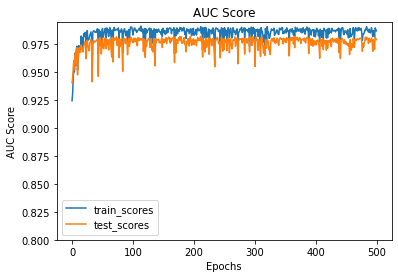

In [30]:
print("weight_decay: ", params_google['weight_decay'], "epochs: ", params_google['epochs'])
plot_train_stats(params_google)

weight_decay:  0.01 epochs:  200


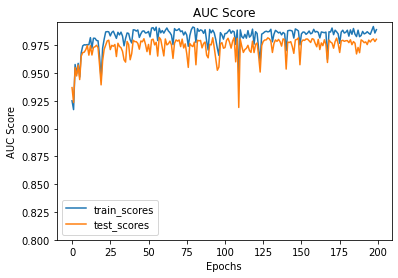

In [27]:
print("weight_decay: ", params_google['weight_decay'], "epochs: ", params_google['epochs'])
plot_train_stats(params_google)

weight_decay:  0.005 epochs:  200


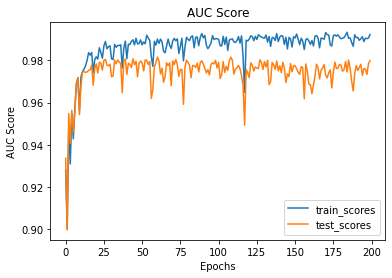

In [22]:
print("weight_decay: ", params_google['weight_decay'], "epochs: ", params_google['epochs'])
plot_train_stats(params_google)

# Azure tlumaczenie

In [31]:
df_azure = pd.read_csv(Path(params_azure['data_dir'], "df_text_azure.csv"))
X_train, X_test, y_train, y_test = main_transformation(df_azure, params_azure['model_dir'], 'dkleczek/bert-base-polish-cased-v1', use_existing=True, test_size=0.33)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Using already prepared data.


((2233, 841), (1100, 841), (2233, 1), (1100, 1))

In [39]:
params_azure['weight_decay'] = 0.01
params_azure['epochs'] = 400
params_azure['pos_weight'] = 1

In [40]:
train.train(
    X=X_train,
    y=y_train,
    X_test=X_test,
    y_test=y_test,
    params=params_azure
)

starting epoch:  1
Train Epoch: 1, train-auc-score: 0.6752


INFO:train:Train Epoch: 1, train-auc-score: 0.6752


test_auc_score: 0.7135


INFO:train:test_auc_score: 0.7135


starting epoch:  2
Train Epoch: 2, train-auc-score: 0.7351


INFO:train:Train Epoch: 2, train-auc-score: 0.7351


test_auc_score: 0.7497


INFO:train:test_auc_score: 0.7497


starting epoch:  3
Train Epoch: 3, train-auc-score: 0.7659


INFO:train:Train Epoch: 3, train-auc-score: 0.7659


test_auc_score: 0.7726


INFO:train:test_auc_score: 0.7726


starting epoch:  4
Train Epoch: 4, train-auc-score: 0.7943


INFO:train:Train Epoch: 4, train-auc-score: 0.7943


test_auc_score: 0.7908


INFO:train:test_auc_score: 0.7908


starting epoch:  5
Train Epoch: 5, train-auc-score: 0.8231


INFO:train:Train Epoch: 5, train-auc-score: 0.8231


test_auc_score: 0.8334


INFO:train:test_auc_score: 0.8334


starting epoch:  6
Train Epoch: 6, train-auc-score: 0.8400


INFO:train:Train Epoch: 6, train-auc-score: 0.8400


test_auc_score: 0.8498


INFO:train:test_auc_score: 0.8498


starting epoch:  7
Train Epoch: 7, train-auc-score: 0.8758


INFO:train:Train Epoch: 7, train-auc-score: 0.8758


test_auc_score: 0.8664


INFO:train:test_auc_score: 0.8664


starting epoch:  8
Train Epoch: 8, train-auc-score: 0.8661


INFO:train:Train Epoch: 8, train-auc-score: 0.8661


test_auc_score: 0.8858


INFO:train:test_auc_score: 0.8858


starting epoch:  9
Train Epoch: 9, train-auc-score: 0.8646


INFO:train:Train Epoch: 9, train-auc-score: 0.8646


test_auc_score: 0.8778


INFO:train:test_auc_score: 0.8778


starting epoch:  10
Train Epoch: 10, train-auc-score: 0.8745


INFO:train:Train Epoch: 10, train-auc-score: 0.8745


test_auc_score: 0.8821


INFO:train:test_auc_score: 0.8821


starting epoch:  11
Train Epoch: 11, train-auc-score: 0.8873


INFO:train:Train Epoch: 11, train-auc-score: 0.8873


test_auc_score: 0.8846


INFO:train:test_auc_score: 0.8846


starting epoch:  12
Train Epoch: 12, train-auc-score: 0.9027


INFO:train:Train Epoch: 12, train-auc-score: 0.9027


test_auc_score: 0.9012


INFO:train:test_auc_score: 0.9012


starting epoch:  13
Train Epoch: 13, train-auc-score: 0.8930


INFO:train:Train Epoch: 13, train-auc-score: 0.8930


test_auc_score: 0.9032


INFO:train:test_auc_score: 0.9032


starting epoch:  14
Train Epoch: 14, train-auc-score: 0.9225


INFO:train:Train Epoch: 14, train-auc-score: 0.9225


test_auc_score: 0.9124


INFO:train:test_auc_score: 0.9124


starting epoch:  15
Train Epoch: 15, train-auc-score: 0.9018


INFO:train:Train Epoch: 15, train-auc-score: 0.9018


test_auc_score: 0.9067


INFO:train:test_auc_score: 0.9067


starting epoch:  16
Train Epoch: 16, train-auc-score: 0.9126


INFO:train:Train Epoch: 16, train-auc-score: 0.9126


test_auc_score: 0.9093


INFO:train:test_auc_score: 0.9093


starting epoch:  17
Train Epoch: 17, train-auc-score: 0.9154


INFO:train:Train Epoch: 17, train-auc-score: 0.9154


test_auc_score: 0.9176


INFO:train:test_auc_score: 0.9176


starting epoch:  18
Train Epoch: 18, train-auc-score: 0.9198


INFO:train:Train Epoch: 18, train-auc-score: 0.9198


test_auc_score: 0.9247


INFO:train:test_auc_score: 0.9247


starting epoch:  19
Train Epoch: 19, train-auc-score: 0.9226


INFO:train:Train Epoch: 19, train-auc-score: 0.9226


test_auc_score: 0.9236


INFO:train:test_auc_score: 0.9236


starting epoch:  20
Train Epoch: 20, train-auc-score: 0.9188


INFO:train:Train Epoch: 20, train-auc-score: 0.9188


test_auc_score: 0.9169


INFO:train:test_auc_score: 0.9169


starting epoch:  21
Train Epoch: 21, train-auc-score: 0.9168


INFO:train:Train Epoch: 21, train-auc-score: 0.9168


test_auc_score: 0.9186


INFO:train:test_auc_score: 0.9186


starting epoch:  22
Train Epoch: 22, train-auc-score: 0.9276


INFO:train:Train Epoch: 22, train-auc-score: 0.9276


test_auc_score: 0.9257


INFO:train:test_auc_score: 0.9257


starting epoch:  23
Train Epoch: 23, train-auc-score: 0.9304


INFO:train:Train Epoch: 23, train-auc-score: 0.9304


test_auc_score: 0.9251


INFO:train:test_auc_score: 0.9251


starting epoch:  24
Train Epoch: 24, train-auc-score: 0.9331


INFO:train:Train Epoch: 24, train-auc-score: 0.9331


test_auc_score: 0.9280


INFO:train:test_auc_score: 0.9280


starting epoch:  25
Train Epoch: 25, train-auc-score: 0.9305


INFO:train:Train Epoch: 25, train-auc-score: 0.9305


test_auc_score: 0.9280


INFO:train:test_auc_score: 0.9280


starting epoch:  26
Train Epoch: 26, train-auc-score: 0.9233


INFO:train:Train Epoch: 26, train-auc-score: 0.9233


test_auc_score: 0.9224


INFO:train:test_auc_score: 0.9224


starting epoch:  27
Train Epoch: 27, train-auc-score: 0.9270


INFO:train:Train Epoch: 27, train-auc-score: 0.9270


test_auc_score: 0.9297


INFO:train:test_auc_score: 0.9297


starting epoch:  28
Train Epoch: 28, train-auc-score: 0.9361


INFO:train:Train Epoch: 28, train-auc-score: 0.9361


test_auc_score: 0.9276


INFO:train:test_auc_score: 0.9276


starting epoch:  29
Train Epoch: 29, train-auc-score: 0.9361


INFO:train:Train Epoch: 29, train-auc-score: 0.9361


test_auc_score: 0.9355


INFO:train:test_auc_score: 0.9355


starting epoch:  30
Train Epoch: 30, train-auc-score: 0.9288


INFO:train:Train Epoch: 30, train-auc-score: 0.9288


test_auc_score: 0.9335


INFO:train:test_auc_score: 0.9335


starting epoch:  31
Train Epoch: 31, train-auc-score: 0.9409


INFO:train:Train Epoch: 31, train-auc-score: 0.9409


test_auc_score: 0.9342


INFO:train:test_auc_score: 0.9342


starting epoch:  32
Train Epoch: 32, train-auc-score: 0.9402


INFO:train:Train Epoch: 32, train-auc-score: 0.9402


test_auc_score: 0.9350


INFO:train:test_auc_score: 0.9350


starting epoch:  33
Train Epoch: 33, train-auc-score: 0.9361


INFO:train:Train Epoch: 33, train-auc-score: 0.9361


test_auc_score: 0.9328


INFO:train:test_auc_score: 0.9328


starting epoch:  34
Train Epoch: 34, train-auc-score: 0.9365


INFO:train:Train Epoch: 34, train-auc-score: 0.9365


test_auc_score: 0.9311


INFO:train:test_auc_score: 0.9311


starting epoch:  35
Train Epoch: 35, train-auc-score: 0.9405


INFO:train:Train Epoch: 35, train-auc-score: 0.9405


test_auc_score: 0.9336


INFO:train:test_auc_score: 0.9336


starting epoch:  36
Train Epoch: 36, train-auc-score: 0.9407


INFO:train:Train Epoch: 36, train-auc-score: 0.9407


test_auc_score: 0.9363


INFO:train:test_auc_score: 0.9363


starting epoch:  37
Train Epoch: 37, train-auc-score: 0.9415


INFO:train:Train Epoch: 37, train-auc-score: 0.9415


test_auc_score: 0.9380


INFO:train:test_auc_score: 0.9380


starting epoch:  38
Train Epoch: 38, train-auc-score: 0.9467


INFO:train:Train Epoch: 38, train-auc-score: 0.9467


test_auc_score: 0.9375


INFO:train:test_auc_score: 0.9375


starting epoch:  39
Train Epoch: 39, train-auc-score: 0.9331


INFO:train:Train Epoch: 39, train-auc-score: 0.9331


test_auc_score: 0.9357


INFO:train:test_auc_score: 0.9357


starting epoch:  40
Train Epoch: 40, train-auc-score: 0.9466


INFO:train:Train Epoch: 40, train-auc-score: 0.9466


test_auc_score: 0.9405


INFO:train:test_auc_score: 0.9405


starting epoch:  41
Train Epoch: 41, train-auc-score: 0.9467


INFO:train:Train Epoch: 41, train-auc-score: 0.9467


test_auc_score: 0.9411


INFO:train:test_auc_score: 0.9411


starting epoch:  42
Train Epoch: 42, train-auc-score: 0.9316


INFO:train:Train Epoch: 42, train-auc-score: 0.9316


test_auc_score: 0.9360


INFO:train:test_auc_score: 0.9360


starting epoch:  43
Train Epoch: 43, train-auc-score: 0.9441


INFO:train:Train Epoch: 43, train-auc-score: 0.9441


test_auc_score: 0.9372


INFO:train:test_auc_score: 0.9372


starting epoch:  44
Train Epoch: 44, train-auc-score: 0.9456


INFO:train:Train Epoch: 44, train-auc-score: 0.9456


test_auc_score: 0.9394


INFO:train:test_auc_score: 0.9394


starting epoch:  45
Train Epoch: 45, train-auc-score: 0.9429


INFO:train:Train Epoch: 45, train-auc-score: 0.9429


test_auc_score: 0.9416


INFO:train:test_auc_score: 0.9416


starting epoch:  46
Train Epoch: 46, train-auc-score: 0.9521


INFO:train:Train Epoch: 46, train-auc-score: 0.9521


test_auc_score: 0.9393


INFO:train:test_auc_score: 0.9393


starting epoch:  47
Train Epoch: 47, train-auc-score: 0.9422


INFO:train:Train Epoch: 47, train-auc-score: 0.9422


test_auc_score: 0.9414


INFO:train:test_auc_score: 0.9414


starting epoch:  48
Train Epoch: 48, train-auc-score: 0.9476


INFO:train:Train Epoch: 48, train-auc-score: 0.9476


test_auc_score: 0.9397


INFO:train:test_auc_score: 0.9397


starting epoch:  49
Train Epoch: 49, train-auc-score: 0.9469


INFO:train:Train Epoch: 49, train-auc-score: 0.9469


test_auc_score: 0.9441


INFO:train:test_auc_score: 0.9441


starting epoch:  50
Train Epoch: 50, train-auc-score: 0.9499


INFO:train:Train Epoch: 50, train-auc-score: 0.9499


test_auc_score: 0.9428


INFO:train:test_auc_score: 0.9428


starting epoch:  51
Train Epoch: 51, train-auc-score: 0.9474


INFO:train:Train Epoch: 51, train-auc-score: 0.9474


test_auc_score: 0.9433


INFO:train:test_auc_score: 0.9433


starting epoch:  52
Train Epoch: 52, train-auc-score: 0.9496


INFO:train:Train Epoch: 52, train-auc-score: 0.9496


test_auc_score: 0.9426


INFO:train:test_auc_score: 0.9426


starting epoch:  53
Train Epoch: 53, train-auc-score: 0.9478


INFO:train:Train Epoch: 53, train-auc-score: 0.9478


test_auc_score: 0.9440


INFO:train:test_auc_score: 0.9440


starting epoch:  54
Train Epoch: 54, train-auc-score: 0.9507


INFO:train:Train Epoch: 54, train-auc-score: 0.9507


test_auc_score: 0.9441


INFO:train:test_auc_score: 0.9441


starting epoch:  55
Train Epoch: 55, train-auc-score: 0.9467


INFO:train:Train Epoch: 55, train-auc-score: 0.9467


test_auc_score: 0.9405


INFO:train:test_auc_score: 0.9405


starting epoch:  56
Train Epoch: 56, train-auc-score: 0.9481


INFO:train:Train Epoch: 56, train-auc-score: 0.9481


test_auc_score: 0.9427


INFO:train:test_auc_score: 0.9427


starting epoch:  57
Train Epoch: 57, train-auc-score: 0.9460


INFO:train:Train Epoch: 57, train-auc-score: 0.9460


test_auc_score: 0.9450


INFO:train:test_auc_score: 0.9450


starting epoch:  58
Train Epoch: 58, train-auc-score: 0.9488


INFO:train:Train Epoch: 58, train-auc-score: 0.9488


test_auc_score: 0.9443


INFO:train:test_auc_score: 0.9443


starting epoch:  59
Train Epoch: 59, train-auc-score: 0.9474


INFO:train:Train Epoch: 59, train-auc-score: 0.9474


test_auc_score: 0.9470


INFO:train:test_auc_score: 0.9470


starting epoch:  60
Train Epoch: 60, train-auc-score: 0.9534


INFO:train:Train Epoch: 60, train-auc-score: 0.9534


test_auc_score: 0.9467


INFO:train:test_auc_score: 0.9467


starting epoch:  61
Train Epoch: 61, train-auc-score: 0.9423


INFO:train:Train Epoch: 61, train-auc-score: 0.9423


test_auc_score: 0.9415


INFO:train:test_auc_score: 0.9415


starting epoch:  62
Train Epoch: 62, train-auc-score: 0.9483


INFO:train:Train Epoch: 62, train-auc-score: 0.9483


test_auc_score: 0.9469


INFO:train:test_auc_score: 0.9469


starting epoch:  63
Train Epoch: 63, train-auc-score: 0.9481


INFO:train:Train Epoch: 63, train-auc-score: 0.9481


test_auc_score: 0.9443


INFO:train:test_auc_score: 0.9443


starting epoch:  64
Train Epoch: 64, train-auc-score: 0.9455


INFO:train:Train Epoch: 64, train-auc-score: 0.9455


test_auc_score: 0.9439


INFO:train:test_auc_score: 0.9439


starting epoch:  65
Train Epoch: 65, train-auc-score: 0.9478


INFO:train:Train Epoch: 65, train-auc-score: 0.9478


test_auc_score: 0.9469


INFO:train:test_auc_score: 0.9469


starting epoch:  66
Train Epoch: 66, train-auc-score: 0.9533


INFO:train:Train Epoch: 66, train-auc-score: 0.9533


test_auc_score: 0.9475


INFO:train:test_auc_score: 0.9475


starting epoch:  67
Train Epoch: 67, train-auc-score: 0.9508


INFO:train:Train Epoch: 67, train-auc-score: 0.9508


test_auc_score: 0.9476


INFO:train:test_auc_score: 0.9476


starting epoch:  68
Train Epoch: 68, train-auc-score: 0.9444


INFO:train:Train Epoch: 68, train-auc-score: 0.9444


test_auc_score: 0.9429


INFO:train:test_auc_score: 0.9429


starting epoch:  69
Train Epoch: 69, train-auc-score: 0.9489


INFO:train:Train Epoch: 69, train-auc-score: 0.9489


test_auc_score: 0.9458


INFO:train:test_auc_score: 0.9458


starting epoch:  70
Train Epoch: 70, train-auc-score: 0.9491


INFO:train:Train Epoch: 70, train-auc-score: 0.9491


test_auc_score: 0.9481


INFO:train:test_auc_score: 0.9481


starting epoch:  71
Train Epoch: 71, train-auc-score: 0.9560


INFO:train:Train Epoch: 71, train-auc-score: 0.9560


test_auc_score: 0.9455


INFO:train:test_auc_score: 0.9455


starting epoch:  72
Train Epoch: 72, train-auc-score: 0.9562


INFO:train:Train Epoch: 72, train-auc-score: 0.9562


test_auc_score: 0.9496


INFO:train:test_auc_score: 0.9496


starting epoch:  73
Train Epoch: 73, train-auc-score: 0.9512


INFO:train:Train Epoch: 73, train-auc-score: 0.9512


test_auc_score: 0.9468


INFO:train:test_auc_score: 0.9468


starting epoch:  74
Train Epoch: 74, train-auc-score: 0.9576


INFO:train:Train Epoch: 74, train-auc-score: 0.9576


test_auc_score: 0.9499


INFO:train:test_auc_score: 0.9499


starting epoch:  75
Train Epoch: 75, train-auc-score: 0.9655


INFO:train:Train Epoch: 75, train-auc-score: 0.9655


test_auc_score: 0.9516


INFO:train:test_auc_score: 0.9516


starting epoch:  76
Train Epoch: 76, train-auc-score: 0.9558


INFO:train:Train Epoch: 76, train-auc-score: 0.9558


test_auc_score: 0.9508


INFO:train:test_auc_score: 0.9508


starting epoch:  77
Train Epoch: 77, train-auc-score: 0.9525


INFO:train:Train Epoch: 77, train-auc-score: 0.9525


test_auc_score: 0.9487


INFO:train:test_auc_score: 0.9487


starting epoch:  78
Train Epoch: 78, train-auc-score: 0.9594


INFO:train:Train Epoch: 78, train-auc-score: 0.9594


test_auc_score: 0.9474


INFO:train:test_auc_score: 0.9474


starting epoch:  79
Train Epoch: 79, train-auc-score: 0.9518


INFO:train:Train Epoch: 79, train-auc-score: 0.9518


test_auc_score: 0.9488


INFO:train:test_auc_score: 0.9488


starting epoch:  80
Train Epoch: 80, train-auc-score: 0.9573


INFO:train:Train Epoch: 80, train-auc-score: 0.9573


test_auc_score: 0.9501


INFO:train:test_auc_score: 0.9501


starting epoch:  81
Train Epoch: 81, train-auc-score: 0.9592


INFO:train:Train Epoch: 81, train-auc-score: 0.9592


test_auc_score: 0.9517


INFO:train:test_auc_score: 0.9517


starting epoch:  82
Train Epoch: 82, train-auc-score: 0.9573


INFO:train:Train Epoch: 82, train-auc-score: 0.9573


test_auc_score: 0.9499


INFO:train:test_auc_score: 0.9499


starting epoch:  83
Train Epoch: 83, train-auc-score: 0.9605


INFO:train:Train Epoch: 83, train-auc-score: 0.9605


test_auc_score: 0.9531


INFO:train:test_auc_score: 0.9531


starting epoch:  84
Train Epoch: 84, train-auc-score: 0.9586


INFO:train:Train Epoch: 84, train-auc-score: 0.9586


test_auc_score: 0.9523


INFO:train:test_auc_score: 0.9523


starting epoch:  85
Train Epoch: 85, train-auc-score: 0.9552


INFO:train:Train Epoch: 85, train-auc-score: 0.9552


test_auc_score: 0.9523


INFO:train:test_auc_score: 0.9523


starting epoch:  86
Train Epoch: 86, train-auc-score: 0.9616


INFO:train:Train Epoch: 86, train-auc-score: 0.9616


test_auc_score: 0.9530


INFO:train:test_auc_score: 0.9530


starting epoch:  87
Train Epoch: 87, train-auc-score: 0.9554


INFO:train:Train Epoch: 87, train-auc-score: 0.9554


test_auc_score: 0.9523


INFO:train:test_auc_score: 0.9523


starting epoch:  88
Train Epoch: 88, train-auc-score: 0.9589


INFO:train:Train Epoch: 88, train-auc-score: 0.9589


test_auc_score: 0.9512


INFO:train:test_auc_score: 0.9512


starting epoch:  89
Train Epoch: 89, train-auc-score: 0.9615


INFO:train:Train Epoch: 89, train-auc-score: 0.9615


test_auc_score: 0.9529


INFO:train:test_auc_score: 0.9529


starting epoch:  90
Train Epoch: 90, train-auc-score: 0.9587


INFO:train:Train Epoch: 90, train-auc-score: 0.9587


test_auc_score: 0.9534


INFO:train:test_auc_score: 0.9534


starting epoch:  91
Train Epoch: 91, train-auc-score: 0.9609


INFO:train:Train Epoch: 91, train-auc-score: 0.9609


test_auc_score: 0.9535


INFO:train:test_auc_score: 0.9535


starting epoch:  92
Train Epoch: 92, train-auc-score: 0.9609


INFO:train:Train Epoch: 92, train-auc-score: 0.9609


test_auc_score: 0.9535


INFO:train:test_auc_score: 0.9535


starting epoch:  93
Train Epoch: 93, train-auc-score: 0.9582


INFO:train:Train Epoch: 93, train-auc-score: 0.9582


test_auc_score: 0.9529


INFO:train:test_auc_score: 0.9529


starting epoch:  94
Train Epoch: 94, train-auc-score: 0.9556


INFO:train:Train Epoch: 94, train-auc-score: 0.9556


test_auc_score: 0.9513


INFO:train:test_auc_score: 0.9513


starting epoch:  95
Train Epoch: 95, train-auc-score: 0.9653


INFO:train:Train Epoch: 95, train-auc-score: 0.9653


test_auc_score: 0.9547


INFO:train:test_auc_score: 0.9547


starting epoch:  96
Train Epoch: 96, train-auc-score: 0.9635


INFO:train:Train Epoch: 96, train-auc-score: 0.9635


test_auc_score: 0.9547


INFO:train:test_auc_score: 0.9547


starting epoch:  97
Train Epoch: 97, train-auc-score: 0.9574


INFO:train:Train Epoch: 97, train-auc-score: 0.9574


test_auc_score: 0.9556


INFO:train:test_auc_score: 0.9556


starting epoch:  98
Train Epoch: 98, train-auc-score: 0.9586


INFO:train:Train Epoch: 98, train-auc-score: 0.9586


test_auc_score: 0.9552


INFO:train:test_auc_score: 0.9552


starting epoch:  99
Train Epoch: 99, train-auc-score: 0.9580


INFO:train:Train Epoch: 99, train-auc-score: 0.9580


test_auc_score: 0.9539


INFO:train:test_auc_score: 0.9539


starting epoch:  100
Train Epoch: 100, train-auc-score: 0.9618


INFO:train:Train Epoch: 100, train-auc-score: 0.9618


test_auc_score: 0.9546


INFO:train:test_auc_score: 0.9546


starting epoch:  101
Train Epoch: 101, train-auc-score: 0.9609


INFO:train:Train Epoch: 101, train-auc-score: 0.9609


test_auc_score: 0.9552


INFO:train:test_auc_score: 0.9552


starting epoch:  102
Train Epoch: 102, train-auc-score: 0.9600


INFO:train:Train Epoch: 102, train-auc-score: 0.9600


test_auc_score: 0.9549


INFO:train:test_auc_score: 0.9549


starting epoch:  103
Train Epoch: 103, train-auc-score: 0.9618


INFO:train:Train Epoch: 103, train-auc-score: 0.9618


test_auc_score: 0.9548


INFO:train:test_auc_score: 0.9548


starting epoch:  104
Train Epoch: 104, train-auc-score: 0.9618


INFO:train:Train Epoch: 104, train-auc-score: 0.9618


test_auc_score: 0.9559


INFO:train:test_auc_score: 0.9559


starting epoch:  105
Train Epoch: 105, train-auc-score: 0.9651


INFO:train:Train Epoch: 105, train-auc-score: 0.9651


test_auc_score: 0.9559


INFO:train:test_auc_score: 0.9559


starting epoch:  106
Train Epoch: 106, train-auc-score: 0.9570


INFO:train:Train Epoch: 106, train-auc-score: 0.9570


test_auc_score: 0.9559


INFO:train:test_auc_score: 0.9559


starting epoch:  107
Train Epoch: 107, train-auc-score: 0.9613


INFO:train:Train Epoch: 107, train-auc-score: 0.9613


test_auc_score: 0.9539


INFO:train:test_auc_score: 0.9539


starting epoch:  108
Train Epoch: 108, train-auc-score: 0.9600


INFO:train:Train Epoch: 108, train-auc-score: 0.9600


test_auc_score: 0.9560


INFO:train:test_auc_score: 0.9560


starting epoch:  109
Train Epoch: 109, train-auc-score: 0.9633


INFO:train:Train Epoch: 109, train-auc-score: 0.9633


test_auc_score: 0.9574


INFO:train:test_auc_score: 0.9574


starting epoch:  110
Train Epoch: 110, train-auc-score: 0.9645


INFO:train:Train Epoch: 110, train-auc-score: 0.9645


test_auc_score: 0.9557


INFO:train:test_auc_score: 0.9557


starting epoch:  111
Train Epoch: 111, train-auc-score: 0.9582


INFO:train:Train Epoch: 111, train-auc-score: 0.9582


test_auc_score: 0.9573


INFO:train:test_auc_score: 0.9573


starting epoch:  112
Train Epoch: 112, train-auc-score: 0.9637


INFO:train:Train Epoch: 112, train-auc-score: 0.9637


test_auc_score: 0.9564


INFO:train:test_auc_score: 0.9564


starting epoch:  113
Train Epoch: 113, train-auc-score: 0.9647


INFO:train:Train Epoch: 113, train-auc-score: 0.9647


test_auc_score: 0.9557


INFO:train:test_auc_score: 0.9557


starting epoch:  114
Train Epoch: 114, train-auc-score: 0.9648


INFO:train:Train Epoch: 114, train-auc-score: 0.9648


test_auc_score: 0.9576


INFO:train:test_auc_score: 0.9576


starting epoch:  115
Train Epoch: 115, train-auc-score: 0.9688


INFO:train:Train Epoch: 115, train-auc-score: 0.9688


test_auc_score: 0.9587


INFO:train:test_auc_score: 0.9587


starting epoch:  116
Train Epoch: 116, train-auc-score: 0.9577


INFO:train:Train Epoch: 116, train-auc-score: 0.9577


test_auc_score: 0.9579


INFO:train:test_auc_score: 0.9579


starting epoch:  117
Train Epoch: 117, train-auc-score: 0.9622


INFO:train:Train Epoch: 117, train-auc-score: 0.9622


test_auc_score: 0.9578


INFO:train:test_auc_score: 0.9578


starting epoch:  118
Train Epoch: 118, train-auc-score: 0.9643


INFO:train:Train Epoch: 118, train-auc-score: 0.9643


test_auc_score: 0.9595


INFO:train:test_auc_score: 0.9595


starting epoch:  119
Train Epoch: 119, train-auc-score: 0.9605


INFO:train:Train Epoch: 119, train-auc-score: 0.9605


test_auc_score: 0.9583


INFO:train:test_auc_score: 0.9583


starting epoch:  120
Train Epoch: 120, train-auc-score: 0.9637


INFO:train:Train Epoch: 120, train-auc-score: 0.9637


test_auc_score: 0.9588


INFO:train:test_auc_score: 0.9588


starting epoch:  121
Train Epoch: 121, train-auc-score: 0.9609


INFO:train:Train Epoch: 121, train-auc-score: 0.9609


test_auc_score: 0.9581


INFO:train:test_auc_score: 0.9581


starting epoch:  122
Train Epoch: 122, train-auc-score: 0.9622


INFO:train:Train Epoch: 122, train-auc-score: 0.9622


test_auc_score: 0.9584


INFO:train:test_auc_score: 0.9584


starting epoch:  123
Train Epoch: 123, train-auc-score: 0.9592


INFO:train:Train Epoch: 123, train-auc-score: 0.9592


test_auc_score: 0.9577


INFO:train:test_auc_score: 0.9577


starting epoch:  124
Train Epoch: 124, train-auc-score: 0.9672


INFO:train:Train Epoch: 124, train-auc-score: 0.9672


test_auc_score: 0.9591


INFO:train:test_auc_score: 0.9591


starting epoch:  125
Train Epoch: 125, train-auc-score: 0.9647


INFO:train:Train Epoch: 125, train-auc-score: 0.9647


test_auc_score: 0.9583


INFO:train:test_auc_score: 0.9583


starting epoch:  126
Train Epoch: 126, train-auc-score: 0.9645


INFO:train:Train Epoch: 126, train-auc-score: 0.9645


test_auc_score: 0.9590


INFO:train:test_auc_score: 0.9590


starting epoch:  127
Train Epoch: 127, train-auc-score: 0.9661


INFO:train:Train Epoch: 127, train-auc-score: 0.9661


test_auc_score: 0.9585


INFO:train:test_auc_score: 0.9585


starting epoch:  128
Train Epoch: 128, train-auc-score: 0.9635


INFO:train:Train Epoch: 128, train-auc-score: 0.9635


test_auc_score: 0.9605


INFO:train:test_auc_score: 0.9605


starting epoch:  129
Train Epoch: 129, train-auc-score: 0.9658


INFO:train:Train Epoch: 129, train-auc-score: 0.9658


test_auc_score: 0.9607


INFO:train:test_auc_score: 0.9607


starting epoch:  130
Train Epoch: 130, train-auc-score: 0.9684


INFO:train:Train Epoch: 130, train-auc-score: 0.9684


test_auc_score: 0.9598


INFO:train:test_auc_score: 0.9598


starting epoch:  131
Train Epoch: 131, train-auc-score: 0.9613


INFO:train:Train Epoch: 131, train-auc-score: 0.9613


test_auc_score: 0.9591


INFO:train:test_auc_score: 0.9591


starting epoch:  132
Train Epoch: 132, train-auc-score: 0.9652


INFO:train:Train Epoch: 132, train-auc-score: 0.9652


test_auc_score: 0.9602


INFO:train:test_auc_score: 0.9602


starting epoch:  133
Train Epoch: 133, train-auc-score: 0.9606


INFO:train:Train Epoch: 133, train-auc-score: 0.9606


test_auc_score: 0.9589


INFO:train:test_auc_score: 0.9589


starting epoch:  134
Train Epoch: 134, train-auc-score: 0.9614


INFO:train:Train Epoch: 134, train-auc-score: 0.9614


test_auc_score: 0.9601


INFO:train:test_auc_score: 0.9601


starting epoch:  135
Train Epoch: 135, train-auc-score: 0.9672


INFO:train:Train Epoch: 135, train-auc-score: 0.9672


test_auc_score: 0.9611


INFO:train:test_auc_score: 0.9611


starting epoch:  136
Train Epoch: 136, train-auc-score: 0.9687


INFO:train:Train Epoch: 136, train-auc-score: 0.9687


test_auc_score: 0.9607


INFO:train:test_auc_score: 0.9607


starting epoch:  137
Train Epoch: 137, train-auc-score: 0.9696


INFO:train:Train Epoch: 137, train-auc-score: 0.9696


test_auc_score: 0.9618


INFO:train:test_auc_score: 0.9618


starting epoch:  138
Train Epoch: 138, train-auc-score: 0.9664


INFO:train:Train Epoch: 138, train-auc-score: 0.9664


test_auc_score: 0.9617


INFO:train:test_auc_score: 0.9617


starting epoch:  139
Train Epoch: 139, train-auc-score: 0.9689


INFO:train:Train Epoch: 139, train-auc-score: 0.9689


test_auc_score: 0.9632


INFO:train:test_auc_score: 0.9632


starting epoch:  140
Train Epoch: 140, train-auc-score: 0.9724


INFO:train:Train Epoch: 140, train-auc-score: 0.9724


test_auc_score: 0.9600


INFO:train:test_auc_score: 0.9600


starting epoch:  141
Train Epoch: 141, train-auc-score: 0.9616


INFO:train:Train Epoch: 141, train-auc-score: 0.9616


test_auc_score: 0.9623


INFO:train:test_auc_score: 0.9623


starting epoch:  142
Train Epoch: 142, train-auc-score: 0.9672


INFO:train:Train Epoch: 142, train-auc-score: 0.9672


test_auc_score: 0.9614


INFO:train:test_auc_score: 0.9614


starting epoch:  143
Train Epoch: 143, train-auc-score: 0.9696


INFO:train:Train Epoch: 143, train-auc-score: 0.9696


test_auc_score: 0.9608


INFO:train:test_auc_score: 0.9608


starting epoch:  144
Train Epoch: 144, train-auc-score: 0.9691


INFO:train:Train Epoch: 144, train-auc-score: 0.9691


test_auc_score: 0.9622


INFO:train:test_auc_score: 0.9622


starting epoch:  145
Train Epoch: 145, train-auc-score: 0.9734


INFO:train:Train Epoch: 145, train-auc-score: 0.9734


test_auc_score: 0.9637


INFO:train:test_auc_score: 0.9637


starting epoch:  146
Train Epoch: 146, train-auc-score: 0.9673


INFO:train:Train Epoch: 146, train-auc-score: 0.9673


test_auc_score: 0.9621


INFO:train:test_auc_score: 0.9621


starting epoch:  147
Train Epoch: 147, train-auc-score: 0.9667


INFO:train:Train Epoch: 147, train-auc-score: 0.9667


test_auc_score: 0.9627


INFO:train:test_auc_score: 0.9627


starting epoch:  148
Train Epoch: 148, train-auc-score: 0.9731


INFO:train:Train Epoch: 148, train-auc-score: 0.9731


test_auc_score: 0.9616


INFO:train:test_auc_score: 0.9616


starting epoch:  149
Train Epoch: 149, train-auc-score: 0.9674


INFO:train:Train Epoch: 149, train-auc-score: 0.9674


test_auc_score: 0.9625


INFO:train:test_auc_score: 0.9625


starting epoch:  150
Train Epoch: 150, train-auc-score: 0.9697


INFO:train:Train Epoch: 150, train-auc-score: 0.9697


test_auc_score: 0.9632


INFO:train:test_auc_score: 0.9632


starting epoch:  151
Train Epoch: 151, train-auc-score: 0.9647


INFO:train:Train Epoch: 151, train-auc-score: 0.9647


test_auc_score: 0.9612


INFO:train:test_auc_score: 0.9612


starting epoch:  152
Train Epoch: 152, train-auc-score: 0.9751


INFO:train:Train Epoch: 152, train-auc-score: 0.9751


test_auc_score: 0.9659


INFO:train:test_auc_score: 0.9659


starting epoch:  153
Train Epoch: 153, train-auc-score: 0.9697


INFO:train:Train Epoch: 153, train-auc-score: 0.9697


test_auc_score: 0.9631


INFO:train:test_auc_score: 0.9631


starting epoch:  154
Train Epoch: 154, train-auc-score: 0.9688


INFO:train:Train Epoch: 154, train-auc-score: 0.9688


test_auc_score: 0.9642


INFO:train:test_auc_score: 0.9642


starting epoch:  155
Train Epoch: 155, train-auc-score: 0.9692


INFO:train:Train Epoch: 155, train-auc-score: 0.9692


test_auc_score: 0.9639


INFO:train:test_auc_score: 0.9639


starting epoch:  156
Train Epoch: 156, train-auc-score: 0.9708


INFO:train:Train Epoch: 156, train-auc-score: 0.9708


test_auc_score: 0.9611


INFO:train:test_auc_score: 0.9611


starting epoch:  157
Train Epoch: 157, train-auc-score: 0.9708


INFO:train:Train Epoch: 157, train-auc-score: 0.9708


test_auc_score: 0.9641


INFO:train:test_auc_score: 0.9641


starting epoch:  158
Train Epoch: 158, train-auc-score: 0.9681


INFO:train:Train Epoch: 158, train-auc-score: 0.9681


test_auc_score: 0.9634


INFO:train:test_auc_score: 0.9634


starting epoch:  159
Train Epoch: 159, train-auc-score: 0.9697


INFO:train:Train Epoch: 159, train-auc-score: 0.9697


test_auc_score: 0.9625


INFO:train:test_auc_score: 0.9625


starting epoch:  160
Train Epoch: 160, train-auc-score: 0.9687


INFO:train:Train Epoch: 160, train-auc-score: 0.9687


test_auc_score: 0.9632


INFO:train:test_auc_score: 0.9632


starting epoch:  161
Train Epoch: 161, train-auc-score: 0.9639


INFO:train:Train Epoch: 161, train-auc-score: 0.9639


test_auc_score: 0.9608


INFO:train:test_auc_score: 0.9608


starting epoch:  162
Train Epoch: 162, train-auc-score: 0.9712


INFO:train:Train Epoch: 162, train-auc-score: 0.9712


test_auc_score: 0.9644


INFO:train:test_auc_score: 0.9644


starting epoch:  163
Train Epoch: 163, train-auc-score: 0.9660


INFO:train:Train Epoch: 163, train-auc-score: 0.9660


test_auc_score: 0.9623


INFO:train:test_auc_score: 0.9623


starting epoch:  164
Train Epoch: 164, train-auc-score: 0.9732


INFO:train:Train Epoch: 164, train-auc-score: 0.9732


test_auc_score: 0.9640


INFO:train:test_auc_score: 0.9640


starting epoch:  165
Train Epoch: 165, train-auc-score: 0.9709


INFO:train:Train Epoch: 165, train-auc-score: 0.9709


test_auc_score: 0.9644


INFO:train:test_auc_score: 0.9644


starting epoch:  166
Train Epoch: 166, train-auc-score: 0.9701


INFO:train:Train Epoch: 166, train-auc-score: 0.9701


test_auc_score: 0.9639


INFO:train:test_auc_score: 0.9639


starting epoch:  167
Train Epoch: 167, train-auc-score: 0.9677


INFO:train:Train Epoch: 167, train-auc-score: 0.9677


test_auc_score: 0.9639


INFO:train:test_auc_score: 0.9639


starting epoch:  168
Train Epoch: 168, train-auc-score: 0.9730


INFO:train:Train Epoch: 168, train-auc-score: 0.9730


test_auc_score: 0.9657


INFO:train:test_auc_score: 0.9657


starting epoch:  169
Train Epoch: 169, train-auc-score: 0.9734


INFO:train:Train Epoch: 169, train-auc-score: 0.9734


test_auc_score: 0.9653


INFO:train:test_auc_score: 0.9653


starting epoch:  170
Train Epoch: 170, train-auc-score: 0.9735


INFO:train:Train Epoch: 170, train-auc-score: 0.9735


test_auc_score: 0.9661


INFO:train:test_auc_score: 0.9661


starting epoch:  171
Train Epoch: 171, train-auc-score: 0.9690


INFO:train:Train Epoch: 171, train-auc-score: 0.9690


test_auc_score: 0.9652


INFO:train:test_auc_score: 0.9652


starting epoch:  172
Train Epoch: 172, train-auc-score: 0.9717


INFO:train:Train Epoch: 172, train-auc-score: 0.9717


test_auc_score: 0.9659


INFO:train:test_auc_score: 0.9659


starting epoch:  173
Train Epoch: 173, train-auc-score: 0.9726


INFO:train:Train Epoch: 173, train-auc-score: 0.9726


test_auc_score: 0.9659


INFO:train:test_auc_score: 0.9659


starting epoch:  174
Train Epoch: 174, train-auc-score: 0.9681


INFO:train:Train Epoch: 174, train-auc-score: 0.9681


test_auc_score: 0.9649


INFO:train:test_auc_score: 0.9649


starting epoch:  175
Train Epoch: 175, train-auc-score: 0.9687


INFO:train:Train Epoch: 175, train-auc-score: 0.9687


test_auc_score: 0.9651


INFO:train:test_auc_score: 0.9651


starting epoch:  176
Train Epoch: 176, train-auc-score: 0.9677


INFO:train:Train Epoch: 176, train-auc-score: 0.9677


test_auc_score: 0.9659


INFO:train:test_auc_score: 0.9659


starting epoch:  177
Train Epoch: 177, train-auc-score: 0.9740


INFO:train:Train Epoch: 177, train-auc-score: 0.9740


test_auc_score: 0.9670


INFO:train:test_auc_score: 0.9670


starting epoch:  178
Train Epoch: 178, train-auc-score: 0.9758


INFO:train:Train Epoch: 178, train-auc-score: 0.9758


test_auc_score: 0.9656


INFO:train:test_auc_score: 0.9656


starting epoch:  179
Train Epoch: 179, train-auc-score: 0.9726


INFO:train:Train Epoch: 179, train-auc-score: 0.9726


test_auc_score: 0.9656


INFO:train:test_auc_score: 0.9656


starting epoch:  180
Train Epoch: 180, train-auc-score: 0.9750


INFO:train:Train Epoch: 180, train-auc-score: 0.9750


test_auc_score: 0.9651


INFO:train:test_auc_score: 0.9651


starting epoch:  181
Train Epoch: 181, train-auc-score: 0.9750


INFO:train:Train Epoch: 181, train-auc-score: 0.9750


test_auc_score: 0.9668


INFO:train:test_auc_score: 0.9668


starting epoch:  182
Train Epoch: 182, train-auc-score: 0.9748


INFO:train:Train Epoch: 182, train-auc-score: 0.9748


test_auc_score: 0.9657


INFO:train:test_auc_score: 0.9657


starting epoch:  183
Train Epoch: 183, train-auc-score: 0.9716


INFO:train:Train Epoch: 183, train-auc-score: 0.9716


test_auc_score: 0.9647


INFO:train:test_auc_score: 0.9647


starting epoch:  184
Train Epoch: 184, train-auc-score: 0.9701


INFO:train:Train Epoch: 184, train-auc-score: 0.9701


test_auc_score: 0.9666


INFO:train:test_auc_score: 0.9666


starting epoch:  185
Train Epoch: 185, train-auc-score: 0.9703


INFO:train:Train Epoch: 185, train-auc-score: 0.9703


test_auc_score: 0.9651


INFO:train:test_auc_score: 0.9651


starting epoch:  186
Train Epoch: 186, train-auc-score: 0.9736


INFO:train:Train Epoch: 186, train-auc-score: 0.9736


test_auc_score: 0.9654


INFO:train:test_auc_score: 0.9654


starting epoch:  187
Train Epoch: 187, train-auc-score: 0.9755


INFO:train:Train Epoch: 187, train-auc-score: 0.9755


test_auc_score: 0.9656


INFO:train:test_auc_score: 0.9656


starting epoch:  188
Train Epoch: 188, train-auc-score: 0.9718


INFO:train:Train Epoch: 188, train-auc-score: 0.9718


test_auc_score: 0.9643


INFO:train:test_auc_score: 0.9643


starting epoch:  189
Train Epoch: 189, train-auc-score: 0.9743


INFO:train:Train Epoch: 189, train-auc-score: 0.9743


test_auc_score: 0.9670


INFO:train:test_auc_score: 0.9670


starting epoch:  190
Train Epoch: 190, train-auc-score: 0.9754


INFO:train:Train Epoch: 190, train-auc-score: 0.9754


test_auc_score: 0.9652


INFO:train:test_auc_score: 0.9652


starting epoch:  191
Train Epoch: 191, train-auc-score: 0.9695


INFO:train:Train Epoch: 191, train-auc-score: 0.9695


test_auc_score: 0.9663


INFO:train:test_auc_score: 0.9663


starting epoch:  192
Train Epoch: 192, train-auc-score: 0.9699


INFO:train:Train Epoch: 192, train-auc-score: 0.9699


test_auc_score: 0.9653


INFO:train:test_auc_score: 0.9653


starting epoch:  193
Train Epoch: 193, train-auc-score: 0.9779


INFO:train:Train Epoch: 193, train-auc-score: 0.9779


test_auc_score: 0.9661


INFO:train:test_auc_score: 0.9661


starting epoch:  194
Train Epoch: 194, train-auc-score: 0.9745


INFO:train:Train Epoch: 194, train-auc-score: 0.9745


test_auc_score: 0.9667


INFO:train:test_auc_score: 0.9667


starting epoch:  195
Train Epoch: 195, train-auc-score: 0.9665


INFO:train:Train Epoch: 195, train-auc-score: 0.9665


test_auc_score: 0.9671


INFO:train:test_auc_score: 0.9671


starting epoch:  196
Train Epoch: 196, train-auc-score: 0.9757


INFO:train:Train Epoch: 196, train-auc-score: 0.9757


test_auc_score: 0.9671


INFO:train:test_auc_score: 0.9671


starting epoch:  197
Train Epoch: 197, train-auc-score: 0.9739


INFO:train:Train Epoch: 197, train-auc-score: 0.9739


test_auc_score: 0.9688


INFO:train:test_auc_score: 0.9688


starting epoch:  198
Train Epoch: 198, train-auc-score: 0.9736


INFO:train:Train Epoch: 198, train-auc-score: 0.9736


test_auc_score: 0.9682


INFO:train:test_auc_score: 0.9682


starting epoch:  199
Train Epoch: 199, train-auc-score: 0.9719


INFO:train:Train Epoch: 199, train-auc-score: 0.9719


test_auc_score: 0.9675


INFO:train:test_auc_score: 0.9675


starting epoch:  200
Train Epoch: 200, train-auc-score: 0.9727


INFO:train:Train Epoch: 200, train-auc-score: 0.9727


test_auc_score: 0.9673


INFO:train:test_auc_score: 0.9673


starting epoch:  201
Train Epoch: 201, train-auc-score: 0.9720


INFO:train:Train Epoch: 201, train-auc-score: 0.9720


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  202
Train Epoch: 202, train-auc-score: 0.9773


INFO:train:Train Epoch: 202, train-auc-score: 0.9773


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  203
Train Epoch: 203, train-auc-score: 0.9752


INFO:train:Train Epoch: 203, train-auc-score: 0.9752


test_auc_score: 0.9670


INFO:train:test_auc_score: 0.9670


starting epoch:  204
Train Epoch: 204, train-auc-score: 0.9697


INFO:train:Train Epoch: 204, train-auc-score: 0.9697


test_auc_score: 0.9678


INFO:train:test_auc_score: 0.9678


starting epoch:  205
Train Epoch: 205, train-auc-score: 0.9792


INFO:train:Train Epoch: 205, train-auc-score: 0.9792


test_auc_score: 0.9675


INFO:train:test_auc_score: 0.9675


starting epoch:  206
Train Epoch: 206, train-auc-score: 0.9767


INFO:train:Train Epoch: 206, train-auc-score: 0.9767


test_auc_score: 0.9680


INFO:train:test_auc_score: 0.9680


starting epoch:  207
Train Epoch: 207, train-auc-score: 0.9750


INFO:train:Train Epoch: 207, train-auc-score: 0.9750


test_auc_score: 0.9680


INFO:train:test_auc_score: 0.9680


starting epoch:  208
Train Epoch: 208, train-auc-score: 0.9778


INFO:train:Train Epoch: 208, train-auc-score: 0.9778


test_auc_score: 0.9677


INFO:train:test_auc_score: 0.9677


starting epoch:  209
Train Epoch: 209, train-auc-score: 0.9737


INFO:train:Train Epoch: 209, train-auc-score: 0.9737


test_auc_score: 0.9673


INFO:train:test_auc_score: 0.9673


starting epoch:  210
Train Epoch: 210, train-auc-score: 0.9730


INFO:train:Train Epoch: 210, train-auc-score: 0.9730


test_auc_score: 0.9677


INFO:train:test_auc_score: 0.9677


starting epoch:  211
Train Epoch: 211, train-auc-score: 0.9772


INFO:train:Train Epoch: 211, train-auc-score: 0.9772


test_auc_score: 0.9684


INFO:train:test_auc_score: 0.9684


starting epoch:  212
Train Epoch: 212, train-auc-score: 0.9696


INFO:train:Train Epoch: 212, train-auc-score: 0.9696


test_auc_score: 0.9662


INFO:train:test_auc_score: 0.9662


starting epoch:  213
Train Epoch: 213, train-auc-score: 0.9735


INFO:train:Train Epoch: 213, train-auc-score: 0.9735


test_auc_score: 0.9673


INFO:train:test_auc_score: 0.9673


starting epoch:  214
Train Epoch: 214, train-auc-score: 0.9770


INFO:train:Train Epoch: 214, train-auc-score: 0.9770


test_auc_score: 0.9697


INFO:train:test_auc_score: 0.9697


starting epoch:  215
Train Epoch: 215, train-auc-score: 0.9717


INFO:train:Train Epoch: 215, train-auc-score: 0.9717


test_auc_score: 0.9684


INFO:train:test_auc_score: 0.9684


starting epoch:  216
Train Epoch: 216, train-auc-score: 0.9737


INFO:train:Train Epoch: 216, train-auc-score: 0.9737


test_auc_score: 0.9691


INFO:train:test_auc_score: 0.9691


starting epoch:  217
Train Epoch: 217, train-auc-score: 0.9818


INFO:train:Train Epoch: 217, train-auc-score: 0.9818


test_auc_score: 0.9697


INFO:train:test_auc_score: 0.9697


starting epoch:  218
Train Epoch: 218, train-auc-score: 0.9774


INFO:train:Train Epoch: 218, train-auc-score: 0.9774


test_auc_score: 0.9674


INFO:train:test_auc_score: 0.9674


starting epoch:  219
Train Epoch: 219, train-auc-score: 0.9780


INFO:train:Train Epoch: 219, train-auc-score: 0.9780


test_auc_score: 0.9689


INFO:train:test_auc_score: 0.9689


starting epoch:  220
Train Epoch: 220, train-auc-score: 0.9770


INFO:train:Train Epoch: 220, train-auc-score: 0.9770


test_auc_score: 0.9685


INFO:train:test_auc_score: 0.9685


starting epoch:  221
Train Epoch: 221, train-auc-score: 0.9742


INFO:train:Train Epoch: 221, train-auc-score: 0.9742


test_auc_score: 0.9680


INFO:train:test_auc_score: 0.9680


starting epoch:  222
Train Epoch: 222, train-auc-score: 0.9801


INFO:train:Train Epoch: 222, train-auc-score: 0.9801


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  223
Train Epoch: 223, train-auc-score: 0.9776


INFO:train:Train Epoch: 223, train-auc-score: 0.9776


test_auc_score: 0.9683


INFO:train:test_auc_score: 0.9683


starting epoch:  224
Train Epoch: 224, train-auc-score: 0.9697


INFO:train:Train Epoch: 224, train-auc-score: 0.9697


test_auc_score: 0.9667


INFO:train:test_auc_score: 0.9667


starting epoch:  225
Train Epoch: 225, train-auc-score: 0.9754


INFO:train:Train Epoch: 225, train-auc-score: 0.9754


test_auc_score: 0.9680


INFO:train:test_auc_score: 0.9680


starting epoch:  226
Train Epoch: 226, train-auc-score: 0.9750


INFO:train:Train Epoch: 226, train-auc-score: 0.9750


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  227
Train Epoch: 227, train-auc-score: 0.9785


INFO:train:Train Epoch: 227, train-auc-score: 0.9785


test_auc_score: 0.9703


INFO:train:test_auc_score: 0.9703


starting epoch:  228
Train Epoch: 228, train-auc-score: 0.9771


INFO:train:Train Epoch: 228, train-auc-score: 0.9771


test_auc_score: 0.9686


INFO:train:test_auc_score: 0.9686


starting epoch:  229
Train Epoch: 229, train-auc-score: 0.9749


INFO:train:Train Epoch: 229, train-auc-score: 0.9749


test_auc_score: 0.9692


INFO:train:test_auc_score: 0.9692


starting epoch:  230
Train Epoch: 230, train-auc-score: 0.9783


INFO:train:Train Epoch: 230, train-auc-score: 0.9783


test_auc_score: 0.9695


INFO:train:test_auc_score: 0.9695


starting epoch:  231
Train Epoch: 231, train-auc-score: 0.9731


INFO:train:Train Epoch: 231, train-auc-score: 0.9731


test_auc_score: 0.9697


INFO:train:test_auc_score: 0.9697


starting epoch:  232
Train Epoch: 232, train-auc-score: 0.9776


INFO:train:Train Epoch: 232, train-auc-score: 0.9776


test_auc_score: 0.9692


INFO:train:test_auc_score: 0.9692


starting epoch:  233
Train Epoch: 233, train-auc-score: 0.9795


INFO:train:Train Epoch: 233, train-auc-score: 0.9795


test_auc_score: 0.9700


INFO:train:test_auc_score: 0.9700


starting epoch:  234
Train Epoch: 234, train-auc-score: 0.9725


INFO:train:Train Epoch: 234, train-auc-score: 0.9725


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  235
Train Epoch: 235, train-auc-score: 0.9738


INFO:train:Train Epoch: 235, train-auc-score: 0.9738


test_auc_score: 0.9696


INFO:train:test_auc_score: 0.9696


starting epoch:  236
Train Epoch: 236, train-auc-score: 0.9722


INFO:train:Train Epoch: 236, train-auc-score: 0.9722


test_auc_score: 0.9690


INFO:train:test_auc_score: 0.9690


starting epoch:  237
Train Epoch: 237, train-auc-score: 0.9750


INFO:train:Train Epoch: 237, train-auc-score: 0.9750


test_auc_score: 0.9684


INFO:train:test_auc_score: 0.9684


starting epoch:  238
Train Epoch: 238, train-auc-score: 0.9804


INFO:train:Train Epoch: 238, train-auc-score: 0.9804


test_auc_score: 0.9696


INFO:train:test_auc_score: 0.9696


starting epoch:  239
Train Epoch: 239, train-auc-score: 0.9763


INFO:train:Train Epoch: 239, train-auc-score: 0.9763


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  240
Train Epoch: 240, train-auc-score: 0.9805


INFO:train:Train Epoch: 240, train-auc-score: 0.9805


test_auc_score: 0.9682


INFO:train:test_auc_score: 0.9682


starting epoch:  241
Train Epoch: 241, train-auc-score: 0.9755


INFO:train:Train Epoch: 241, train-auc-score: 0.9755


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  242
Train Epoch: 242, train-auc-score: 0.9772


INFO:train:Train Epoch: 242, train-auc-score: 0.9772


test_auc_score: 0.9696


INFO:train:test_auc_score: 0.9696


starting epoch:  243
Train Epoch: 243, train-auc-score: 0.9768


INFO:train:Train Epoch: 243, train-auc-score: 0.9768


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  244
Train Epoch: 244, train-auc-score: 0.9749


INFO:train:Train Epoch: 244, train-auc-score: 0.9749


test_auc_score: 0.9683


INFO:train:test_auc_score: 0.9683


starting epoch:  245
Train Epoch: 245, train-auc-score: 0.9769


INFO:train:Train Epoch: 245, train-auc-score: 0.9769


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  246
Train Epoch: 246, train-auc-score: 0.9756


INFO:train:Train Epoch: 246, train-auc-score: 0.9756


test_auc_score: 0.9697


INFO:train:test_auc_score: 0.9697


starting epoch:  247
Train Epoch: 247, train-auc-score: 0.9800


INFO:train:Train Epoch: 247, train-auc-score: 0.9800


test_auc_score: 0.9690


INFO:train:test_auc_score: 0.9690


starting epoch:  248
Train Epoch: 248, train-auc-score: 0.9735


INFO:train:Train Epoch: 248, train-auc-score: 0.9735


test_auc_score: 0.9707


INFO:train:test_auc_score: 0.9707


starting epoch:  249
Train Epoch: 249, train-auc-score: 0.9797


INFO:train:Train Epoch: 249, train-auc-score: 0.9797


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  250
Train Epoch: 250, train-auc-score: 0.9739


INFO:train:Train Epoch: 250, train-auc-score: 0.9739


test_auc_score: 0.9696


INFO:train:test_auc_score: 0.9696


starting epoch:  251
Train Epoch: 251, train-auc-score: 0.9787


INFO:train:Train Epoch: 251, train-auc-score: 0.9787


test_auc_score: 0.9694


INFO:train:test_auc_score: 0.9694


starting epoch:  252
Train Epoch: 252, train-auc-score: 0.9772


INFO:train:Train Epoch: 252, train-auc-score: 0.9772


test_auc_score: 0.9696


INFO:train:test_auc_score: 0.9696


starting epoch:  253
Train Epoch: 253, train-auc-score: 0.9775


INFO:train:Train Epoch: 253, train-auc-score: 0.9775


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  254
Train Epoch: 254, train-auc-score: 0.9744


INFO:train:Train Epoch: 254, train-auc-score: 0.9744


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  255
Train Epoch: 255, train-auc-score: 0.9789


INFO:train:Train Epoch: 255, train-auc-score: 0.9789


test_auc_score: 0.9694


INFO:train:test_auc_score: 0.9694


starting epoch:  256
Train Epoch: 256, train-auc-score: 0.9784


INFO:train:Train Epoch: 256, train-auc-score: 0.9784


test_auc_score: 0.9707


INFO:train:test_auc_score: 0.9707


starting epoch:  257
Train Epoch: 257, train-auc-score: 0.9804


INFO:train:Train Epoch: 257, train-auc-score: 0.9804


test_auc_score: 0.9700


INFO:train:test_auc_score: 0.9700


starting epoch:  258
Train Epoch: 258, train-auc-score: 0.9818


INFO:train:Train Epoch: 258, train-auc-score: 0.9818


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  259
Train Epoch: 259, train-auc-score: 0.9760


INFO:train:Train Epoch: 259, train-auc-score: 0.9760


test_auc_score: 0.9683


INFO:train:test_auc_score: 0.9683


starting epoch:  260
Train Epoch: 260, train-auc-score: 0.9783


INFO:train:Train Epoch: 260, train-auc-score: 0.9783


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  261
Train Epoch: 261, train-auc-score: 0.9779


INFO:train:Train Epoch: 261, train-auc-score: 0.9779


test_auc_score: 0.9698


INFO:train:test_auc_score: 0.9698


starting epoch:  262
Train Epoch: 262, train-auc-score: 0.9806


INFO:train:Train Epoch: 262, train-auc-score: 0.9806


test_auc_score: 0.9702


INFO:train:test_auc_score: 0.9702


starting epoch:  263
Train Epoch: 263, train-auc-score: 0.9779


INFO:train:Train Epoch: 263, train-auc-score: 0.9779


test_auc_score: 0.9691


INFO:train:test_auc_score: 0.9691


starting epoch:  264
Train Epoch: 264, train-auc-score: 0.9795


INFO:train:Train Epoch: 264, train-auc-score: 0.9795


test_auc_score: 0.9698


INFO:train:test_auc_score: 0.9698


starting epoch:  265
Train Epoch: 265, train-auc-score: 0.9752


INFO:train:Train Epoch: 265, train-auc-score: 0.9752


test_auc_score: 0.9702


INFO:train:test_auc_score: 0.9702


starting epoch:  266
Train Epoch: 266, train-auc-score: 0.9807


INFO:train:Train Epoch: 266, train-auc-score: 0.9807


test_auc_score: 0.9704


INFO:train:test_auc_score: 0.9704


starting epoch:  267
Train Epoch: 267, train-auc-score: 0.9798


INFO:train:Train Epoch: 267, train-auc-score: 0.9798


test_auc_score: 0.9698


INFO:train:test_auc_score: 0.9698


starting epoch:  268
Train Epoch: 268, train-auc-score: 0.9820


INFO:train:Train Epoch: 268, train-auc-score: 0.9820


test_auc_score: 0.9704


INFO:train:test_auc_score: 0.9704


starting epoch:  269
Train Epoch: 269, train-auc-score: 0.9770


INFO:train:Train Epoch: 269, train-auc-score: 0.9770


test_auc_score: 0.9697


INFO:train:test_auc_score: 0.9697


starting epoch:  270
Train Epoch: 270, train-auc-score: 0.9762


INFO:train:Train Epoch: 270, train-auc-score: 0.9762


test_auc_score: 0.9675


INFO:train:test_auc_score: 0.9675


starting epoch:  271
Train Epoch: 271, train-auc-score: 0.9783


INFO:train:Train Epoch: 271, train-auc-score: 0.9783


test_auc_score: 0.9690


INFO:train:test_auc_score: 0.9690


starting epoch:  272
Train Epoch: 272, train-auc-score: 0.9773


INFO:train:Train Epoch: 272, train-auc-score: 0.9773


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  273
Train Epoch: 273, train-auc-score: 0.9796


INFO:train:Train Epoch: 273, train-auc-score: 0.9796


test_auc_score: 0.9693


INFO:train:test_auc_score: 0.9693


starting epoch:  274
Train Epoch: 274, train-auc-score: 0.9806


INFO:train:Train Epoch: 274, train-auc-score: 0.9806


test_auc_score: 0.9704


INFO:train:test_auc_score: 0.9704


starting epoch:  275
Train Epoch: 275, train-auc-score: 0.9781


INFO:train:Train Epoch: 275, train-auc-score: 0.9781


test_auc_score: 0.9695


INFO:train:test_auc_score: 0.9695


starting epoch:  276
Train Epoch: 276, train-auc-score: 0.9817


INFO:train:Train Epoch: 276, train-auc-score: 0.9817


test_auc_score: 0.9713


INFO:train:test_auc_score: 0.9713


starting epoch:  277
Train Epoch: 277, train-auc-score: 0.9775


INFO:train:Train Epoch: 277, train-auc-score: 0.9775


test_auc_score: 0.9711


INFO:train:test_auc_score: 0.9711


starting epoch:  278
Train Epoch: 278, train-auc-score: 0.9816


INFO:train:Train Epoch: 278, train-auc-score: 0.9816


test_auc_score: 0.9711


INFO:train:test_auc_score: 0.9711


starting epoch:  279
Train Epoch: 279, train-auc-score: 0.9832


INFO:train:Train Epoch: 279, train-auc-score: 0.9832


test_auc_score: 0.9707


INFO:train:test_auc_score: 0.9707


starting epoch:  280
Train Epoch: 280, train-auc-score: 0.9781


INFO:train:Train Epoch: 280, train-auc-score: 0.9781


test_auc_score: 0.9711


INFO:train:test_auc_score: 0.9711


starting epoch:  281
Train Epoch: 281, train-auc-score: 0.9800


INFO:train:Train Epoch: 281, train-auc-score: 0.9800


test_auc_score: 0.9709


INFO:train:test_auc_score: 0.9709


starting epoch:  282
Train Epoch: 282, train-auc-score: 0.9780


INFO:train:Train Epoch: 282, train-auc-score: 0.9780


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  283
Train Epoch: 283, train-auc-score: 0.9802


INFO:train:Train Epoch: 283, train-auc-score: 0.9802


test_auc_score: 0.9720


INFO:train:test_auc_score: 0.9720


starting epoch:  284
Train Epoch: 284, train-auc-score: 0.9773


INFO:train:Train Epoch: 284, train-auc-score: 0.9773


test_auc_score: 0.9716


INFO:train:test_auc_score: 0.9716


starting epoch:  285
Train Epoch: 285, train-auc-score: 0.9793


INFO:train:Train Epoch: 285, train-auc-score: 0.9793


test_auc_score: 0.9711


INFO:train:test_auc_score: 0.9711


starting epoch:  286
Train Epoch: 286, train-auc-score: 0.9800


INFO:train:Train Epoch: 286, train-auc-score: 0.9800


test_auc_score: 0.9703


INFO:train:test_auc_score: 0.9703


starting epoch:  287
Train Epoch: 287, train-auc-score: 0.9813


INFO:train:Train Epoch: 287, train-auc-score: 0.9813


test_auc_score: 0.9709


INFO:train:test_auc_score: 0.9709


starting epoch:  288
Train Epoch: 288, train-auc-score: 0.9794


INFO:train:Train Epoch: 288, train-auc-score: 0.9794


test_auc_score: 0.9705


INFO:train:test_auc_score: 0.9705


starting epoch:  289
Train Epoch: 289, train-auc-score: 0.9785


INFO:train:Train Epoch: 289, train-auc-score: 0.9785


test_auc_score: 0.9720


INFO:train:test_auc_score: 0.9720


starting epoch:  290
Train Epoch: 290, train-auc-score: 0.9766


INFO:train:Train Epoch: 290, train-auc-score: 0.9766


test_auc_score: 0.9706


INFO:train:test_auc_score: 0.9706


starting epoch:  291
Train Epoch: 291, train-auc-score: 0.9776


INFO:train:Train Epoch: 291, train-auc-score: 0.9776


test_auc_score: 0.9691


INFO:train:test_auc_score: 0.9691


starting epoch:  292
Train Epoch: 292, train-auc-score: 0.9767


INFO:train:Train Epoch: 292, train-auc-score: 0.9767


test_auc_score: 0.9693


INFO:train:test_auc_score: 0.9693


starting epoch:  293
Train Epoch: 293, train-auc-score: 0.9783


INFO:train:Train Epoch: 293, train-auc-score: 0.9783


test_auc_score: 0.9712


INFO:train:test_auc_score: 0.9712


starting epoch:  294
Train Epoch: 294, train-auc-score: 0.9778


INFO:train:Train Epoch: 294, train-auc-score: 0.9778


test_auc_score: 0.9710


INFO:train:test_auc_score: 0.9710


starting epoch:  295
Train Epoch: 295, train-auc-score: 0.9821


INFO:train:Train Epoch: 295, train-auc-score: 0.9821


test_auc_score: 0.9715


INFO:train:test_auc_score: 0.9715


starting epoch:  296
Train Epoch: 296, train-auc-score: 0.9789


INFO:train:Train Epoch: 296, train-auc-score: 0.9789


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  297
Train Epoch: 297, train-auc-score: 0.9853


INFO:train:Train Epoch: 297, train-auc-score: 0.9853


test_auc_score: 0.9707


INFO:train:test_auc_score: 0.9707


starting epoch:  298
Train Epoch: 298, train-auc-score: 0.9775


INFO:train:Train Epoch: 298, train-auc-score: 0.9775


test_auc_score: 0.9713


INFO:train:test_auc_score: 0.9713


starting epoch:  299
Train Epoch: 299, train-auc-score: 0.9817


INFO:train:Train Epoch: 299, train-auc-score: 0.9817


test_auc_score: 0.9706


INFO:train:test_auc_score: 0.9706


starting epoch:  300
Train Epoch: 300, train-auc-score: 0.9842


INFO:train:Train Epoch: 300, train-auc-score: 0.9842


test_auc_score: 0.9711


INFO:train:test_auc_score: 0.9711


starting epoch:  301
Train Epoch: 301, train-auc-score: 0.9809


INFO:train:Train Epoch: 301, train-auc-score: 0.9809


test_auc_score: 0.9715


INFO:train:test_auc_score: 0.9715


starting epoch:  302
Train Epoch: 302, train-auc-score: 0.9803


INFO:train:Train Epoch: 302, train-auc-score: 0.9803


test_auc_score: 0.9709


INFO:train:test_auc_score: 0.9709


starting epoch:  303
Train Epoch: 303, train-auc-score: 0.9809


INFO:train:Train Epoch: 303, train-auc-score: 0.9809


test_auc_score: 0.9721


INFO:train:test_auc_score: 0.9721


starting epoch:  304
Train Epoch: 304, train-auc-score: 0.9800


INFO:train:Train Epoch: 304, train-auc-score: 0.9800


test_auc_score: 0.9715


INFO:train:test_auc_score: 0.9715


starting epoch:  305
Train Epoch: 305, train-auc-score: 0.9846


INFO:train:Train Epoch: 305, train-auc-score: 0.9846


test_auc_score: 0.9712


INFO:train:test_auc_score: 0.9712


starting epoch:  306
Train Epoch: 306, train-auc-score: 0.9821


INFO:train:Train Epoch: 306, train-auc-score: 0.9821


test_auc_score: 0.9712


INFO:train:test_auc_score: 0.9712


starting epoch:  307
Train Epoch: 307, train-auc-score: 0.9825


INFO:train:Train Epoch: 307, train-auc-score: 0.9825


test_auc_score: 0.9718


INFO:train:test_auc_score: 0.9718


starting epoch:  308
Train Epoch: 308, train-auc-score: 0.9779


INFO:train:Train Epoch: 308, train-auc-score: 0.9779


test_auc_score: 0.9695


INFO:train:test_auc_score: 0.9695


starting epoch:  309
Train Epoch: 309, train-auc-score: 0.9777


INFO:train:Train Epoch: 309, train-auc-score: 0.9777


test_auc_score: 0.9718


INFO:train:test_auc_score: 0.9718


starting epoch:  310
Train Epoch: 310, train-auc-score: 0.9751


INFO:train:Train Epoch: 310, train-auc-score: 0.9751


test_auc_score: 0.9713


INFO:train:test_auc_score: 0.9713


starting epoch:  311
Train Epoch: 311, train-auc-score: 0.9852


INFO:train:Train Epoch: 311, train-auc-score: 0.9852


test_auc_score: 0.9711


INFO:train:test_auc_score: 0.9711


starting epoch:  312
Train Epoch: 312, train-auc-score: 0.9833


INFO:train:Train Epoch: 312, train-auc-score: 0.9833


test_auc_score: 0.9724


INFO:train:test_auc_score: 0.9724


starting epoch:  313
Train Epoch: 313, train-auc-score: 0.9794


INFO:train:Train Epoch: 313, train-auc-score: 0.9794


test_auc_score: 0.9713


INFO:train:test_auc_score: 0.9713


starting epoch:  314
Train Epoch: 314, train-auc-score: 0.9833


INFO:train:Train Epoch: 314, train-auc-score: 0.9833


test_auc_score: 0.9725


INFO:train:test_auc_score: 0.9725


starting epoch:  315
Train Epoch: 315, train-auc-score: 0.9763


INFO:train:Train Epoch: 315, train-auc-score: 0.9763


test_auc_score: 0.9713


INFO:train:test_auc_score: 0.9713


starting epoch:  316
Train Epoch: 316, train-auc-score: 0.9835


INFO:train:Train Epoch: 316, train-auc-score: 0.9835


test_auc_score: 0.9720


INFO:train:test_auc_score: 0.9720


starting epoch:  317
Train Epoch: 317, train-auc-score: 0.9838


INFO:train:Train Epoch: 317, train-auc-score: 0.9838


test_auc_score: 0.9716


INFO:train:test_auc_score: 0.9716


starting epoch:  318
Train Epoch: 318, train-auc-score: 0.9820


INFO:train:Train Epoch: 318, train-auc-score: 0.9820


test_auc_score: 0.9710


INFO:train:test_auc_score: 0.9710


starting epoch:  319
Train Epoch: 319, train-auc-score: 0.9816


INFO:train:Train Epoch: 319, train-auc-score: 0.9816


test_auc_score: 0.9719


INFO:train:test_auc_score: 0.9719


starting epoch:  320
Train Epoch: 320, train-auc-score: 0.9830


INFO:train:Train Epoch: 320, train-auc-score: 0.9830


test_auc_score: 0.9719


INFO:train:test_auc_score: 0.9719


starting epoch:  321
Train Epoch: 321, train-auc-score: 0.9838


INFO:train:Train Epoch: 321, train-auc-score: 0.9838


test_auc_score: 0.9706


INFO:train:test_auc_score: 0.9706


starting epoch:  322
Train Epoch: 322, train-auc-score: 0.9814


INFO:train:Train Epoch: 322, train-auc-score: 0.9814


test_auc_score: 0.9723


INFO:train:test_auc_score: 0.9723


starting epoch:  323
Train Epoch: 323, train-auc-score: 0.9780


INFO:train:Train Epoch: 323, train-auc-score: 0.9780


test_auc_score: 0.9688


INFO:train:test_auc_score: 0.9688


starting epoch:  324
Train Epoch: 324, train-auc-score: 0.9864


INFO:train:Train Epoch: 324, train-auc-score: 0.9864


test_auc_score: 0.9725


INFO:train:test_auc_score: 0.9725


starting epoch:  325
Train Epoch: 325, train-auc-score: 0.9812


INFO:train:Train Epoch: 325, train-auc-score: 0.9812


test_auc_score: 0.9718


INFO:train:test_auc_score: 0.9718


starting epoch:  326
Train Epoch: 326, train-auc-score: 0.9818


INFO:train:Train Epoch: 326, train-auc-score: 0.9818


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  327
Train Epoch: 327, train-auc-score: 0.9836


INFO:train:Train Epoch: 327, train-auc-score: 0.9836


test_auc_score: 0.9721


INFO:train:test_auc_score: 0.9721


starting epoch:  328
Train Epoch: 328, train-auc-score: 0.9811


INFO:train:Train Epoch: 328, train-auc-score: 0.9811


test_auc_score: 0.9708


INFO:train:test_auc_score: 0.9708


starting epoch:  329
Train Epoch: 329, train-auc-score: 0.9839


INFO:train:Train Epoch: 329, train-auc-score: 0.9839


test_auc_score: 0.9719


INFO:train:test_auc_score: 0.9719


starting epoch:  330
Train Epoch: 330, train-auc-score: 0.9813


INFO:train:Train Epoch: 330, train-auc-score: 0.9813


test_auc_score: 0.9726


INFO:train:test_auc_score: 0.9726


starting epoch:  331
Train Epoch: 331, train-auc-score: 0.9825


INFO:train:Train Epoch: 331, train-auc-score: 0.9825


test_auc_score: 0.9712


INFO:train:test_auc_score: 0.9712


starting epoch:  332
Train Epoch: 332, train-auc-score: 0.9763


INFO:train:Train Epoch: 332, train-auc-score: 0.9763


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  333
Train Epoch: 333, train-auc-score: 0.9843


INFO:train:Train Epoch: 333, train-auc-score: 0.9843


test_auc_score: 0.9721


INFO:train:test_auc_score: 0.9721


starting epoch:  334
Train Epoch: 334, train-auc-score: 0.9817


INFO:train:Train Epoch: 334, train-auc-score: 0.9817


test_auc_score: 0.9713


INFO:train:test_auc_score: 0.9713


starting epoch:  335
Train Epoch: 335, train-auc-score: 0.9810


INFO:train:Train Epoch: 335, train-auc-score: 0.9810


test_auc_score: 0.9722


INFO:train:test_auc_score: 0.9722


starting epoch:  336
Train Epoch: 336, train-auc-score: 0.9788


INFO:train:Train Epoch: 336, train-auc-score: 0.9788


test_auc_score: 0.9686


INFO:train:test_auc_score: 0.9686


starting epoch:  337
Train Epoch: 337, train-auc-score: 0.9827


INFO:train:Train Epoch: 337, train-auc-score: 0.9827


test_auc_score: 0.9718


INFO:train:test_auc_score: 0.9718


starting epoch:  338
Train Epoch: 338, train-auc-score: 0.9830


INFO:train:Train Epoch: 338, train-auc-score: 0.9830


test_auc_score: 0.9702


INFO:train:test_auc_score: 0.9702


starting epoch:  339
Train Epoch: 339, train-auc-score: 0.9828


INFO:train:Train Epoch: 339, train-auc-score: 0.9828


test_auc_score: 0.9722


INFO:train:test_auc_score: 0.9722


starting epoch:  340
Train Epoch: 340, train-auc-score: 0.9828


INFO:train:Train Epoch: 340, train-auc-score: 0.9828


test_auc_score: 0.9707


INFO:train:test_auc_score: 0.9707


starting epoch:  341
Train Epoch: 341, train-auc-score: 0.9845


INFO:train:Train Epoch: 341, train-auc-score: 0.9845


test_auc_score: 0.9714


INFO:train:test_auc_score: 0.9714


starting epoch:  342
Train Epoch: 342, train-auc-score: 0.9818


INFO:train:Train Epoch: 342, train-auc-score: 0.9818


test_auc_score: 0.9719


INFO:train:test_auc_score: 0.9719


starting epoch:  343
Train Epoch: 343, train-auc-score: 0.9833


INFO:train:Train Epoch: 343, train-auc-score: 0.9833


test_auc_score: 0.9724


INFO:train:test_auc_score: 0.9724


starting epoch:  344
Train Epoch: 344, train-auc-score: 0.9832


INFO:train:Train Epoch: 344, train-auc-score: 0.9832


test_auc_score: 0.9718


INFO:train:test_auc_score: 0.9718


starting epoch:  345
Train Epoch: 345, train-auc-score: 0.9814


INFO:train:Train Epoch: 345, train-auc-score: 0.9814


test_auc_score: 0.9716


INFO:train:test_auc_score: 0.9716


starting epoch:  346
Train Epoch: 346, train-auc-score: 0.9833


INFO:train:Train Epoch: 346, train-auc-score: 0.9833


test_auc_score: 0.9720


INFO:train:test_auc_score: 0.9720


starting epoch:  347
Train Epoch: 347, train-auc-score: 0.9815


INFO:train:Train Epoch: 347, train-auc-score: 0.9815


test_auc_score: 0.9714


INFO:train:test_auc_score: 0.9714


starting epoch:  348
Train Epoch: 348, train-auc-score: 0.9832


INFO:train:Train Epoch: 348, train-auc-score: 0.9832


test_auc_score: 0.9723


INFO:train:test_auc_score: 0.9723


starting epoch:  349
Train Epoch: 349, train-auc-score: 0.9814


INFO:train:Train Epoch: 349, train-auc-score: 0.9814


test_auc_score: 0.9726


INFO:train:test_auc_score: 0.9726


starting epoch:  350
Train Epoch: 350, train-auc-score: 0.9820


INFO:train:Train Epoch: 350, train-auc-score: 0.9820


test_auc_score: 0.9717


INFO:train:test_auc_score: 0.9717


starting epoch:  351
Train Epoch: 351, train-auc-score: 0.9775


INFO:train:Train Epoch: 351, train-auc-score: 0.9775


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  352
Train Epoch: 352, train-auc-score: 0.9811


INFO:train:Train Epoch: 352, train-auc-score: 0.9811


test_auc_score: 0.9715


INFO:train:test_auc_score: 0.9715


starting epoch:  353
Train Epoch: 353, train-auc-score: 0.9852


INFO:train:Train Epoch: 353, train-auc-score: 0.9852


test_auc_score: 0.9727


INFO:train:test_auc_score: 0.9727


starting epoch:  354
Train Epoch: 354, train-auc-score: 0.9823


INFO:train:Train Epoch: 354, train-auc-score: 0.9823


test_auc_score: 0.9729


INFO:train:test_auc_score: 0.9729


starting epoch:  355
Train Epoch: 355, train-auc-score: 0.9825


INFO:train:Train Epoch: 355, train-auc-score: 0.9825


test_auc_score: 0.9718


INFO:train:test_auc_score: 0.9718


starting epoch:  356
Train Epoch: 356, train-auc-score: 0.9853


INFO:train:Train Epoch: 356, train-auc-score: 0.9853


test_auc_score: 0.9716


INFO:train:test_auc_score: 0.9716


starting epoch:  357
Train Epoch: 357, train-auc-score: 0.9809


INFO:train:Train Epoch: 357, train-auc-score: 0.9809


test_auc_score: 0.9715


INFO:train:test_auc_score: 0.9715


starting epoch:  358
Train Epoch: 358, train-auc-score: 0.9809


INFO:train:Train Epoch: 358, train-auc-score: 0.9809


test_auc_score: 0.9721


INFO:train:test_auc_score: 0.9721


starting epoch:  359
Train Epoch: 359, train-auc-score: 0.9856


INFO:train:Train Epoch: 359, train-auc-score: 0.9856


test_auc_score: 0.9711


INFO:train:test_auc_score: 0.9711


starting epoch:  360
Train Epoch: 360, train-auc-score: 0.9843


INFO:train:Train Epoch: 360, train-auc-score: 0.9843


test_auc_score: 0.9711


INFO:train:test_auc_score: 0.9711


starting epoch:  361
Train Epoch: 361, train-auc-score: 0.9790


INFO:train:Train Epoch: 361, train-auc-score: 0.9790


test_auc_score: 0.9719


INFO:train:test_auc_score: 0.9719


starting epoch:  362
Train Epoch: 362, train-auc-score: 0.9810


INFO:train:Train Epoch: 362, train-auc-score: 0.9810


test_auc_score: 0.9727


INFO:train:test_auc_score: 0.9727


starting epoch:  363
Train Epoch: 363, train-auc-score: 0.9830


INFO:train:Train Epoch: 363, train-auc-score: 0.9830


test_auc_score: 0.9735


INFO:train:test_auc_score: 0.9735


starting epoch:  364
Train Epoch: 364, train-auc-score: 0.9826


INFO:train:Train Epoch: 364, train-auc-score: 0.9826


test_auc_score: 0.9715


INFO:train:test_auc_score: 0.9715


starting epoch:  365
Train Epoch: 365, train-auc-score: 0.9863


INFO:train:Train Epoch: 365, train-auc-score: 0.9863


test_auc_score: 0.9723


INFO:train:test_auc_score: 0.9723


starting epoch:  366
Train Epoch: 366, train-auc-score: 0.9825


INFO:train:Train Epoch: 366, train-auc-score: 0.9825


test_auc_score: 0.9728


INFO:train:test_auc_score: 0.9728


starting epoch:  367
Train Epoch: 367, train-auc-score: 0.9836


INFO:train:Train Epoch: 367, train-auc-score: 0.9836


test_auc_score: 0.9718


INFO:train:test_auc_score: 0.9718


starting epoch:  368
Train Epoch: 368, train-auc-score: 0.9832


INFO:train:Train Epoch: 368, train-auc-score: 0.9832


test_auc_score: 0.9728


INFO:train:test_auc_score: 0.9728


starting epoch:  369
Train Epoch: 369, train-auc-score: 0.9851


INFO:train:Train Epoch: 369, train-auc-score: 0.9851


test_auc_score: 0.9740


INFO:train:test_auc_score: 0.9740


starting epoch:  370
Train Epoch: 370, train-auc-score: 0.9829


INFO:train:Train Epoch: 370, train-auc-score: 0.9829


test_auc_score: 0.9723


INFO:train:test_auc_score: 0.9723


starting epoch:  371
Train Epoch: 371, train-auc-score: 0.9821


INFO:train:Train Epoch: 371, train-auc-score: 0.9821


test_auc_score: 0.9723


INFO:train:test_auc_score: 0.9723


starting epoch:  372
Train Epoch: 372, train-auc-score: 0.9809


INFO:train:Train Epoch: 372, train-auc-score: 0.9809


test_auc_score: 0.9726


INFO:train:test_auc_score: 0.9726


starting epoch:  373
Train Epoch: 373, train-auc-score: 0.9857


INFO:train:Train Epoch: 373, train-auc-score: 0.9857


test_auc_score: 0.9734


INFO:train:test_auc_score: 0.9734


starting epoch:  374
Train Epoch: 374, train-auc-score: 0.9849


INFO:train:Train Epoch: 374, train-auc-score: 0.9849


test_auc_score: 0.9714


INFO:train:test_auc_score: 0.9714


starting epoch:  375
Train Epoch: 375, train-auc-score: 0.9848


INFO:train:Train Epoch: 375, train-auc-score: 0.9848


test_auc_score: 0.9726


INFO:train:test_auc_score: 0.9726


starting epoch:  376
Train Epoch: 376, train-auc-score: 0.9784


INFO:train:Train Epoch: 376, train-auc-score: 0.9784


test_auc_score: 0.9695


INFO:train:test_auc_score: 0.9695


starting epoch:  377
Train Epoch: 377, train-auc-score: 0.9836


INFO:train:Train Epoch: 377, train-auc-score: 0.9836


test_auc_score: 0.9722


INFO:train:test_auc_score: 0.9722


starting epoch:  378
Train Epoch: 378, train-auc-score: 0.9840


INFO:train:Train Epoch: 378, train-auc-score: 0.9840


test_auc_score: 0.9731


INFO:train:test_auc_score: 0.9731


starting epoch:  379
Train Epoch: 379, train-auc-score: 0.9805


INFO:train:Train Epoch: 379, train-auc-score: 0.9805


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  380
Train Epoch: 380, train-auc-score: 0.9861


INFO:train:Train Epoch: 380, train-auc-score: 0.9861


test_auc_score: 0.9735


INFO:train:test_auc_score: 0.9735


starting epoch:  381
Train Epoch: 381, train-auc-score: 0.9820


INFO:train:Train Epoch: 381, train-auc-score: 0.9820


test_auc_score: 0.9709


INFO:train:test_auc_score: 0.9709


starting epoch:  382
Train Epoch: 382, train-auc-score: 0.9866


INFO:train:Train Epoch: 382, train-auc-score: 0.9866


test_auc_score: 0.9721


INFO:train:test_auc_score: 0.9721


starting epoch:  383
Train Epoch: 383, train-auc-score: 0.9824


INFO:train:Train Epoch: 383, train-auc-score: 0.9824


test_auc_score: 0.9736


INFO:train:test_auc_score: 0.9736


starting epoch:  384
Train Epoch: 384, train-auc-score: 0.9825


INFO:train:Train Epoch: 384, train-auc-score: 0.9825


test_auc_score: 0.9720


INFO:train:test_auc_score: 0.9720


starting epoch:  385
Train Epoch: 385, train-auc-score: 0.9824


INFO:train:Train Epoch: 385, train-auc-score: 0.9824


test_auc_score: 0.9732


INFO:train:test_auc_score: 0.9732


starting epoch:  386
Train Epoch: 386, train-auc-score: 0.9849


INFO:train:Train Epoch: 386, train-auc-score: 0.9849


test_auc_score: 0.9727


INFO:train:test_auc_score: 0.9727


starting epoch:  387
Train Epoch: 387, train-auc-score: 0.9831


INFO:train:Train Epoch: 387, train-auc-score: 0.9831


test_auc_score: 0.9728


INFO:train:test_auc_score: 0.9728


starting epoch:  388
Train Epoch: 388, train-auc-score: 0.9839


INFO:train:Train Epoch: 388, train-auc-score: 0.9839


test_auc_score: 0.9726


INFO:train:test_auc_score: 0.9726


starting epoch:  389
Train Epoch: 389, train-auc-score: 0.9819


INFO:train:Train Epoch: 389, train-auc-score: 0.9819


test_auc_score: 0.9736


INFO:train:test_auc_score: 0.9736


starting epoch:  390
Train Epoch: 390, train-auc-score: 0.9855


INFO:train:Train Epoch: 390, train-auc-score: 0.9855


test_auc_score: 0.9726


INFO:train:test_auc_score: 0.9726


starting epoch:  391
Train Epoch: 391, train-auc-score: 0.9814


INFO:train:Train Epoch: 391, train-auc-score: 0.9814


test_auc_score: 0.9733


INFO:train:test_auc_score: 0.9733


starting epoch:  392
Train Epoch: 392, train-auc-score: 0.9846


INFO:train:Train Epoch: 392, train-auc-score: 0.9846


test_auc_score: 0.9738


INFO:train:test_auc_score: 0.9738


starting epoch:  393
Train Epoch: 393, train-auc-score: 0.9825


INFO:train:Train Epoch: 393, train-auc-score: 0.9825


test_auc_score: 0.9734


INFO:train:test_auc_score: 0.9734


starting epoch:  394
Train Epoch: 394, train-auc-score: 0.9850


INFO:train:Train Epoch: 394, train-auc-score: 0.9850


test_auc_score: 0.9729


INFO:train:test_auc_score: 0.9729


starting epoch:  395
Train Epoch: 395, train-auc-score: 0.9754


INFO:train:Train Epoch: 395, train-auc-score: 0.9754


test_auc_score: 0.9719


INFO:train:test_auc_score: 0.9719


starting epoch:  396
Train Epoch: 396, train-auc-score: 0.9806


INFO:train:Train Epoch: 396, train-auc-score: 0.9806


test_auc_score: 0.9736


INFO:train:test_auc_score: 0.9736


starting epoch:  397
Train Epoch: 397, train-auc-score: 0.9833


INFO:train:Train Epoch: 397, train-auc-score: 0.9833


test_auc_score: 0.9728


INFO:train:test_auc_score: 0.9728


starting epoch:  398
Train Epoch: 398, train-auc-score: 0.9856


INFO:train:Train Epoch: 398, train-auc-score: 0.9856


test_auc_score: 0.9740


INFO:train:test_auc_score: 0.9740


starting epoch:  399
Train Epoch: 399, train-auc-score: 0.9851


INFO:train:Train Epoch: 399, train-auc-score: 0.9851


test_auc_score: 0.9731


INFO:train:test_auc_score: 0.9731


starting epoch:  400
Train Epoch: 400, train-auc-score: 0.9825


INFO:train:Train Epoch: 400, train-auc-score: 0.9825


test_auc_score: 0.9711


INFO:train:test_auc_score: 0.9711


saving scores
saving model


weight_decay:  0.01 epochs:  400 pos_weight:  1


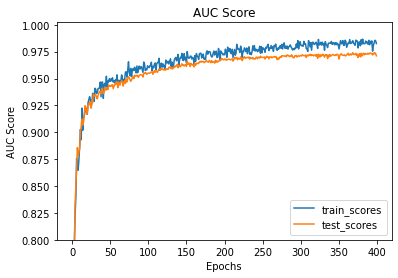

In [41]:
print("weight_decay: ", params_azure['weight_decay'], "epochs: ", params_azure['epochs'], "pos_weight: ", params_azure['pos_weight'])
plot_train_stats(params_azure)

weight_decay:  0.01 epochs:  200 pos_weight:  3


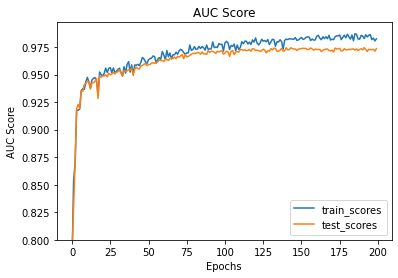

In [38]:
print("weight_decay: ", params_azure['weight_decay'], "epochs: ", params_azure['epochs'], "pos_weight: ", params_azure['pos_weight'])
plot_train_stats(params_azure)

weight_decay:  0.01 epochs:  200 pos_weight:  5.9


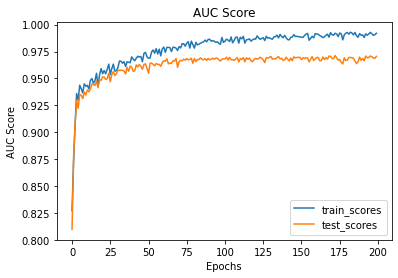

In [35]:
print("weight_decay: ", params_azure['weight_decay'], "epochs: ", params_azure['epochs'], "pos_weight: ", params_azure['pos_weight'])
plot_train_stats(params_azure)

# Deepl tlumaczenie

In [43]:
df_deepl = pd.read_csv(Path(params_deepl['data_dir'], "churn_dataset_deepl.csv"))
X_train, X_test, y_train, y_test = main_transformation(df_deepl, params_deepl['model_dir'], 'dkleczek/bert-base-polish-cased-v1', use_existing=True, test_size=0.33)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Using already prepared data.


((2233, 841), (1100, 841), (2233, 1), (1100, 1))

In [59]:
params_deepl['weight_decay'] = 0.01
params_deepl['epochs'] = 500
params_deepl['pos_weight'] = 5.9

In [60]:
train.train(
    X=X_train,
    y=y_train,
    X_test=X_test,
    y_test=y_test,
    params=params_deepl
)

starting epoch:  1
Train Epoch: 1, train-auc-score: 0.8219


INFO:train:Train Epoch: 1, train-auc-score: 0.8219


test_auc_score: 0.8194


INFO:train:test_auc_score: 0.8194


starting epoch:  2
Train Epoch: 2, train-auc-score: 0.9414


INFO:train:Train Epoch: 2, train-auc-score: 0.9414


test_auc_score: 0.9370


INFO:train:test_auc_score: 0.9370


starting epoch:  3
Train Epoch: 3, train-auc-score: 0.8459


INFO:train:Train Epoch: 3, train-auc-score: 0.8459


test_auc_score: 0.8010


INFO:train:test_auc_score: 0.8010


starting epoch:  4
Train Epoch: 4, train-auc-score: 0.9058


INFO:train:Train Epoch: 4, train-auc-score: 0.9058


test_auc_score: 0.9116


INFO:train:test_auc_score: 0.9116


starting epoch:  5
Train Epoch: 5, train-auc-score: 0.9435


INFO:train:Train Epoch: 5, train-auc-score: 0.9435


test_auc_score: 0.9461


INFO:train:test_auc_score: 0.9461


starting epoch:  6
Train Epoch: 6, train-auc-score: 0.9626


INFO:train:Train Epoch: 6, train-auc-score: 0.9626


test_auc_score: 0.9471


INFO:train:test_auc_score: 0.9471


starting epoch:  7
Train Epoch: 7, train-auc-score: 0.9594


INFO:train:Train Epoch: 7, train-auc-score: 0.9594


test_auc_score: 0.9507


INFO:train:test_auc_score: 0.9507


starting epoch:  8
Train Epoch: 8, train-auc-score: 0.9712


INFO:train:Train Epoch: 8, train-auc-score: 0.9712


test_auc_score: 0.9621


INFO:train:test_auc_score: 0.9621


starting epoch:  9
Train Epoch: 9, train-auc-score: 0.9713


INFO:train:Train Epoch: 9, train-auc-score: 0.9713


test_auc_score: 0.9650


INFO:train:test_auc_score: 0.9650


starting epoch:  10
Train Epoch: 10, train-auc-score: 0.9590


INFO:train:Train Epoch: 10, train-auc-score: 0.9590


test_auc_score: 0.9506


INFO:train:test_auc_score: 0.9506


starting epoch:  11
Train Epoch: 11, train-auc-score: 0.9740


INFO:train:Train Epoch: 11, train-auc-score: 0.9740


test_auc_score: 0.9653


INFO:train:test_auc_score: 0.9653


starting epoch:  12
Train Epoch: 12, train-auc-score: 0.9772


INFO:train:Train Epoch: 12, train-auc-score: 0.9772


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  13
Train Epoch: 13, train-auc-score: 0.9766


INFO:train:Train Epoch: 13, train-auc-score: 0.9766


test_auc_score: 0.9643


INFO:train:test_auc_score: 0.9643


starting epoch:  14
Train Epoch: 14, train-auc-score: 0.9399


INFO:train:Train Epoch: 14, train-auc-score: 0.9399


test_auc_score: 0.9354


INFO:train:test_auc_score: 0.9354


starting epoch:  15
Train Epoch: 15, train-auc-score: 0.9710


INFO:train:Train Epoch: 15, train-auc-score: 0.9710


test_auc_score: 0.9616


INFO:train:test_auc_score: 0.9616


starting epoch:  16
Train Epoch: 16, train-auc-score: 0.9748


INFO:train:Train Epoch: 16, train-auc-score: 0.9748


test_auc_score: 0.9643


INFO:train:test_auc_score: 0.9643


starting epoch:  17
Train Epoch: 17, train-auc-score: 0.9761


INFO:train:Train Epoch: 17, train-auc-score: 0.9761


test_auc_score: 0.9600


INFO:train:test_auc_score: 0.9600


starting epoch:  18
Train Epoch: 18, train-auc-score: 0.9803


INFO:train:Train Epoch: 18, train-auc-score: 0.9803


test_auc_score: 0.9660


INFO:train:test_auc_score: 0.9660


starting epoch:  19
Train Epoch: 19, train-auc-score: 0.9807


INFO:train:Train Epoch: 19, train-auc-score: 0.9807


test_auc_score: 0.9683


INFO:train:test_auc_score: 0.9683


starting epoch:  20
Train Epoch: 20, train-auc-score: 0.9691


INFO:train:Train Epoch: 20, train-auc-score: 0.9691


test_auc_score: 0.9567


INFO:train:test_auc_score: 0.9567


starting epoch:  21
Train Epoch: 21, train-auc-score: 0.9826


INFO:train:Train Epoch: 21, train-auc-score: 0.9826


test_auc_score: 0.9700


INFO:train:test_auc_score: 0.9700


starting epoch:  22
Train Epoch: 22, train-auc-score: 0.9834


INFO:train:Train Epoch: 22, train-auc-score: 0.9834


test_auc_score: 0.9707


INFO:train:test_auc_score: 0.9707


starting epoch:  23
Train Epoch: 23, train-auc-score: 0.9780


INFO:train:Train Epoch: 23, train-auc-score: 0.9780


test_auc_score: 0.9652


INFO:train:test_auc_score: 0.9652


starting epoch:  24
Train Epoch: 24, train-auc-score: 0.9687


INFO:train:Train Epoch: 24, train-auc-score: 0.9687


test_auc_score: 0.9453


INFO:train:test_auc_score: 0.9453


starting epoch:  25
Train Epoch: 25, train-auc-score: 0.9850


INFO:train:Train Epoch: 25, train-auc-score: 0.9850


test_auc_score: 0.9726


INFO:train:test_auc_score: 0.9726


starting epoch:  26
Train Epoch: 26, train-auc-score: 0.9871


INFO:train:Train Epoch: 26, train-auc-score: 0.9871


test_auc_score: 0.9725


INFO:train:test_auc_score: 0.9725


starting epoch:  27
Train Epoch: 27, train-auc-score: 0.9774


INFO:train:Train Epoch: 27, train-auc-score: 0.9774


test_auc_score: 0.9679


INFO:train:test_auc_score: 0.9679


starting epoch:  28
Train Epoch: 28, train-auc-score: 0.9830


INFO:train:Train Epoch: 28, train-auc-score: 0.9830


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  29
Train Epoch: 29, train-auc-score: 0.9828


INFO:train:Train Epoch: 29, train-auc-score: 0.9828


test_auc_score: 0.9702


INFO:train:test_auc_score: 0.9702


starting epoch:  30
Train Epoch: 30, train-auc-score: 0.9863


INFO:train:Train Epoch: 30, train-auc-score: 0.9863


test_auc_score: 0.9687


INFO:train:test_auc_score: 0.9687


starting epoch:  31
Train Epoch: 31, train-auc-score: 0.9895


INFO:train:Train Epoch: 31, train-auc-score: 0.9895


test_auc_score: 0.9696


INFO:train:test_auc_score: 0.9696


starting epoch:  32
Train Epoch: 32, train-auc-score: 0.9851


INFO:train:Train Epoch: 32, train-auc-score: 0.9851


test_auc_score: 0.9708


INFO:train:test_auc_score: 0.9708


starting epoch:  33
Train Epoch: 33, train-auc-score: 0.9894


INFO:train:Train Epoch: 33, train-auc-score: 0.9894


test_auc_score: 0.9684


INFO:train:test_auc_score: 0.9684


starting epoch:  34
Train Epoch: 34, train-auc-score: 0.9878


INFO:train:Train Epoch: 34, train-auc-score: 0.9878


test_auc_score: 0.9716


INFO:train:test_auc_score: 0.9716


starting epoch:  35
Train Epoch: 35, train-auc-score: 0.9876


INFO:train:Train Epoch: 35, train-auc-score: 0.9876


test_auc_score: 0.9709


INFO:train:test_auc_score: 0.9709


starting epoch:  36
Train Epoch: 36, train-auc-score: 0.9881


INFO:train:Train Epoch: 36, train-auc-score: 0.9881


test_auc_score: 0.9726


INFO:train:test_auc_score: 0.9726


starting epoch:  37
Train Epoch: 37, train-auc-score: 0.9780


INFO:train:Train Epoch: 37, train-auc-score: 0.9780


test_auc_score: 0.9551


INFO:train:test_auc_score: 0.9551


starting epoch:  38
Train Epoch: 38, train-auc-score: 0.9877


INFO:train:Train Epoch: 38, train-auc-score: 0.9877


test_auc_score: 0.9696


INFO:train:test_auc_score: 0.9696


starting epoch:  39
Train Epoch: 39, train-auc-score: 0.9784


INFO:train:Train Epoch: 39, train-auc-score: 0.9784


test_auc_score: 0.9599


INFO:train:test_auc_score: 0.9599


starting epoch:  40
Train Epoch: 40, train-auc-score: 0.9900


INFO:train:Train Epoch: 40, train-auc-score: 0.9900


test_auc_score: 0.9704


INFO:train:test_auc_score: 0.9704


starting epoch:  41
Train Epoch: 41, train-auc-score: 0.9896


INFO:train:Train Epoch: 41, train-auc-score: 0.9896


test_auc_score: 0.9730


INFO:train:test_auc_score: 0.9730


starting epoch:  42
Train Epoch: 42, train-auc-score: 0.9853


INFO:train:Train Epoch: 42, train-auc-score: 0.9853


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  43
Train Epoch: 43, train-auc-score: 0.9883


INFO:train:Train Epoch: 43, train-auc-score: 0.9883


test_auc_score: 0.9682


INFO:train:test_auc_score: 0.9682


starting epoch:  44
Train Epoch: 44, train-auc-score: 0.9817


INFO:train:Train Epoch: 44, train-auc-score: 0.9817


test_auc_score: 0.9621


INFO:train:test_auc_score: 0.9621


starting epoch:  45
Train Epoch: 45, train-auc-score: 0.9891


INFO:train:Train Epoch: 45, train-auc-score: 0.9891


test_auc_score: 0.9702


INFO:train:test_auc_score: 0.9702


starting epoch:  46
Train Epoch: 46, train-auc-score: 0.9910


INFO:train:Train Epoch: 46, train-auc-score: 0.9910


test_auc_score: 0.9732


INFO:train:test_auc_score: 0.9732


starting epoch:  47
Train Epoch: 47, train-auc-score: 0.9894


INFO:train:Train Epoch: 47, train-auc-score: 0.9894


test_auc_score: 0.9725


INFO:train:test_auc_score: 0.9725


starting epoch:  48
Train Epoch: 48, train-auc-score: 0.9900


INFO:train:Train Epoch: 48, train-auc-score: 0.9900


test_auc_score: 0.9731


INFO:train:test_auc_score: 0.9731


starting epoch:  49
Train Epoch: 49, train-auc-score: 0.9901


INFO:train:Train Epoch: 49, train-auc-score: 0.9901


test_auc_score: 0.9724


INFO:train:test_auc_score: 0.9724


starting epoch:  50
Train Epoch: 50, train-auc-score: 0.9903


INFO:train:Train Epoch: 50, train-auc-score: 0.9903


test_auc_score: 0.9734


INFO:train:test_auc_score: 0.9734


starting epoch:  51
Train Epoch: 51, train-auc-score: 0.9845


INFO:train:Train Epoch: 51, train-auc-score: 0.9845


test_auc_score: 0.9712


INFO:train:test_auc_score: 0.9712


starting epoch:  52
Train Epoch: 52, train-auc-score: 0.9881


INFO:train:Train Epoch: 52, train-auc-score: 0.9881


test_auc_score: 0.9728


INFO:train:test_auc_score: 0.9728


starting epoch:  53
Train Epoch: 53, train-auc-score: 0.9887


INFO:train:Train Epoch: 53, train-auc-score: 0.9887


test_auc_score: 0.9700


INFO:train:test_auc_score: 0.9700


starting epoch:  54
Train Epoch: 54, train-auc-score: 0.9891


INFO:train:Train Epoch: 54, train-auc-score: 0.9891


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  55
Train Epoch: 55, train-auc-score: 0.9858


INFO:train:Train Epoch: 55, train-auc-score: 0.9858


test_auc_score: 0.9685


INFO:train:test_auc_score: 0.9685


starting epoch:  56
Train Epoch: 56, train-auc-score: 0.9894


INFO:train:Train Epoch: 56, train-auc-score: 0.9894


test_auc_score: 0.9678


INFO:train:test_auc_score: 0.9678


starting epoch:  57
Train Epoch: 57, train-auc-score: 0.9903


INFO:train:Train Epoch: 57, train-auc-score: 0.9903


test_auc_score: 0.9731


INFO:train:test_auc_score: 0.9731


starting epoch:  58
Train Epoch: 58, train-auc-score: 0.9893


INFO:train:Train Epoch: 58, train-auc-score: 0.9893


test_auc_score: 0.9735


INFO:train:test_auc_score: 0.9735


starting epoch:  59
Train Epoch: 59, train-auc-score: 0.9863


INFO:train:Train Epoch: 59, train-auc-score: 0.9863


test_auc_score: 0.9669


INFO:train:test_auc_score: 0.9669


starting epoch:  60
Train Epoch: 60, train-auc-score: 0.9843


INFO:train:Train Epoch: 60, train-auc-score: 0.9843


test_auc_score: 0.9619


INFO:train:test_auc_score: 0.9619


starting epoch:  61
Train Epoch: 61, train-auc-score: 0.9877


INFO:train:Train Epoch: 61, train-auc-score: 0.9877


test_auc_score: 0.9661


INFO:train:test_auc_score: 0.9661


starting epoch:  62
Train Epoch: 62, train-auc-score: 0.9907


INFO:train:Train Epoch: 62, train-auc-score: 0.9907


test_auc_score: 0.9725


INFO:train:test_auc_score: 0.9725


starting epoch:  63
Train Epoch: 63, train-auc-score: 0.9894


INFO:train:Train Epoch: 63, train-auc-score: 0.9894


test_auc_score: 0.9716


INFO:train:test_auc_score: 0.9716


starting epoch:  64
Train Epoch: 64, train-auc-score: 0.9881


INFO:train:Train Epoch: 64, train-auc-score: 0.9881


test_auc_score: 0.9689


INFO:train:test_auc_score: 0.9689


starting epoch:  65
Train Epoch: 65, train-auc-score: 0.9912


INFO:train:Train Epoch: 65, train-auc-score: 0.9912


test_auc_score: 0.9714


INFO:train:test_auc_score: 0.9714


starting epoch:  66
Train Epoch: 66, train-auc-score: 0.9878


INFO:train:Train Epoch: 66, train-auc-score: 0.9878


test_auc_score: 0.9726


INFO:train:test_auc_score: 0.9726


starting epoch:  67
Train Epoch: 67, train-auc-score: 0.9907


INFO:train:Train Epoch: 67, train-auc-score: 0.9907


test_auc_score: 0.9729


INFO:train:test_auc_score: 0.9729


starting epoch:  68
Train Epoch: 68, train-auc-score: 0.9912


INFO:train:Train Epoch: 68, train-auc-score: 0.9912


test_auc_score: 0.9739


INFO:train:test_auc_score: 0.9739


starting epoch:  69
Train Epoch: 69, train-auc-score: 0.9876


INFO:train:Train Epoch: 69, train-auc-score: 0.9876


test_auc_score: 0.9728


INFO:train:test_auc_score: 0.9728


starting epoch:  70
Train Epoch: 70, train-auc-score: 0.9873


INFO:train:Train Epoch: 70, train-auc-score: 0.9873


test_auc_score: 0.9692


INFO:train:test_auc_score: 0.9692


starting epoch:  71
Train Epoch: 71, train-auc-score: 0.9900


INFO:train:Train Epoch: 71, train-auc-score: 0.9900


test_auc_score: 0.9706


INFO:train:test_auc_score: 0.9706


starting epoch:  72
Train Epoch: 72, train-auc-score: 0.9882


INFO:train:Train Epoch: 72, train-auc-score: 0.9882


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  73
Train Epoch: 73, train-auc-score: 0.9865


INFO:train:Train Epoch: 73, train-auc-score: 0.9865


test_auc_score: 0.9671


INFO:train:test_auc_score: 0.9671


starting epoch:  74
Train Epoch: 74, train-auc-score: 0.9916


INFO:train:Train Epoch: 74, train-auc-score: 0.9916


test_auc_score: 0.9728


INFO:train:test_auc_score: 0.9728


starting epoch:  75
Train Epoch: 75, train-auc-score: 0.9908


INFO:train:Train Epoch: 75, train-auc-score: 0.9908


test_auc_score: 0.9727


INFO:train:test_auc_score: 0.9727


starting epoch:  76
Train Epoch: 76, train-auc-score: 0.9730


INFO:train:Train Epoch: 76, train-auc-score: 0.9730


test_auc_score: 0.9538


INFO:train:test_auc_score: 0.9538


starting epoch:  77
Train Epoch: 77, train-auc-score: 0.9795


INFO:train:Train Epoch: 77, train-auc-score: 0.9795


test_auc_score: 0.9614


INFO:train:test_auc_score: 0.9614


starting epoch:  78
Train Epoch: 78, train-auc-score: 0.9880


INFO:train:Train Epoch: 78, train-auc-score: 0.9880


test_auc_score: 0.9723


INFO:train:test_auc_score: 0.9723


starting epoch:  79
Train Epoch: 79, train-auc-score: 0.9876


INFO:train:Train Epoch: 79, train-auc-score: 0.9876


test_auc_score: 0.9722


INFO:train:test_auc_score: 0.9722


starting epoch:  80
Train Epoch: 80, train-auc-score: 0.9860


INFO:train:Train Epoch: 80, train-auc-score: 0.9860


test_auc_score: 0.9695


INFO:train:test_auc_score: 0.9695


starting epoch:  81
Train Epoch: 81, train-auc-score: 0.9915


INFO:train:Train Epoch: 81, train-auc-score: 0.9915


test_auc_score: 0.9714


INFO:train:test_auc_score: 0.9714


starting epoch:  82
Train Epoch: 82, train-auc-score: 0.9690


INFO:train:Train Epoch: 82, train-auc-score: 0.9690


test_auc_score: 0.9507


INFO:train:test_auc_score: 0.9507


starting epoch:  83
Train Epoch: 83, train-auc-score: 0.9897


INFO:train:Train Epoch: 83, train-auc-score: 0.9897


test_auc_score: 0.9695


INFO:train:test_auc_score: 0.9695


starting epoch:  84
Train Epoch: 84, train-auc-score: 0.9619


INFO:train:Train Epoch: 84, train-auc-score: 0.9619


test_auc_score: 0.9432


INFO:train:test_auc_score: 0.9432


starting epoch:  85
Train Epoch: 85, train-auc-score: 0.9886


INFO:train:Train Epoch: 85, train-auc-score: 0.9886


test_auc_score: 0.9728


INFO:train:test_auc_score: 0.9728


starting epoch:  86
Train Epoch: 86, train-auc-score: 0.9873


INFO:train:Train Epoch: 86, train-auc-score: 0.9873


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  87
Train Epoch: 87, train-auc-score: 0.9877


INFO:train:Train Epoch: 87, train-auc-score: 0.9877


test_auc_score: 0.9717


INFO:train:test_auc_score: 0.9717


starting epoch:  88
Train Epoch: 88, train-auc-score: 0.9852


INFO:train:Train Epoch: 88, train-auc-score: 0.9852


test_auc_score: 0.9703


INFO:train:test_auc_score: 0.9703


starting epoch:  89
Train Epoch: 89, train-auc-score: 0.9859


INFO:train:Train Epoch: 89, train-auc-score: 0.9859


test_auc_score: 0.9729


INFO:train:test_auc_score: 0.9729


starting epoch:  90
Train Epoch: 90, train-auc-score: 0.9720


INFO:train:Train Epoch: 90, train-auc-score: 0.9720


test_auc_score: 0.9474


INFO:train:test_auc_score: 0.9474


starting epoch:  91
Train Epoch: 91, train-auc-score: 0.9888


INFO:train:Train Epoch: 91, train-auc-score: 0.9888


test_auc_score: 0.9721


INFO:train:test_auc_score: 0.9721


starting epoch:  92
Train Epoch: 92, train-auc-score: 0.9849


INFO:train:Train Epoch: 92, train-auc-score: 0.9849


test_auc_score: 0.9684


INFO:train:test_auc_score: 0.9684


starting epoch:  93
Train Epoch: 93, train-auc-score: 0.9861


INFO:train:Train Epoch: 93, train-auc-score: 0.9861


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  94
Train Epoch: 94, train-auc-score: 0.9899


INFO:train:Train Epoch: 94, train-auc-score: 0.9899


test_auc_score: 0.9712


INFO:train:test_auc_score: 0.9712


starting epoch:  95
Train Epoch: 95, train-auc-score: 0.9858


INFO:train:Train Epoch: 95, train-auc-score: 0.9858


test_auc_score: 0.9703


INFO:train:test_auc_score: 0.9703


starting epoch:  96
Train Epoch: 96, train-auc-score: 0.9890


INFO:train:Train Epoch: 96, train-auc-score: 0.9890


test_auc_score: 0.9744


INFO:train:test_auc_score: 0.9744


starting epoch:  97
Train Epoch: 97, train-auc-score: 0.9771


INFO:train:Train Epoch: 97, train-auc-score: 0.9771


test_auc_score: 0.9583


INFO:train:test_auc_score: 0.9583


starting epoch:  98
Train Epoch: 98, train-auc-score: 0.9828


INFO:train:Train Epoch: 98, train-auc-score: 0.9828


test_auc_score: 0.9670


INFO:train:test_auc_score: 0.9670


starting epoch:  99
Train Epoch: 99, train-auc-score: 0.9894


INFO:train:Train Epoch: 99, train-auc-score: 0.9894


test_auc_score: 0.9746


INFO:train:test_auc_score: 0.9746


starting epoch:  100
Train Epoch: 100, train-auc-score: 0.9865


INFO:train:Train Epoch: 100, train-auc-score: 0.9865


test_auc_score: 0.9709


INFO:train:test_auc_score: 0.9709


starting epoch:  101
Train Epoch: 101, train-auc-score: 0.9876


INFO:train:Train Epoch: 101, train-auc-score: 0.9876


test_auc_score: 0.9738


INFO:train:test_auc_score: 0.9738


starting epoch:  102
Train Epoch: 102, train-auc-score: 0.9879


INFO:train:Train Epoch: 102, train-auc-score: 0.9879


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  103
Train Epoch: 103, train-auc-score: 0.9857


INFO:train:Train Epoch: 103, train-auc-score: 0.9857


test_auc_score: 0.9684


INFO:train:test_auc_score: 0.9684


starting epoch:  104
Train Epoch: 104, train-auc-score: 0.9876


INFO:train:Train Epoch: 104, train-auc-score: 0.9876


test_auc_score: 0.9721


INFO:train:test_auc_score: 0.9721


starting epoch:  105
Train Epoch: 105, train-auc-score: 0.9820


INFO:train:Train Epoch: 105, train-auc-score: 0.9820


test_auc_score: 0.9656


INFO:train:test_auc_score: 0.9656


starting epoch:  106
Train Epoch: 106, train-auc-score: 0.9754


INFO:train:Train Epoch: 106, train-auc-score: 0.9754


test_auc_score: 0.9601


INFO:train:test_auc_score: 0.9601


starting epoch:  107
Train Epoch: 107, train-auc-score: 0.9879


INFO:train:Train Epoch: 107, train-auc-score: 0.9879


test_auc_score: 0.9735


INFO:train:test_auc_score: 0.9735


starting epoch:  108
Train Epoch: 108, train-auc-score: 0.9918


INFO:train:Train Epoch: 108, train-auc-score: 0.9918


test_auc_score: 0.9725


INFO:train:test_auc_score: 0.9725


starting epoch:  109
Train Epoch: 109, train-auc-score: 0.9886


INFO:train:Train Epoch: 109, train-auc-score: 0.9886


test_auc_score: 0.9737


INFO:train:test_auc_score: 0.9737


starting epoch:  110
Train Epoch: 110, train-auc-score: 0.9881


INFO:train:Train Epoch: 110, train-auc-score: 0.9881


test_auc_score: 0.9694


INFO:train:test_auc_score: 0.9694


starting epoch:  111
Train Epoch: 111, train-auc-score: 0.9826


INFO:train:Train Epoch: 111, train-auc-score: 0.9826


test_auc_score: 0.9652


INFO:train:test_auc_score: 0.9652


starting epoch:  112
Train Epoch: 112, train-auc-score: 0.9887


INFO:train:Train Epoch: 112, train-auc-score: 0.9887


test_auc_score: 0.9732


INFO:train:test_auc_score: 0.9732


starting epoch:  113
Train Epoch: 113, train-auc-score: 0.9898


INFO:train:Train Epoch: 113, train-auc-score: 0.9898


test_auc_score: 0.9719


INFO:train:test_auc_score: 0.9719


starting epoch:  114
Train Epoch: 114, train-auc-score: 0.9902


INFO:train:Train Epoch: 114, train-auc-score: 0.9902


test_auc_score: 0.9739


INFO:train:test_auc_score: 0.9739


starting epoch:  115
Train Epoch: 115, train-auc-score: 0.9826


INFO:train:Train Epoch: 115, train-auc-score: 0.9826


test_auc_score: 0.9645


INFO:train:test_auc_score: 0.9645


starting epoch:  116
Train Epoch: 116, train-auc-score: 0.9547


INFO:train:Train Epoch: 116, train-auc-score: 0.9547


test_auc_score: 0.9389


INFO:train:test_auc_score: 0.9389


starting epoch:  117
Train Epoch: 117, train-auc-score: 0.9844


INFO:train:Train Epoch: 117, train-auc-score: 0.9844


test_auc_score: 0.9647


INFO:train:test_auc_score: 0.9647


starting epoch:  118
Train Epoch: 118, train-auc-score: 0.9857


INFO:train:Train Epoch: 118, train-auc-score: 0.9857


test_auc_score: 0.9705


INFO:train:test_auc_score: 0.9705


starting epoch:  119
Train Epoch: 119, train-auc-score: 0.9891


INFO:train:Train Epoch: 119, train-auc-score: 0.9891


test_auc_score: 0.9725


INFO:train:test_auc_score: 0.9725


starting epoch:  120
Train Epoch: 120, train-auc-score: 0.9899


INFO:train:Train Epoch: 120, train-auc-score: 0.9899


test_auc_score: 0.9704


INFO:train:test_auc_score: 0.9704


starting epoch:  121
Train Epoch: 121, train-auc-score: 0.9839


INFO:train:Train Epoch: 121, train-auc-score: 0.9839


test_auc_score: 0.9689


INFO:train:test_auc_score: 0.9689


starting epoch:  122
Train Epoch: 122, train-auc-score: 0.9867


INFO:train:Train Epoch: 122, train-auc-score: 0.9867


test_auc_score: 0.9719


INFO:train:test_auc_score: 0.9719


starting epoch:  123
Train Epoch: 123, train-auc-score: 0.9832


INFO:train:Train Epoch: 123, train-auc-score: 0.9832


test_auc_score: 0.9653


INFO:train:test_auc_score: 0.9653


starting epoch:  124
Train Epoch: 124, train-auc-score: 0.9891


INFO:train:Train Epoch: 124, train-auc-score: 0.9891


test_auc_score: 0.9756


INFO:train:test_auc_score: 0.9756


starting epoch:  125
Train Epoch: 125, train-auc-score: 0.9805


INFO:train:Train Epoch: 125, train-auc-score: 0.9805


test_auc_score: 0.9652


INFO:train:test_auc_score: 0.9652


starting epoch:  126
Train Epoch: 126, train-auc-score: 0.9876


INFO:train:Train Epoch: 126, train-auc-score: 0.9876


test_auc_score: 0.9722


INFO:train:test_auc_score: 0.9722


starting epoch:  127
Train Epoch: 127, train-auc-score: 0.9778


INFO:train:Train Epoch: 127, train-auc-score: 0.9778


test_auc_score: 0.9655


INFO:train:test_auc_score: 0.9655


starting epoch:  128
Train Epoch: 128, train-auc-score: 0.9881


INFO:train:Train Epoch: 128, train-auc-score: 0.9881


test_auc_score: 0.9717


INFO:train:test_auc_score: 0.9717


starting epoch:  129
Train Epoch: 129, train-auc-score: 0.9893


INFO:train:Train Epoch: 129, train-auc-score: 0.9893


test_auc_score: 0.9736


INFO:train:test_auc_score: 0.9736


starting epoch:  130
Train Epoch: 130, train-auc-score: 0.9891


INFO:train:Train Epoch: 130, train-auc-score: 0.9891


test_auc_score: 0.9683


INFO:train:test_auc_score: 0.9683


starting epoch:  131
Train Epoch: 131, train-auc-score: 0.9868


INFO:train:Train Epoch: 131, train-auc-score: 0.9868


test_auc_score: 0.9753


INFO:train:test_auc_score: 0.9753


starting epoch:  132
Train Epoch: 132, train-auc-score: 0.9872


INFO:train:Train Epoch: 132, train-auc-score: 0.9872


test_auc_score: 0.9713


INFO:train:test_auc_score: 0.9713


starting epoch:  133
Train Epoch: 133, train-auc-score: 0.9890


INFO:train:Train Epoch: 133, train-auc-score: 0.9890


test_auc_score: 0.9751


INFO:train:test_auc_score: 0.9751


starting epoch:  134
Train Epoch: 134, train-auc-score: 0.9902


INFO:train:Train Epoch: 134, train-auc-score: 0.9902


test_auc_score: 0.9716


INFO:train:test_auc_score: 0.9716


starting epoch:  135
Train Epoch: 135, train-auc-score: 0.9855


INFO:train:Train Epoch: 135, train-auc-score: 0.9855


test_auc_score: 0.9696


INFO:train:test_auc_score: 0.9696


starting epoch:  136
Train Epoch: 136, train-auc-score: 0.9618


INFO:train:Train Epoch: 136, train-auc-score: 0.9618


test_auc_score: 0.9320


INFO:train:test_auc_score: 0.9320


starting epoch:  137
Train Epoch: 137, train-auc-score: 0.9891


INFO:train:Train Epoch: 137, train-auc-score: 0.9891


test_auc_score: 0.9705


INFO:train:test_auc_score: 0.9705


starting epoch:  138
Train Epoch: 138, train-auc-score: 0.9886


INFO:train:Train Epoch: 138, train-auc-score: 0.9886


test_auc_score: 0.9739


INFO:train:test_auc_score: 0.9739


starting epoch:  139
Train Epoch: 139, train-auc-score: 0.9807


INFO:train:Train Epoch: 139, train-auc-score: 0.9807


test_auc_score: 0.9691


INFO:train:test_auc_score: 0.9691


starting epoch:  140
Train Epoch: 140, train-auc-score: 0.9673


INFO:train:Train Epoch: 140, train-auc-score: 0.9673


test_auc_score: 0.9543


INFO:train:test_auc_score: 0.9543


starting epoch:  141
Train Epoch: 141, train-auc-score: 0.9897


INFO:train:Train Epoch: 141, train-auc-score: 0.9897


test_auc_score: 0.9738


INFO:train:test_auc_score: 0.9738


starting epoch:  142
Train Epoch: 142, train-auc-score: 0.9853


INFO:train:Train Epoch: 142, train-auc-score: 0.9853


test_auc_score: 0.9760


INFO:train:test_auc_score: 0.9760


starting epoch:  143
Train Epoch: 143, train-auc-score: 0.9847


INFO:train:Train Epoch: 143, train-auc-score: 0.9847


test_auc_score: 0.9712


INFO:train:test_auc_score: 0.9712


starting epoch:  144
Train Epoch: 144, train-auc-score: 0.9827


INFO:train:Train Epoch: 144, train-auc-score: 0.9827


test_auc_score: 0.9659


INFO:train:test_auc_score: 0.9659


starting epoch:  145
Train Epoch: 145, train-auc-score: 0.9878


INFO:train:Train Epoch: 145, train-auc-score: 0.9878


test_auc_score: 0.9755


INFO:train:test_auc_score: 0.9755


starting epoch:  146
Train Epoch: 146, train-auc-score: 0.9894


INFO:train:Train Epoch: 146, train-auc-score: 0.9894


test_auc_score: 0.9720


INFO:train:test_auc_score: 0.9720


starting epoch:  147
Train Epoch: 147, train-auc-score: 0.9864


INFO:train:Train Epoch: 147, train-auc-score: 0.9864


test_auc_score: 0.9692


INFO:train:test_auc_score: 0.9692


starting epoch:  148
Train Epoch: 148, train-auc-score: 0.9841


INFO:train:Train Epoch: 148, train-auc-score: 0.9841


test_auc_score: 0.9686


INFO:train:test_auc_score: 0.9686


starting epoch:  149
Train Epoch: 149, train-auc-score: 0.9781


INFO:train:Train Epoch: 149, train-auc-score: 0.9781


test_auc_score: 0.9616


INFO:train:test_auc_score: 0.9616


starting epoch:  150
Train Epoch: 150, train-auc-score: 0.9859


INFO:train:Train Epoch: 150, train-auc-score: 0.9859


test_auc_score: 0.9725


INFO:train:test_auc_score: 0.9725


starting epoch:  151
Train Epoch: 151, train-auc-score: 0.9872


INFO:train:Train Epoch: 151, train-auc-score: 0.9872


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  152
Train Epoch: 152, train-auc-score: 0.9846


INFO:train:Train Epoch: 152, train-auc-score: 0.9846


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  153
Train Epoch: 153, train-auc-score: 0.9847


INFO:train:Train Epoch: 153, train-auc-score: 0.9847


test_auc_score: 0.9727


INFO:train:test_auc_score: 0.9727


starting epoch:  154
Train Epoch: 154, train-auc-score: 0.9862


INFO:train:Train Epoch: 154, train-auc-score: 0.9862


test_auc_score: 0.9715


INFO:train:test_auc_score: 0.9715


starting epoch:  155
Train Epoch: 155, train-auc-score: 0.9878


INFO:train:Train Epoch: 155, train-auc-score: 0.9878


test_auc_score: 0.9695


INFO:train:test_auc_score: 0.9695


starting epoch:  156
Train Epoch: 156, train-auc-score: 0.9672


INFO:train:Train Epoch: 156, train-auc-score: 0.9672


test_auc_score: 0.9411


INFO:train:test_auc_score: 0.9411


starting epoch:  157
Train Epoch: 157, train-auc-score: 0.9884


INFO:train:Train Epoch: 157, train-auc-score: 0.9884


test_auc_score: 0.9753


INFO:train:test_auc_score: 0.9753


starting epoch:  158
Train Epoch: 158, train-auc-score: 0.9886


INFO:train:Train Epoch: 158, train-auc-score: 0.9886


test_auc_score: 0.9725


INFO:train:test_auc_score: 0.9725


starting epoch:  159
Train Epoch: 159, train-auc-score: 0.9890


INFO:train:Train Epoch: 159, train-auc-score: 0.9890


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  160
Train Epoch: 160, train-auc-score: 0.9886


INFO:train:Train Epoch: 160, train-auc-score: 0.9886


test_auc_score: 0.9731


INFO:train:test_auc_score: 0.9731


starting epoch:  161
Train Epoch: 161, train-auc-score: 0.9899


INFO:train:Train Epoch: 161, train-auc-score: 0.9899


test_auc_score: 0.9709


INFO:train:test_auc_score: 0.9709


starting epoch:  162
Train Epoch: 162, train-auc-score: 0.9868


INFO:train:Train Epoch: 162, train-auc-score: 0.9868


test_auc_score: 0.9739


INFO:train:test_auc_score: 0.9739


starting epoch:  163
Train Epoch: 163, train-auc-score: 0.9881


INFO:train:Train Epoch: 163, train-auc-score: 0.9881


test_auc_score: 0.9748


INFO:train:test_auc_score: 0.9748


starting epoch:  164
Train Epoch: 164, train-auc-score: 0.9873


INFO:train:Train Epoch: 164, train-auc-score: 0.9873


test_auc_score: 0.9644


INFO:train:test_auc_score: 0.9644


starting epoch:  165
Train Epoch: 165, train-auc-score: 0.9792


INFO:train:Train Epoch: 165, train-auc-score: 0.9792


test_auc_score: 0.9643


INFO:train:test_auc_score: 0.9643


starting epoch:  166
Train Epoch: 166, train-auc-score: 0.9880


INFO:train:Train Epoch: 166, train-auc-score: 0.9880


test_auc_score: 0.9732


INFO:train:test_auc_score: 0.9732


starting epoch:  167
Train Epoch: 167, train-auc-score: 0.9717


INFO:train:Train Epoch: 167, train-auc-score: 0.9717


test_auc_score: 0.9421


INFO:train:test_auc_score: 0.9421


starting epoch:  168
Train Epoch: 168, train-auc-score: 0.9869


INFO:train:Train Epoch: 168, train-auc-score: 0.9869


test_auc_score: 0.9718


INFO:train:test_auc_score: 0.9718


starting epoch:  169
Train Epoch: 169, train-auc-score: 0.9915


INFO:train:Train Epoch: 169, train-auc-score: 0.9915


test_auc_score: 0.9760


INFO:train:test_auc_score: 0.9760


starting epoch:  170
Train Epoch: 170, train-auc-score: 0.9886


INFO:train:Train Epoch: 170, train-auc-score: 0.9886


test_auc_score: 0.9756


INFO:train:test_auc_score: 0.9756


starting epoch:  171
Train Epoch: 171, train-auc-score: 0.9828


INFO:train:Train Epoch: 171, train-auc-score: 0.9828


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  172
Train Epoch: 172, train-auc-score: 0.9901


INFO:train:Train Epoch: 172, train-auc-score: 0.9901


test_auc_score: 0.9757


INFO:train:test_auc_score: 0.9757


starting epoch:  173
Train Epoch: 173, train-auc-score: 0.9886


INFO:train:Train Epoch: 173, train-auc-score: 0.9886


test_auc_score: 0.9744


INFO:train:test_auc_score: 0.9744


starting epoch:  174
Train Epoch: 174, train-auc-score: 0.9846


INFO:train:Train Epoch: 174, train-auc-score: 0.9846


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  175
Train Epoch: 175, train-auc-score: 0.9907


INFO:train:Train Epoch: 175, train-auc-score: 0.9907


test_auc_score: 0.9743


INFO:train:test_auc_score: 0.9743


starting epoch:  176
Train Epoch: 176, train-auc-score: 0.9880


INFO:train:Train Epoch: 176, train-auc-score: 0.9880


test_auc_score: 0.9741


INFO:train:test_auc_score: 0.9741


starting epoch:  177
Train Epoch: 177, train-auc-score: 0.9780


INFO:train:Train Epoch: 177, train-auc-score: 0.9780


test_auc_score: 0.9661


INFO:train:test_auc_score: 0.9661


starting epoch:  178
Train Epoch: 178, train-auc-score: 0.9710


INFO:train:Train Epoch: 178, train-auc-score: 0.9710


test_auc_score: 0.9462


INFO:train:test_auc_score: 0.9462


starting epoch:  179
Train Epoch: 179, train-auc-score: 0.9372


INFO:train:Train Epoch: 179, train-auc-score: 0.9372


test_auc_score: 0.9266


INFO:train:test_auc_score: 0.9266


starting epoch:  180
Train Epoch: 180, train-auc-score: 0.9883


INFO:train:Train Epoch: 180, train-auc-score: 0.9883


test_auc_score: 0.9739


INFO:train:test_auc_score: 0.9739


starting epoch:  181
Train Epoch: 181, train-auc-score: 0.9862


INFO:train:Train Epoch: 181, train-auc-score: 0.9862


test_auc_score: 0.9724


INFO:train:test_auc_score: 0.9724


starting epoch:  182
Train Epoch: 182, train-auc-score: 0.9844


INFO:train:Train Epoch: 182, train-auc-score: 0.9844


test_auc_score: 0.9693


INFO:train:test_auc_score: 0.9693


starting epoch:  183
Train Epoch: 183, train-auc-score: 0.9889


INFO:train:Train Epoch: 183, train-auc-score: 0.9889


test_auc_score: 0.9750


INFO:train:test_auc_score: 0.9750


starting epoch:  184
Train Epoch: 184, train-auc-score: 0.9859


INFO:train:Train Epoch: 184, train-auc-score: 0.9859


test_auc_score: 0.9757


INFO:train:test_auc_score: 0.9757


starting epoch:  185
Train Epoch: 185, train-auc-score: 0.9900


INFO:train:Train Epoch: 185, train-auc-score: 0.9900


test_auc_score: 0.9757


INFO:train:test_auc_score: 0.9757


starting epoch:  186
Train Epoch: 186, train-auc-score: 0.9843


INFO:train:Train Epoch: 186, train-auc-score: 0.9843


test_auc_score: 0.9649


INFO:train:test_auc_score: 0.9649


starting epoch:  187
Train Epoch: 187, train-auc-score: 0.9847


INFO:train:Train Epoch: 187, train-auc-score: 0.9847


test_auc_score: 0.9677


INFO:train:test_auc_score: 0.9677


starting epoch:  188
Train Epoch: 188, train-auc-score: 0.9872


INFO:train:Train Epoch: 188, train-auc-score: 0.9872


test_auc_score: 0.9755


INFO:train:test_auc_score: 0.9755


starting epoch:  189
Train Epoch: 189, train-auc-score: 0.9859


INFO:train:Train Epoch: 189, train-auc-score: 0.9859


test_auc_score: 0.9740


INFO:train:test_auc_score: 0.9740


starting epoch:  190
Train Epoch: 190, train-auc-score: 0.9671


INFO:train:Train Epoch: 190, train-auc-score: 0.9671


test_auc_score: 0.9537


INFO:train:test_auc_score: 0.9537


starting epoch:  191
Train Epoch: 191, train-auc-score: 0.9733


INFO:train:Train Epoch: 191, train-auc-score: 0.9733


test_auc_score: 0.9642


INFO:train:test_auc_score: 0.9642


starting epoch:  192
Train Epoch: 192, train-auc-score: 0.9768


INFO:train:Train Epoch: 192, train-auc-score: 0.9768


test_auc_score: 0.9560


INFO:train:test_auc_score: 0.9560


starting epoch:  193
Train Epoch: 193, train-auc-score: 0.9878


INFO:train:Train Epoch: 193, train-auc-score: 0.9878


test_auc_score: 0.9739


INFO:train:test_auc_score: 0.9739


starting epoch:  194
Train Epoch: 194, train-auc-score: 0.9889


INFO:train:Train Epoch: 194, train-auc-score: 0.9889


test_auc_score: 0.9727


INFO:train:test_auc_score: 0.9727


starting epoch:  195
Train Epoch: 195, train-auc-score: 0.9870


INFO:train:Train Epoch: 195, train-auc-score: 0.9870


test_auc_score: 0.9741


INFO:train:test_auc_score: 0.9741


starting epoch:  196
Train Epoch: 196, train-auc-score: 0.9874


INFO:train:Train Epoch: 196, train-auc-score: 0.9874


test_auc_score: 0.9736


INFO:train:test_auc_score: 0.9736


starting epoch:  197
Train Epoch: 197, train-auc-score: 0.9788


INFO:train:Train Epoch: 197, train-auc-score: 0.9788


test_auc_score: 0.9624


INFO:train:test_auc_score: 0.9624


starting epoch:  198
Train Epoch: 198, train-auc-score: 0.9884


INFO:train:Train Epoch: 198, train-auc-score: 0.9884


test_auc_score: 0.9761


INFO:train:test_auc_score: 0.9761


starting epoch:  199
Train Epoch: 199, train-auc-score: 0.9912


INFO:train:Train Epoch: 199, train-auc-score: 0.9912


test_auc_score: 0.9752


INFO:train:test_auc_score: 0.9752


starting epoch:  200
Train Epoch: 200, train-auc-score: 0.9891


INFO:train:Train Epoch: 200, train-auc-score: 0.9891


test_auc_score: 0.9746


INFO:train:test_auc_score: 0.9746


starting epoch:  201
Train Epoch: 201, train-auc-score: 0.9906


INFO:train:Train Epoch: 201, train-auc-score: 0.9906


test_auc_score: 0.9761


INFO:train:test_auc_score: 0.9761


starting epoch:  202
Train Epoch: 202, train-auc-score: 0.9328


INFO:train:Train Epoch: 202, train-auc-score: 0.9328


test_auc_score: 0.9215


INFO:train:test_auc_score: 0.9215


starting epoch:  203
Train Epoch: 203, train-auc-score: 0.9881


INFO:train:Train Epoch: 203, train-auc-score: 0.9881


test_auc_score: 0.9752


INFO:train:test_auc_score: 0.9752


starting epoch:  204
Train Epoch: 204, train-auc-score: 0.9806


INFO:train:Train Epoch: 204, train-auc-score: 0.9806


test_auc_score: 0.9674


INFO:train:test_auc_score: 0.9674


starting epoch:  205
Train Epoch: 205, train-auc-score: 0.9889


INFO:train:Train Epoch: 205, train-auc-score: 0.9889


test_auc_score: 0.9771


INFO:train:test_auc_score: 0.9771


starting epoch:  206
Train Epoch: 206, train-auc-score: 0.9883


INFO:train:Train Epoch: 206, train-auc-score: 0.9883


test_auc_score: 0.9757


INFO:train:test_auc_score: 0.9757


starting epoch:  207
Train Epoch: 207, train-auc-score: 0.9711


INFO:train:Train Epoch: 207, train-auc-score: 0.9711


test_auc_score: 0.9515


INFO:train:test_auc_score: 0.9515


starting epoch:  208
Train Epoch: 208, train-auc-score: 0.9777


INFO:train:Train Epoch: 208, train-auc-score: 0.9777


test_auc_score: 0.9613


INFO:train:test_auc_score: 0.9613


starting epoch:  209
Train Epoch: 209, train-auc-score: 0.9896


INFO:train:Train Epoch: 209, train-auc-score: 0.9896


test_auc_score: 0.9762


INFO:train:test_auc_score: 0.9762


starting epoch:  210
Train Epoch: 210, train-auc-score: 0.9881


INFO:train:Train Epoch: 210, train-auc-score: 0.9881


test_auc_score: 0.9766


INFO:train:test_auc_score: 0.9766


starting epoch:  211
Train Epoch: 211, train-auc-score: 0.9872


INFO:train:Train Epoch: 211, train-auc-score: 0.9872


test_auc_score: 0.9762


INFO:train:test_auc_score: 0.9762


starting epoch:  212
Train Epoch: 212, train-auc-score: 0.9881


INFO:train:Train Epoch: 212, train-auc-score: 0.9881


test_auc_score: 0.9750


INFO:train:test_auc_score: 0.9750


starting epoch:  213
Train Epoch: 213, train-auc-score: 0.9862


INFO:train:Train Epoch: 213, train-auc-score: 0.9862


test_auc_score: 0.9739


INFO:train:test_auc_score: 0.9739


starting epoch:  214
Train Epoch: 214, train-auc-score: 0.9903


INFO:train:Train Epoch: 214, train-auc-score: 0.9903


test_auc_score: 0.9746


INFO:train:test_auc_score: 0.9746


starting epoch:  215
Train Epoch: 215, train-auc-score: 0.9809


INFO:train:Train Epoch: 215, train-auc-score: 0.9809


test_auc_score: 0.9605


INFO:train:test_auc_score: 0.9605


starting epoch:  216
Train Epoch: 216, train-auc-score: 0.9879


INFO:train:Train Epoch: 216, train-auc-score: 0.9879


test_auc_score: 0.9753


INFO:train:test_auc_score: 0.9753


starting epoch:  217
Train Epoch: 217, train-auc-score: 0.9884


INFO:train:Train Epoch: 217, train-auc-score: 0.9884


test_auc_score: 0.9749


INFO:train:test_auc_score: 0.9749


starting epoch:  218
Train Epoch: 218, train-auc-score: 0.9881


INFO:train:Train Epoch: 218, train-auc-score: 0.9881


test_auc_score: 0.9762


INFO:train:test_auc_score: 0.9762


starting epoch:  219
Train Epoch: 219, train-auc-score: 0.9893


INFO:train:Train Epoch: 219, train-auc-score: 0.9893


test_auc_score: 0.9748


INFO:train:test_auc_score: 0.9748


starting epoch:  220
Train Epoch: 220, train-auc-score: 0.9878


INFO:train:Train Epoch: 220, train-auc-score: 0.9878


test_auc_score: 0.9754


INFO:train:test_auc_score: 0.9754


starting epoch:  221
Train Epoch: 221, train-auc-score: 0.9878


INFO:train:Train Epoch: 221, train-auc-score: 0.9878


test_auc_score: 0.9727


INFO:train:test_auc_score: 0.9727


starting epoch:  222
Train Epoch: 222, train-auc-score: 0.9870


INFO:train:Train Epoch: 222, train-auc-score: 0.9870


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  223
Train Epoch: 223, train-auc-score: 0.9889


INFO:train:Train Epoch: 223, train-auc-score: 0.9889


test_auc_score: 0.9725


INFO:train:test_auc_score: 0.9725


starting epoch:  224
Train Epoch: 224, train-auc-score: 0.9891


INFO:train:Train Epoch: 224, train-auc-score: 0.9891


test_auc_score: 0.9754


INFO:train:test_auc_score: 0.9754


starting epoch:  225
Train Epoch: 225, train-auc-score: 0.9859


INFO:train:Train Epoch: 225, train-auc-score: 0.9859


test_auc_score: 0.9710


INFO:train:test_auc_score: 0.9710


starting epoch:  226
Train Epoch: 226, train-auc-score: 0.9880


INFO:train:Train Epoch: 226, train-auc-score: 0.9880


test_auc_score: 0.9760


INFO:train:test_auc_score: 0.9760


starting epoch:  227
Train Epoch: 227, train-auc-score: 0.9843


INFO:train:Train Epoch: 227, train-auc-score: 0.9843


test_auc_score: 0.9677


INFO:train:test_auc_score: 0.9677


starting epoch:  228
Train Epoch: 228, train-auc-score: 0.9882


INFO:train:Train Epoch: 228, train-auc-score: 0.9882


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  229
Train Epoch: 229, train-auc-score: 0.9859


INFO:train:Train Epoch: 229, train-auc-score: 0.9859


test_auc_score: 0.9757


INFO:train:test_auc_score: 0.9757


starting epoch:  230
Train Epoch: 230, train-auc-score: 0.9905


INFO:train:Train Epoch: 230, train-auc-score: 0.9905


test_auc_score: 0.9757


INFO:train:test_auc_score: 0.9757


starting epoch:  231
Train Epoch: 231, train-auc-score: 0.9901


INFO:train:Train Epoch: 231, train-auc-score: 0.9901


test_auc_score: 0.9761


INFO:train:test_auc_score: 0.9761


starting epoch:  232
Train Epoch: 232, train-auc-score: 0.9887


INFO:train:Train Epoch: 232, train-auc-score: 0.9887


test_auc_score: 0.9744


INFO:train:test_auc_score: 0.9744


starting epoch:  233
Train Epoch: 233, train-auc-score: 0.9885


INFO:train:Train Epoch: 233, train-auc-score: 0.9885


test_auc_score: 0.9727


INFO:train:test_auc_score: 0.9727


starting epoch:  234
Train Epoch: 234, train-auc-score: 0.9817


INFO:train:Train Epoch: 234, train-auc-score: 0.9817


test_auc_score: 0.9671


INFO:train:test_auc_score: 0.9671


starting epoch:  235
Train Epoch: 235, train-auc-score: 0.9838


INFO:train:Train Epoch: 235, train-auc-score: 0.9838


test_auc_score: 0.9714


INFO:train:test_auc_score: 0.9714


starting epoch:  236
Train Epoch: 236, train-auc-score: 0.9917


INFO:train:Train Epoch: 236, train-auc-score: 0.9917


test_auc_score: 0.9742


INFO:train:test_auc_score: 0.9742


starting epoch:  237
Train Epoch: 237, train-auc-score: 0.9833


INFO:train:Train Epoch: 237, train-auc-score: 0.9833


test_auc_score: 0.9688


INFO:train:test_auc_score: 0.9688


starting epoch:  238
Train Epoch: 238, train-auc-score: 0.9848


INFO:train:Train Epoch: 238, train-auc-score: 0.9848


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  239
Train Epoch: 239, train-auc-score: 0.9859


INFO:train:Train Epoch: 239, train-auc-score: 0.9859


test_auc_score: 0.9737


INFO:train:test_auc_score: 0.9737


starting epoch:  240
Train Epoch: 240, train-auc-score: 0.9882


INFO:train:Train Epoch: 240, train-auc-score: 0.9882


test_auc_score: 0.9731


INFO:train:test_auc_score: 0.9731


starting epoch:  241
Train Epoch: 241, train-auc-score: 0.9891


INFO:train:Train Epoch: 241, train-auc-score: 0.9891


test_auc_score: 0.9767


INFO:train:test_auc_score: 0.9767


starting epoch:  242
Train Epoch: 242, train-auc-score: 0.9845


INFO:train:Train Epoch: 242, train-auc-score: 0.9845


test_auc_score: 0.9712


INFO:train:test_auc_score: 0.9712


starting epoch:  243
Train Epoch: 243, train-auc-score: 0.9872


INFO:train:Train Epoch: 243, train-auc-score: 0.9872


test_auc_score: 0.9692


INFO:train:test_auc_score: 0.9692


starting epoch:  244
Train Epoch: 244, train-auc-score: 0.9886


INFO:train:Train Epoch: 244, train-auc-score: 0.9886


test_auc_score: 0.9750


INFO:train:test_auc_score: 0.9750


starting epoch:  245
Train Epoch: 245, train-auc-score: 0.9879


INFO:train:Train Epoch: 245, train-auc-score: 0.9879


test_auc_score: 0.9729


INFO:train:test_auc_score: 0.9729


starting epoch:  246
Train Epoch: 246, train-auc-score: 0.9820


INFO:train:Train Epoch: 246, train-auc-score: 0.9820


test_auc_score: 0.9678


INFO:train:test_auc_score: 0.9678


starting epoch:  247
Train Epoch: 247, train-auc-score: 0.9841


INFO:train:Train Epoch: 247, train-auc-score: 0.9841


test_auc_score: 0.9705


INFO:train:test_auc_score: 0.9705


starting epoch:  248
Train Epoch: 248, train-auc-score: 0.9859


INFO:train:Train Epoch: 248, train-auc-score: 0.9859


test_auc_score: 0.9745


INFO:train:test_auc_score: 0.9745


starting epoch:  249
Train Epoch: 249, train-auc-score: 0.9880


INFO:train:Train Epoch: 249, train-auc-score: 0.9880


test_auc_score: 0.9736


INFO:train:test_auc_score: 0.9736


starting epoch:  250
Train Epoch: 250, train-auc-score: 0.9873


INFO:train:Train Epoch: 250, train-auc-score: 0.9873


test_auc_score: 0.9753


INFO:train:test_auc_score: 0.9753


starting epoch:  251
Train Epoch: 251, train-auc-score: 0.9909


INFO:train:Train Epoch: 251, train-auc-score: 0.9909


test_auc_score: 0.9745


INFO:train:test_auc_score: 0.9745


starting epoch:  252
Train Epoch: 252, train-auc-score: 0.9749


INFO:train:Train Epoch: 252, train-auc-score: 0.9749


test_auc_score: 0.9588


INFO:train:test_auc_score: 0.9588


starting epoch:  253
Train Epoch: 253, train-auc-score: 0.9892


INFO:train:Train Epoch: 253, train-auc-score: 0.9892


test_auc_score: 0.9736


INFO:train:test_auc_score: 0.9736


starting epoch:  254
Train Epoch: 254, train-auc-score: 0.9884


INFO:train:Train Epoch: 254, train-auc-score: 0.9884


test_auc_score: 0.9740


INFO:train:test_auc_score: 0.9740


starting epoch:  255
Train Epoch: 255, train-auc-score: 0.9836


INFO:train:Train Epoch: 255, train-auc-score: 0.9836


test_auc_score: 0.9647


INFO:train:test_auc_score: 0.9647


starting epoch:  256
Train Epoch: 256, train-auc-score: 0.9825


INFO:train:Train Epoch: 256, train-auc-score: 0.9825


test_auc_score: 0.9620


INFO:train:test_auc_score: 0.9620


starting epoch:  257
Train Epoch: 257, train-auc-score: 0.9863


INFO:train:Train Epoch: 257, train-auc-score: 0.9863


test_auc_score: 0.9719


INFO:train:test_auc_score: 0.9719


starting epoch:  258
Train Epoch: 258, train-auc-score: 0.9883


INFO:train:Train Epoch: 258, train-auc-score: 0.9883


test_auc_score: 0.9740


INFO:train:test_auc_score: 0.9740


starting epoch:  259
Train Epoch: 259, train-auc-score: 0.9885


INFO:train:Train Epoch: 259, train-auc-score: 0.9885


test_auc_score: 0.9765


INFO:train:test_auc_score: 0.9765


starting epoch:  260
Train Epoch: 260, train-auc-score: 0.9864


INFO:train:Train Epoch: 260, train-auc-score: 0.9864


test_auc_score: 0.9669


INFO:train:test_auc_score: 0.9669


starting epoch:  261
Train Epoch: 261, train-auc-score: 0.9839


INFO:train:Train Epoch: 261, train-auc-score: 0.9839


test_auc_score: 0.9694


INFO:train:test_auc_score: 0.9694


starting epoch:  262
Train Epoch: 262, train-auc-score: 0.9875


INFO:train:Train Epoch: 262, train-auc-score: 0.9875


test_auc_score: 0.9728


INFO:train:test_auc_score: 0.9728


starting epoch:  263
Train Epoch: 263, train-auc-score: 0.9899


INFO:train:Train Epoch: 263, train-auc-score: 0.9899


test_auc_score: 0.9756


INFO:train:test_auc_score: 0.9756


starting epoch:  264
Train Epoch: 264, train-auc-score: 0.9875


INFO:train:Train Epoch: 264, train-auc-score: 0.9875


test_auc_score: 0.9745


INFO:train:test_auc_score: 0.9745


starting epoch:  265
Train Epoch: 265, train-auc-score: 0.9846


INFO:train:Train Epoch: 265, train-auc-score: 0.9846


test_auc_score: 0.9757


INFO:train:test_auc_score: 0.9757


starting epoch:  266
Train Epoch: 266, train-auc-score: 0.9860


INFO:train:Train Epoch: 266, train-auc-score: 0.9860


test_auc_score: 0.9731


INFO:train:test_auc_score: 0.9731


starting epoch:  267
Train Epoch: 267, train-auc-score: 0.9881


INFO:train:Train Epoch: 267, train-auc-score: 0.9881


test_auc_score: 0.9747


INFO:train:test_auc_score: 0.9747


starting epoch:  268
Train Epoch: 268, train-auc-score: 0.9886


INFO:train:Train Epoch: 268, train-auc-score: 0.9886


test_auc_score: 0.9760


INFO:train:test_auc_score: 0.9760


starting epoch:  269
Train Epoch: 269, train-auc-score: 0.9735


INFO:train:Train Epoch: 269, train-auc-score: 0.9735


test_auc_score: 0.9568


INFO:train:test_auc_score: 0.9568


starting epoch:  270
Train Epoch: 270, train-auc-score: 0.9765


INFO:train:Train Epoch: 270, train-auc-score: 0.9765


test_auc_score: 0.9622


INFO:train:test_auc_score: 0.9622


starting epoch:  271
Train Epoch: 271, train-auc-score: 0.9867


INFO:train:Train Epoch: 271, train-auc-score: 0.9867


test_auc_score: 0.9740


INFO:train:test_auc_score: 0.9740


starting epoch:  272
Train Epoch: 272, train-auc-score: 0.9879


INFO:train:Train Epoch: 272, train-auc-score: 0.9879


test_auc_score: 0.9763


INFO:train:test_auc_score: 0.9763


starting epoch:  273
Train Epoch: 273, train-auc-score: 0.9894


INFO:train:Train Epoch: 273, train-auc-score: 0.9894


test_auc_score: 0.9748


INFO:train:test_auc_score: 0.9748


starting epoch:  274
Train Epoch: 274, train-auc-score: 0.9871


INFO:train:Train Epoch: 274, train-auc-score: 0.9871


test_auc_score: 0.9763


INFO:train:test_auc_score: 0.9763


starting epoch:  275
Train Epoch: 275, train-auc-score: 0.9863


INFO:train:Train Epoch: 275, train-auc-score: 0.9863


test_auc_score: 0.9738


INFO:train:test_auc_score: 0.9738


starting epoch:  276
Train Epoch: 276, train-auc-score: 0.9650


INFO:train:Train Epoch: 276, train-auc-score: 0.9650


test_auc_score: 0.9399


INFO:train:test_auc_score: 0.9399


starting epoch:  277
Train Epoch: 277, train-auc-score: 0.9750


INFO:train:Train Epoch: 277, train-auc-score: 0.9750


test_auc_score: 0.9622


INFO:train:test_auc_score: 0.9622


starting epoch:  278
Train Epoch: 278, train-auc-score: 0.9881


INFO:train:Train Epoch: 278, train-auc-score: 0.9881


test_auc_score: 0.9768


INFO:train:test_auc_score: 0.9768


starting epoch:  279
Train Epoch: 279, train-auc-score: 0.9900


INFO:train:Train Epoch: 279, train-auc-score: 0.9900


test_auc_score: 0.9722


INFO:train:test_auc_score: 0.9722


starting epoch:  280
Train Epoch: 280, train-auc-score: 0.9838


INFO:train:Train Epoch: 280, train-auc-score: 0.9838


test_auc_score: 0.9681


INFO:train:test_auc_score: 0.9681


starting epoch:  281
Train Epoch: 281, train-auc-score: 0.9859


INFO:train:Train Epoch: 281, train-auc-score: 0.9859


test_auc_score: 0.9721


INFO:train:test_auc_score: 0.9721


starting epoch:  282
Train Epoch: 282, train-auc-score: 0.9804


INFO:train:Train Epoch: 282, train-auc-score: 0.9804


test_auc_score: 0.9661


INFO:train:test_auc_score: 0.9661


starting epoch:  283
Train Epoch: 283, train-auc-score: 0.9867


INFO:train:Train Epoch: 283, train-auc-score: 0.9867


test_auc_score: 0.9741


INFO:train:test_auc_score: 0.9741


starting epoch:  284
Train Epoch: 284, train-auc-score: 0.9885


INFO:train:Train Epoch: 284, train-auc-score: 0.9885


test_auc_score: 0.9744


INFO:train:test_auc_score: 0.9744


starting epoch:  285
Train Epoch: 285, train-auc-score: 0.9889


INFO:train:Train Epoch: 285, train-auc-score: 0.9889


test_auc_score: 0.9727


INFO:train:test_auc_score: 0.9727


starting epoch:  286
Train Epoch: 286, train-auc-score: 0.9877


INFO:train:Train Epoch: 286, train-auc-score: 0.9877


test_auc_score: 0.9728


INFO:train:test_auc_score: 0.9728


starting epoch:  287
Train Epoch: 287, train-auc-score: 0.9824


INFO:train:Train Epoch: 287, train-auc-score: 0.9824


test_auc_score: 0.9683


INFO:train:test_auc_score: 0.9683


starting epoch:  288
Train Epoch: 288, train-auc-score: 0.9671


INFO:train:Train Epoch: 288, train-auc-score: 0.9671


test_auc_score: 0.9377


INFO:train:test_auc_score: 0.9377


starting epoch:  289
Train Epoch: 289, train-auc-score: 0.9881


INFO:train:Train Epoch: 289, train-auc-score: 0.9881


test_auc_score: 0.9753


INFO:train:test_auc_score: 0.9753


starting epoch:  290
Train Epoch: 290, train-auc-score: 0.9841


INFO:train:Train Epoch: 290, train-auc-score: 0.9841


test_auc_score: 0.9687


INFO:train:test_auc_score: 0.9687


starting epoch:  291
Train Epoch: 291, train-auc-score: 0.9889


INFO:train:Train Epoch: 291, train-auc-score: 0.9889


test_auc_score: 0.9755


INFO:train:test_auc_score: 0.9755


starting epoch:  292
Train Epoch: 292, train-auc-score: 0.9891


INFO:train:Train Epoch: 292, train-auc-score: 0.9891


test_auc_score: 0.9744


INFO:train:test_auc_score: 0.9744


starting epoch:  293
Train Epoch: 293, train-auc-score: 0.9878


INFO:train:Train Epoch: 293, train-auc-score: 0.9878


test_auc_score: 0.9737


INFO:train:test_auc_score: 0.9737


starting epoch:  294
Train Epoch: 294, train-auc-score: 0.9868


INFO:train:Train Epoch: 294, train-auc-score: 0.9868


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  295
Train Epoch: 295, train-auc-score: 0.9872


INFO:train:Train Epoch: 295, train-auc-score: 0.9872


test_auc_score: 0.9712


INFO:train:test_auc_score: 0.9712


starting epoch:  296
Train Epoch: 296, train-auc-score: 0.9890


INFO:train:Train Epoch: 296, train-auc-score: 0.9890


test_auc_score: 0.9746


INFO:train:test_auc_score: 0.9746


starting epoch:  297
Train Epoch: 297, train-auc-score: 0.9875


INFO:train:Train Epoch: 297, train-auc-score: 0.9875


test_auc_score: 0.9742


INFO:train:test_auc_score: 0.9742


starting epoch:  298
Train Epoch: 298, train-auc-score: 0.9868


INFO:train:Train Epoch: 298, train-auc-score: 0.9868


test_auc_score: 0.9741


INFO:train:test_auc_score: 0.9741


starting epoch:  299
Train Epoch: 299, train-auc-score: 0.9880


INFO:train:Train Epoch: 299, train-auc-score: 0.9880


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  300
Train Epoch: 300, train-auc-score: 0.9863


INFO:train:Train Epoch: 300, train-auc-score: 0.9863


test_auc_score: 0.9708


INFO:train:test_auc_score: 0.9708


starting epoch:  301
Train Epoch: 301, train-auc-score: 0.9845


INFO:train:Train Epoch: 301, train-auc-score: 0.9845


test_auc_score: 0.9732


INFO:train:test_auc_score: 0.9732


starting epoch:  302
Train Epoch: 302, train-auc-score: 0.9854


INFO:train:Train Epoch: 302, train-auc-score: 0.9854


test_auc_score: 0.9751


INFO:train:test_auc_score: 0.9751


starting epoch:  303
Train Epoch: 303, train-auc-score: 0.9878


INFO:train:Train Epoch: 303, train-auc-score: 0.9878


test_auc_score: 0.9740


INFO:train:test_auc_score: 0.9740


starting epoch:  304
Train Epoch: 304, train-auc-score: 0.9880


INFO:train:Train Epoch: 304, train-auc-score: 0.9880


test_auc_score: 0.9746


INFO:train:test_auc_score: 0.9746


starting epoch:  305
Train Epoch: 305, train-auc-score: 0.9899


INFO:train:Train Epoch: 305, train-auc-score: 0.9899


test_auc_score: 0.9768


INFO:train:test_auc_score: 0.9768


starting epoch:  306
Train Epoch: 306, train-auc-score: 0.9848


INFO:train:Train Epoch: 306, train-auc-score: 0.9848


test_auc_score: 0.9729


INFO:train:test_auc_score: 0.9729


starting epoch:  307
Train Epoch: 307, train-auc-score: 0.9884


INFO:train:Train Epoch: 307, train-auc-score: 0.9884


test_auc_score: 0.9752


INFO:train:test_auc_score: 0.9752


starting epoch:  308
Train Epoch: 308, train-auc-score: 0.9893


INFO:train:Train Epoch: 308, train-auc-score: 0.9893


test_auc_score: 0.9742


INFO:train:test_auc_score: 0.9742


starting epoch:  309
Train Epoch: 309, train-auc-score: 0.9813


INFO:train:Train Epoch: 309, train-auc-score: 0.9813


test_auc_score: 0.9581


INFO:train:test_auc_score: 0.9581


starting epoch:  310
Train Epoch: 310, train-auc-score: 0.9864


INFO:train:Train Epoch: 310, train-auc-score: 0.9864


test_auc_score: 0.9762


INFO:train:test_auc_score: 0.9762


starting epoch:  311
Train Epoch: 311, train-auc-score: 0.9890


INFO:train:Train Epoch: 311, train-auc-score: 0.9890


test_auc_score: 0.9747


INFO:train:test_auc_score: 0.9747


starting epoch:  312
Train Epoch: 312, train-auc-score: 0.9879


INFO:train:Train Epoch: 312, train-auc-score: 0.9879


test_auc_score: 0.9732


INFO:train:test_auc_score: 0.9732


starting epoch:  313
Train Epoch: 313, train-auc-score: 0.9632


INFO:train:Train Epoch: 313, train-auc-score: 0.9632


test_auc_score: 0.9498


INFO:train:test_auc_score: 0.9498


starting epoch:  314
Train Epoch: 314, train-auc-score: 0.9862


INFO:train:Train Epoch: 314, train-auc-score: 0.9862


test_auc_score: 0.9713


INFO:train:test_auc_score: 0.9713


starting epoch:  315
Train Epoch: 315, train-auc-score: 0.9886


INFO:train:Train Epoch: 315, train-auc-score: 0.9886


test_auc_score: 0.9748


INFO:train:test_auc_score: 0.9748


starting epoch:  316
Train Epoch: 316, train-auc-score: 0.9807


INFO:train:Train Epoch: 316, train-auc-score: 0.9807


test_auc_score: 0.9699


INFO:train:test_auc_score: 0.9699


starting epoch:  317
Train Epoch: 317, train-auc-score: 0.9858


INFO:train:Train Epoch: 317, train-auc-score: 0.9858


test_auc_score: 0.9757


INFO:train:test_auc_score: 0.9757


starting epoch:  318
Train Epoch: 318, train-auc-score: 0.9850


INFO:train:Train Epoch: 318, train-auc-score: 0.9850


test_auc_score: 0.9734


INFO:train:test_auc_score: 0.9734


starting epoch:  319
Train Epoch: 319, train-auc-score: 0.9899


INFO:train:Train Epoch: 319, train-auc-score: 0.9899


test_auc_score: 0.9739


INFO:train:test_auc_score: 0.9739


starting epoch:  320
Train Epoch: 320, train-auc-score: 0.9895


INFO:train:Train Epoch: 320, train-auc-score: 0.9895


test_auc_score: 0.9707


INFO:train:test_auc_score: 0.9707


starting epoch:  321
Train Epoch: 321, train-auc-score: 0.9849


INFO:train:Train Epoch: 321, train-auc-score: 0.9849


test_auc_score: 0.9746


INFO:train:test_auc_score: 0.9746


starting epoch:  322
Train Epoch: 322, train-auc-score: 0.9881


INFO:train:Train Epoch: 322, train-auc-score: 0.9881


test_auc_score: 0.9763


INFO:train:test_auc_score: 0.9763


starting epoch:  323
Train Epoch: 323, train-auc-score: 0.9876


INFO:train:Train Epoch: 323, train-auc-score: 0.9876


test_auc_score: 0.9764


INFO:train:test_auc_score: 0.9764


starting epoch:  324
Train Epoch: 324, train-auc-score: 0.9866


INFO:train:Train Epoch: 324, train-auc-score: 0.9866


test_auc_score: 0.9700


INFO:train:test_auc_score: 0.9700


starting epoch:  325
Train Epoch: 325, train-auc-score: 0.9888


INFO:train:Train Epoch: 325, train-auc-score: 0.9888


test_auc_score: 0.9760


INFO:train:test_auc_score: 0.9760


starting epoch:  326
Train Epoch: 326, train-auc-score: 0.9881


INFO:train:Train Epoch: 326, train-auc-score: 0.9881


test_auc_score: 0.9745


INFO:train:test_auc_score: 0.9745


starting epoch:  327
Train Epoch: 327, train-auc-score: 0.9899


INFO:train:Train Epoch: 327, train-auc-score: 0.9899


test_auc_score: 0.9756


INFO:train:test_auc_score: 0.9756


starting epoch:  328
Train Epoch: 328, train-auc-score: 0.9817


INFO:train:Train Epoch: 328, train-auc-score: 0.9817


test_auc_score: 0.9622


INFO:train:test_auc_score: 0.9622


starting epoch:  329
Train Epoch: 329, train-auc-score: 0.9893


INFO:train:Train Epoch: 329, train-auc-score: 0.9893


test_auc_score: 0.9752


INFO:train:test_auc_score: 0.9752


starting epoch:  330
Train Epoch: 330, train-auc-score: 0.9800


INFO:train:Train Epoch: 330, train-auc-score: 0.9800


test_auc_score: 0.9634


INFO:train:test_auc_score: 0.9634


starting epoch:  331
Train Epoch: 331, train-auc-score: 0.9877


INFO:train:Train Epoch: 331, train-auc-score: 0.9877


test_auc_score: 0.9684


INFO:train:test_auc_score: 0.9684


starting epoch:  332
Train Epoch: 332, train-auc-score: 0.9776


INFO:train:Train Epoch: 332, train-auc-score: 0.9776


test_auc_score: 0.9640


INFO:train:test_auc_score: 0.9640


starting epoch:  333
Train Epoch: 333, train-auc-score: 0.9877


INFO:train:Train Epoch: 333, train-auc-score: 0.9877


test_auc_score: 0.9773


INFO:train:test_auc_score: 0.9773


starting epoch:  334
Train Epoch: 334, train-auc-score: 0.9837


INFO:train:Train Epoch: 334, train-auc-score: 0.9837


test_auc_score: 0.9711


INFO:train:test_auc_score: 0.9711


starting epoch:  335
Train Epoch: 335, train-auc-score: 0.9855


INFO:train:Train Epoch: 335, train-auc-score: 0.9855


test_auc_score: 0.9666


INFO:train:test_auc_score: 0.9666


starting epoch:  336
Train Epoch: 336, train-auc-score: 0.9809


INFO:train:Train Epoch: 336, train-auc-score: 0.9809


test_auc_score: 0.9656


INFO:train:test_auc_score: 0.9656


starting epoch:  337
Train Epoch: 337, train-auc-score: 0.9847


INFO:train:Train Epoch: 337, train-auc-score: 0.9847


test_auc_score: 0.9703


INFO:train:test_auc_score: 0.9703


starting epoch:  338
Train Epoch: 338, train-auc-score: 0.9875


INFO:train:Train Epoch: 338, train-auc-score: 0.9875


test_auc_score: 0.9737


INFO:train:test_auc_score: 0.9737


starting epoch:  339
Train Epoch: 339, train-auc-score: 0.9887


INFO:train:Train Epoch: 339, train-auc-score: 0.9887


test_auc_score: 0.9761


INFO:train:test_auc_score: 0.9761


starting epoch:  340
Train Epoch: 340, train-auc-score: 0.9863


INFO:train:Train Epoch: 340, train-auc-score: 0.9863


test_auc_score: 0.9773


INFO:train:test_auc_score: 0.9773


starting epoch:  341
Train Epoch: 341, train-auc-score: 0.9864


INFO:train:Train Epoch: 341, train-auc-score: 0.9864


test_auc_score: 0.9750


INFO:train:test_auc_score: 0.9750


starting epoch:  342
Train Epoch: 342, train-auc-score: 0.9907


INFO:train:Train Epoch: 342, train-auc-score: 0.9907


test_auc_score: 0.9745


INFO:train:test_auc_score: 0.9745


starting epoch:  343
Train Epoch: 343, train-auc-score: 0.9865


INFO:train:Train Epoch: 343, train-auc-score: 0.9865


test_auc_score: 0.9746


INFO:train:test_auc_score: 0.9746


starting epoch:  344
Train Epoch: 344, train-auc-score: 0.9867


INFO:train:Train Epoch: 344, train-auc-score: 0.9867


test_auc_score: 0.9758


INFO:train:test_auc_score: 0.9758


starting epoch:  345
Train Epoch: 345, train-auc-score: 0.9856


INFO:train:Train Epoch: 345, train-auc-score: 0.9856


test_auc_score: 0.9738


INFO:train:test_auc_score: 0.9738


starting epoch:  346
Train Epoch: 346, train-auc-score: 0.9782


INFO:train:Train Epoch: 346, train-auc-score: 0.9782


test_auc_score: 0.9634


INFO:train:test_auc_score: 0.9634


starting epoch:  347
Train Epoch: 347, train-auc-score: 0.9809


INFO:train:Train Epoch: 347, train-auc-score: 0.9809


test_auc_score: 0.9659


INFO:train:test_auc_score: 0.9659


starting epoch:  348
Train Epoch: 348, train-auc-score: 0.9834


INFO:train:Train Epoch: 348, train-auc-score: 0.9834


test_auc_score: 0.9679


INFO:train:test_auc_score: 0.9679


starting epoch:  349
Train Epoch: 349, train-auc-score: 0.9886


INFO:train:Train Epoch: 349, train-auc-score: 0.9886


test_auc_score: 0.9768


INFO:train:test_auc_score: 0.9768


starting epoch:  350
Train Epoch: 350, train-auc-score: 0.9634


INFO:train:Train Epoch: 350, train-auc-score: 0.9634


test_auc_score: 0.9505


INFO:train:test_auc_score: 0.9505


starting epoch:  351
Train Epoch: 351, train-auc-score: 0.9696


INFO:train:Train Epoch: 351, train-auc-score: 0.9696


test_auc_score: 0.9462


INFO:train:test_auc_score: 0.9462


starting epoch:  352
Train Epoch: 352, train-auc-score: 0.9867


INFO:train:Train Epoch: 352, train-auc-score: 0.9867


test_auc_score: 0.9716


INFO:train:test_auc_score: 0.9716


starting epoch:  353
Train Epoch: 353, train-auc-score: 0.9901


INFO:train:Train Epoch: 353, train-auc-score: 0.9901


test_auc_score: 0.9752


INFO:train:test_auc_score: 0.9752


starting epoch:  354
Train Epoch: 354, train-auc-score: 0.9860


INFO:train:Train Epoch: 354, train-auc-score: 0.9860


test_auc_score: 0.9718


INFO:train:test_auc_score: 0.9718


starting epoch:  355
Train Epoch: 355, train-auc-score: 0.9430


INFO:train:Train Epoch: 355, train-auc-score: 0.9430


test_auc_score: 0.9306


INFO:train:test_auc_score: 0.9306


starting epoch:  356
Train Epoch: 356, train-auc-score: 0.9884


INFO:train:Train Epoch: 356, train-auc-score: 0.9884


test_auc_score: 0.9746


INFO:train:test_auc_score: 0.9746


starting epoch:  357
Train Epoch: 357, train-auc-score: 0.9883


INFO:train:Train Epoch: 357, train-auc-score: 0.9883


test_auc_score: 0.9742


INFO:train:test_auc_score: 0.9742


starting epoch:  358
Train Epoch: 358, train-auc-score: 0.9871


INFO:train:Train Epoch: 358, train-auc-score: 0.9871


test_auc_score: 0.9762


INFO:train:test_auc_score: 0.9762


starting epoch:  359
Train Epoch: 359, train-auc-score: 0.9889


INFO:train:Train Epoch: 359, train-auc-score: 0.9889


test_auc_score: 0.9761


INFO:train:test_auc_score: 0.9761


starting epoch:  360
Train Epoch: 360, train-auc-score: 0.9880


INFO:train:Train Epoch: 360, train-auc-score: 0.9880


test_auc_score: 0.9709


INFO:train:test_auc_score: 0.9709


starting epoch:  361
Train Epoch: 361, train-auc-score: 0.9905


INFO:train:Train Epoch: 361, train-auc-score: 0.9905


test_auc_score: 0.9747


INFO:train:test_auc_score: 0.9747


starting epoch:  362
Train Epoch: 362, train-auc-score: 0.9896


INFO:train:Train Epoch: 362, train-auc-score: 0.9896


test_auc_score: 0.9763


INFO:train:test_auc_score: 0.9763


starting epoch:  363
Train Epoch: 363, train-auc-score: 0.9865


INFO:train:Train Epoch: 363, train-auc-score: 0.9865


test_auc_score: 0.9747


INFO:train:test_auc_score: 0.9747


starting epoch:  364
Train Epoch: 364, train-auc-score: 0.9774


INFO:train:Train Epoch: 364, train-auc-score: 0.9774


test_auc_score: 0.9585


INFO:train:test_auc_score: 0.9585


starting epoch:  365
Train Epoch: 365, train-auc-score: 0.9716


INFO:train:Train Epoch: 365, train-auc-score: 0.9716


test_auc_score: 0.9505


INFO:train:test_auc_score: 0.9505


starting epoch:  366
Train Epoch: 366, train-auc-score: 0.9885


INFO:train:Train Epoch: 366, train-auc-score: 0.9885


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  367
Train Epoch: 367, train-auc-score: 0.9890


INFO:train:Train Epoch: 367, train-auc-score: 0.9890


test_auc_score: 0.9765


INFO:train:test_auc_score: 0.9765


starting epoch:  368
Train Epoch: 368, train-auc-score: 0.9860


INFO:train:Train Epoch: 368, train-auc-score: 0.9860


test_auc_score: 0.9739


INFO:train:test_auc_score: 0.9739


starting epoch:  369
Train Epoch: 369, train-auc-score: 0.9864


INFO:train:Train Epoch: 369, train-auc-score: 0.9864


test_auc_score: 0.9674


INFO:train:test_auc_score: 0.9674


starting epoch:  370
Train Epoch: 370, train-auc-score: 0.9883


INFO:train:Train Epoch: 370, train-auc-score: 0.9883


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  371
Train Epoch: 371, train-auc-score: 0.9724


INFO:train:Train Epoch: 371, train-auc-score: 0.9724


test_auc_score: 0.9600


INFO:train:test_auc_score: 0.9600


starting epoch:  372
Train Epoch: 372, train-auc-score: 0.9867


INFO:train:Train Epoch: 372, train-auc-score: 0.9867


test_auc_score: 0.9758


INFO:train:test_auc_score: 0.9758


starting epoch:  373
Train Epoch: 373, train-auc-score: 0.9858


INFO:train:Train Epoch: 373, train-auc-score: 0.9858


test_auc_score: 0.9734


INFO:train:test_auc_score: 0.9734


starting epoch:  374
Train Epoch: 374, train-auc-score: 0.9696


INFO:train:Train Epoch: 374, train-auc-score: 0.9696


test_auc_score: 0.9541


INFO:train:test_auc_score: 0.9541


starting epoch:  375
Train Epoch: 375, train-auc-score: 0.9879


INFO:train:Train Epoch: 375, train-auc-score: 0.9879


test_auc_score: 0.9763


INFO:train:test_auc_score: 0.9763


starting epoch:  376
Train Epoch: 376, train-auc-score: 0.9820


INFO:train:Train Epoch: 376, train-auc-score: 0.9820


test_auc_score: 0.9705


INFO:train:test_auc_score: 0.9705


starting epoch:  377
Train Epoch: 377, train-auc-score: 0.9834


INFO:train:Train Epoch: 377, train-auc-score: 0.9834


test_auc_score: 0.9696


INFO:train:test_auc_score: 0.9696


starting epoch:  378
Train Epoch: 378, train-auc-score: 0.9638


INFO:train:Train Epoch: 378, train-auc-score: 0.9638


test_auc_score: 0.9328


INFO:train:test_auc_score: 0.9328


starting epoch:  379
Train Epoch: 379, train-auc-score: 0.9892


INFO:train:Train Epoch: 379, train-auc-score: 0.9892


test_auc_score: 0.9703


INFO:train:test_auc_score: 0.9703


starting epoch:  380
Train Epoch: 380, train-auc-score: 0.9788


INFO:train:Train Epoch: 380, train-auc-score: 0.9788


test_auc_score: 0.9647


INFO:train:test_auc_score: 0.9647


starting epoch:  381
Train Epoch: 381, train-auc-score: 0.9894


INFO:train:Train Epoch: 381, train-auc-score: 0.9894


test_auc_score: 0.9771


INFO:train:test_auc_score: 0.9771


starting epoch:  382
Train Epoch: 382, train-auc-score: 0.9871


INFO:train:Train Epoch: 382, train-auc-score: 0.9871


test_auc_score: 0.9665


INFO:train:test_auc_score: 0.9665


starting epoch:  383
Train Epoch: 383, train-auc-score: 0.9861


INFO:train:Train Epoch: 383, train-auc-score: 0.9861


test_auc_score: 0.9761


INFO:train:test_auc_score: 0.9761


starting epoch:  384
Train Epoch: 384, train-auc-score: 0.9865


INFO:train:Train Epoch: 384, train-auc-score: 0.9865


test_auc_score: 0.9712


INFO:train:test_auc_score: 0.9712


starting epoch:  385
Train Epoch: 385, train-auc-score: 0.9855


INFO:train:Train Epoch: 385, train-auc-score: 0.9855


test_auc_score: 0.9739


INFO:train:test_auc_score: 0.9739


starting epoch:  386
Train Epoch: 386, train-auc-score: 0.9804


INFO:train:Train Epoch: 386, train-auc-score: 0.9804


test_auc_score: 0.9650


INFO:train:test_auc_score: 0.9650


starting epoch:  387
Train Epoch: 387, train-auc-score: 0.9880


INFO:train:Train Epoch: 387, train-auc-score: 0.9880


test_auc_score: 0.9745


INFO:train:test_auc_score: 0.9745


starting epoch:  388
Train Epoch: 388, train-auc-score: 0.9891


INFO:train:Train Epoch: 388, train-auc-score: 0.9891


test_auc_score: 0.9776


INFO:train:test_auc_score: 0.9776


starting epoch:  389
Train Epoch: 389, train-auc-score: 0.9842


INFO:train:Train Epoch: 389, train-auc-score: 0.9842


test_auc_score: 0.9708


INFO:train:test_auc_score: 0.9708


starting epoch:  390
Train Epoch: 390, train-auc-score: 0.9875


INFO:train:Train Epoch: 390, train-auc-score: 0.9875


test_auc_score: 0.9771


INFO:train:test_auc_score: 0.9771


starting epoch:  391
Train Epoch: 391, train-auc-score: 0.9895


INFO:train:Train Epoch: 391, train-auc-score: 0.9895


test_auc_score: 0.9763


INFO:train:test_auc_score: 0.9763


starting epoch:  392
Train Epoch: 392, train-auc-score: 0.9853


INFO:train:Train Epoch: 392, train-auc-score: 0.9853


test_auc_score: 0.9740


INFO:train:test_auc_score: 0.9740


starting epoch:  393
Train Epoch: 393, train-auc-score: 0.9882


INFO:train:Train Epoch: 393, train-auc-score: 0.9882


test_auc_score: 0.9770


INFO:train:test_auc_score: 0.9770


starting epoch:  394
Train Epoch: 394, train-auc-score: 0.9878


INFO:train:Train Epoch: 394, train-auc-score: 0.9878


test_auc_score: 0.9774


INFO:train:test_auc_score: 0.9774


starting epoch:  395
Train Epoch: 395, train-auc-score: 0.9860


INFO:train:Train Epoch: 395, train-auc-score: 0.9860


test_auc_score: 0.9705


INFO:train:test_auc_score: 0.9705


starting epoch:  396
Train Epoch: 396, train-auc-score: 0.9862


INFO:train:Train Epoch: 396, train-auc-score: 0.9862


test_auc_score: 0.9737


INFO:train:test_auc_score: 0.9737


starting epoch:  397
Train Epoch: 397, train-auc-score: 0.9889


INFO:train:Train Epoch: 397, train-auc-score: 0.9889


test_auc_score: 0.9762


INFO:train:test_auc_score: 0.9762


starting epoch:  398
Train Epoch: 398, train-auc-score: 0.9876


INFO:train:Train Epoch: 398, train-auc-score: 0.9876


test_auc_score: 0.9747


INFO:train:test_auc_score: 0.9747


starting epoch:  399
Train Epoch: 399, train-auc-score: 0.9791


INFO:train:Train Epoch: 399, train-auc-score: 0.9791


test_auc_score: 0.9608


INFO:train:test_auc_score: 0.9608


starting epoch:  400
Train Epoch: 400, train-auc-score: 0.9882


INFO:train:Train Epoch: 400, train-auc-score: 0.9882


test_auc_score: 0.9750


INFO:train:test_auc_score: 0.9750


starting epoch:  401
Train Epoch: 401, train-auc-score: 0.9925


INFO:train:Train Epoch: 401, train-auc-score: 0.9925


test_auc_score: 0.9776


INFO:train:test_auc_score: 0.9776


starting epoch:  402
Train Epoch: 402, train-auc-score: 0.9824


INFO:train:Train Epoch: 402, train-auc-score: 0.9824


test_auc_score: 0.9655


INFO:train:test_auc_score: 0.9655


starting epoch:  403
Train Epoch: 403, train-auc-score: 0.9870


INFO:train:Train Epoch: 403, train-auc-score: 0.9870


test_auc_score: 0.9733


INFO:train:test_auc_score: 0.9733


starting epoch:  404
Train Epoch: 404, train-auc-score: 0.9871


INFO:train:Train Epoch: 404, train-auc-score: 0.9871


test_auc_score: 0.9709


INFO:train:test_auc_score: 0.9709


starting epoch:  405
Train Epoch: 405, train-auc-score: 0.9819


INFO:train:Train Epoch: 405, train-auc-score: 0.9819


test_auc_score: 0.9680


INFO:train:test_auc_score: 0.9680


starting epoch:  406
Train Epoch: 406, train-auc-score: 0.9875


INFO:train:Train Epoch: 406, train-auc-score: 0.9875


test_auc_score: 0.9758


INFO:train:test_auc_score: 0.9758


starting epoch:  407
Train Epoch: 407, train-auc-score: 0.9853


INFO:train:Train Epoch: 407, train-auc-score: 0.9853


test_auc_score: 0.9735


INFO:train:test_auc_score: 0.9735


starting epoch:  408
Train Epoch: 408, train-auc-score: 0.9893


INFO:train:Train Epoch: 408, train-auc-score: 0.9893


test_auc_score: 0.9741


INFO:train:test_auc_score: 0.9741


starting epoch:  409
Train Epoch: 409, train-auc-score: 0.9885


INFO:train:Train Epoch: 409, train-auc-score: 0.9885


test_auc_score: 0.9764


INFO:train:test_auc_score: 0.9764


starting epoch:  410
Train Epoch: 410, train-auc-score: 0.9827


INFO:train:Train Epoch: 410, train-auc-score: 0.9827


test_auc_score: 0.9690


INFO:train:test_auc_score: 0.9690


starting epoch:  411
Train Epoch: 411, train-auc-score: 0.9888


INFO:train:Train Epoch: 411, train-auc-score: 0.9888


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  412
Train Epoch: 412, train-auc-score: 0.9890


INFO:train:Train Epoch: 412, train-auc-score: 0.9890


test_auc_score: 0.9750


INFO:train:test_auc_score: 0.9750


starting epoch:  413
Train Epoch: 413, train-auc-score: 0.9745


INFO:train:Train Epoch: 413, train-auc-score: 0.9745


test_auc_score: 0.9533


INFO:train:test_auc_score: 0.9533


starting epoch:  414
Train Epoch: 414, train-auc-score: 0.9645


INFO:train:Train Epoch: 414, train-auc-score: 0.9645


test_auc_score: 0.9390


INFO:train:test_auc_score: 0.9390


starting epoch:  415
Train Epoch: 415, train-auc-score: 0.9894


INFO:train:Train Epoch: 415, train-auc-score: 0.9894


test_auc_score: 0.9761


INFO:train:test_auc_score: 0.9761


starting epoch:  416
Train Epoch: 416, train-auc-score: 0.9886


INFO:train:Train Epoch: 416, train-auc-score: 0.9886


test_auc_score: 0.9754


INFO:train:test_auc_score: 0.9754


starting epoch:  417
Train Epoch: 417, train-auc-score: 0.9891


INFO:train:Train Epoch: 417, train-auc-score: 0.9891


test_auc_score: 0.9748


INFO:train:test_auc_score: 0.9748


starting epoch:  418
Train Epoch: 418, train-auc-score: 0.9885


INFO:train:Train Epoch: 418, train-auc-score: 0.9885


test_auc_score: 0.9752


INFO:train:test_auc_score: 0.9752


starting epoch:  419
Train Epoch: 419, train-auc-score: 0.9878


INFO:train:Train Epoch: 419, train-auc-score: 0.9878


test_auc_score: 0.9750


INFO:train:test_auc_score: 0.9750


starting epoch:  420
Train Epoch: 420, train-auc-score: 0.9855


INFO:train:Train Epoch: 420, train-auc-score: 0.9855


test_auc_score: 0.9753


INFO:train:test_auc_score: 0.9753


starting epoch:  421
Train Epoch: 421, train-auc-score: 0.9880


INFO:train:Train Epoch: 421, train-auc-score: 0.9880


test_auc_score: 0.9740


INFO:train:test_auc_score: 0.9740


starting epoch:  422
Train Epoch: 422, train-auc-score: 0.9855


INFO:train:Train Epoch: 422, train-auc-score: 0.9855


test_auc_score: 0.9739


INFO:train:test_auc_score: 0.9739


starting epoch:  423
Train Epoch: 423, train-auc-score: 0.9884


INFO:train:Train Epoch: 423, train-auc-score: 0.9884


test_auc_score: 0.9756


INFO:train:test_auc_score: 0.9756


starting epoch:  424
Train Epoch: 424, train-auc-score: 0.9883


INFO:train:Train Epoch: 424, train-auc-score: 0.9883


test_auc_score: 0.9747


INFO:train:test_auc_score: 0.9747


starting epoch:  425
Train Epoch: 425, train-auc-score: 0.9899


INFO:train:Train Epoch: 425, train-auc-score: 0.9899


test_auc_score: 0.9750


INFO:train:test_auc_score: 0.9750


starting epoch:  426
Train Epoch: 426, train-auc-score: 0.9874


INFO:train:Train Epoch: 426, train-auc-score: 0.9874


test_auc_score: 0.9734


INFO:train:test_auc_score: 0.9734


starting epoch:  427
Train Epoch: 427, train-auc-score: 0.9862


INFO:train:Train Epoch: 427, train-auc-score: 0.9862


test_auc_score: 0.9736


INFO:train:test_auc_score: 0.9736


starting epoch:  428
Train Epoch: 428, train-auc-score: 0.9840


INFO:train:Train Epoch: 428, train-auc-score: 0.9840


test_auc_score: 0.9675


INFO:train:test_auc_score: 0.9675


starting epoch:  429
Train Epoch: 429, train-auc-score: 0.9891


INFO:train:Train Epoch: 429, train-auc-score: 0.9891


test_auc_score: 0.9743


INFO:train:test_auc_score: 0.9743


starting epoch:  430
Train Epoch: 430, train-auc-score: 0.9835


INFO:train:Train Epoch: 430, train-auc-score: 0.9835


test_auc_score: 0.9730


INFO:train:test_auc_score: 0.9730


starting epoch:  431
Train Epoch: 431, train-auc-score: 0.9881


INFO:train:Train Epoch: 431, train-auc-score: 0.9881


test_auc_score: 0.9768


INFO:train:test_auc_score: 0.9768


starting epoch:  432
Train Epoch: 432, train-auc-score: 0.9870


INFO:train:Train Epoch: 432, train-auc-score: 0.9870


test_auc_score: 0.9736


INFO:train:test_auc_score: 0.9736


starting epoch:  433
Train Epoch: 433, train-auc-score: 0.9899


INFO:train:Train Epoch: 433, train-auc-score: 0.9899


test_auc_score: 0.9757


INFO:train:test_auc_score: 0.9757


starting epoch:  434
Train Epoch: 434, train-auc-score: 0.9857


INFO:train:Train Epoch: 434, train-auc-score: 0.9857


test_auc_score: 0.9772


INFO:train:test_auc_score: 0.9772


starting epoch:  435
Train Epoch: 435, train-auc-score: 0.9869


INFO:train:Train Epoch: 435, train-auc-score: 0.9869


test_auc_score: 0.9750


INFO:train:test_auc_score: 0.9750


starting epoch:  436
Train Epoch: 436, train-auc-score: 0.9847


INFO:train:Train Epoch: 436, train-auc-score: 0.9847


test_auc_score: 0.9691


INFO:train:test_auc_score: 0.9691


starting epoch:  437
Train Epoch: 437, train-auc-score: 0.9877


INFO:train:Train Epoch: 437, train-auc-score: 0.9877


test_auc_score: 0.9758


INFO:train:test_auc_score: 0.9758


starting epoch:  438
Train Epoch: 438, train-auc-score: 0.9885


INFO:train:Train Epoch: 438, train-auc-score: 0.9885


test_auc_score: 0.9720


INFO:train:test_auc_score: 0.9720


starting epoch:  439
Train Epoch: 439, train-auc-score: 0.9810


INFO:train:Train Epoch: 439, train-auc-score: 0.9810


test_auc_score: 0.9667


INFO:train:test_auc_score: 0.9667


starting epoch:  440
Train Epoch: 440, train-auc-score: 0.9859


INFO:train:Train Epoch: 440, train-auc-score: 0.9859


test_auc_score: 0.9694


INFO:train:test_auc_score: 0.9694


starting epoch:  441
Train Epoch: 441, train-auc-score: 0.9880


INFO:train:Train Epoch: 441, train-auc-score: 0.9880


test_auc_score: 0.9758


INFO:train:test_auc_score: 0.9758


starting epoch:  442
Train Epoch: 442, train-auc-score: 0.9887


INFO:train:Train Epoch: 442, train-auc-score: 0.9887


test_auc_score: 0.9752


INFO:train:test_auc_score: 0.9752


starting epoch:  443
Train Epoch: 443, train-auc-score: 0.9877


INFO:train:Train Epoch: 443, train-auc-score: 0.9877


test_auc_score: 0.9726


INFO:train:test_auc_score: 0.9726


starting epoch:  444
Train Epoch: 444, train-auc-score: 0.9899


INFO:train:Train Epoch: 444, train-auc-score: 0.9899


test_auc_score: 0.9749


INFO:train:test_auc_score: 0.9749


starting epoch:  445
Train Epoch: 445, train-auc-score: 0.9878


INFO:train:Train Epoch: 445, train-auc-score: 0.9878


test_auc_score: 0.9742


INFO:train:test_auc_score: 0.9742


starting epoch:  446
Train Epoch: 446, train-auc-score: 0.9885


INFO:train:Train Epoch: 446, train-auc-score: 0.9885


test_auc_score: 0.9723


INFO:train:test_auc_score: 0.9723


starting epoch:  447
Train Epoch: 447, train-auc-score: 0.9884


INFO:train:Train Epoch: 447, train-auc-score: 0.9884


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  448
Train Epoch: 448, train-auc-score: 0.9884


INFO:train:Train Epoch: 448, train-auc-score: 0.9884


test_auc_score: 0.9754


INFO:train:test_auc_score: 0.9754


starting epoch:  449
Train Epoch: 449, train-auc-score: 0.9892


INFO:train:Train Epoch: 449, train-auc-score: 0.9892


test_auc_score: 0.9735


INFO:train:test_auc_score: 0.9735


starting epoch:  450
Train Epoch: 450, train-auc-score: 0.9873


INFO:train:Train Epoch: 450, train-auc-score: 0.9873


test_auc_score: 0.9729


INFO:train:test_auc_score: 0.9729


starting epoch:  451
Train Epoch: 451, train-auc-score: 0.9892


INFO:train:Train Epoch: 451, train-auc-score: 0.9892


test_auc_score: 0.9779


INFO:train:test_auc_score: 0.9779


starting epoch:  452
Train Epoch: 452, train-auc-score: 0.9893


INFO:train:Train Epoch: 452, train-auc-score: 0.9893


test_auc_score: 0.9721


INFO:train:test_auc_score: 0.9721


starting epoch:  453
Train Epoch: 453, train-auc-score: 0.9890


INFO:train:Train Epoch: 453, train-auc-score: 0.9890


test_auc_score: 0.9734


INFO:train:test_auc_score: 0.9734


starting epoch:  454
Train Epoch: 454, train-auc-score: 0.9868


INFO:train:Train Epoch: 454, train-auc-score: 0.9868


test_auc_score: 0.9757


INFO:train:test_auc_score: 0.9757


starting epoch:  455
Train Epoch: 455, train-auc-score: 0.9883


INFO:train:Train Epoch: 455, train-auc-score: 0.9883


test_auc_score: 0.9737


INFO:train:test_auc_score: 0.9737


starting epoch:  456
Train Epoch: 456, train-auc-score: 0.9896


INFO:train:Train Epoch: 456, train-auc-score: 0.9896


test_auc_score: 0.9763


INFO:train:test_auc_score: 0.9763


starting epoch:  457
Train Epoch: 457, train-auc-score: 0.9883


INFO:train:Train Epoch: 457, train-auc-score: 0.9883


test_auc_score: 0.9743


INFO:train:test_auc_score: 0.9743


starting epoch:  458
Train Epoch: 458, train-auc-score: 0.9895


INFO:train:Train Epoch: 458, train-auc-score: 0.9895


test_auc_score: 0.9764


INFO:train:test_auc_score: 0.9764


starting epoch:  459
Train Epoch: 459, train-auc-score: 0.9828


INFO:train:Train Epoch: 459, train-auc-score: 0.9828


test_auc_score: 0.9704


INFO:train:test_auc_score: 0.9704


starting epoch:  460
Train Epoch: 460, train-auc-score: 0.9888


INFO:train:Train Epoch: 460, train-auc-score: 0.9888


test_auc_score: 0.9726


INFO:train:test_auc_score: 0.9726


starting epoch:  461
Train Epoch: 461, train-auc-score: 0.9855


INFO:train:Train Epoch: 461, train-auc-score: 0.9855


test_auc_score: 0.9746


INFO:train:test_auc_score: 0.9746


starting epoch:  462
Train Epoch: 462, train-auc-score: 0.9543


INFO:train:Train Epoch: 462, train-auc-score: 0.9543


test_auc_score: 0.9272


INFO:train:test_auc_score: 0.9272


starting epoch:  463
Train Epoch: 463, train-auc-score: 0.9818


INFO:train:Train Epoch: 463, train-auc-score: 0.9818


test_auc_score: 0.9663


INFO:train:test_auc_score: 0.9663


starting epoch:  464
Train Epoch: 464, train-auc-score: 0.9689


INFO:train:Train Epoch: 464, train-auc-score: 0.9689


test_auc_score: 0.9420


INFO:train:test_auc_score: 0.9420


starting epoch:  465
Train Epoch: 465, train-auc-score: 0.9866


INFO:train:Train Epoch: 465, train-auc-score: 0.9866


test_auc_score: 0.9744


INFO:train:test_auc_score: 0.9744


starting epoch:  466
Train Epoch: 466, train-auc-score: 0.9892


INFO:train:Train Epoch: 466, train-auc-score: 0.9892


test_auc_score: 0.9762


INFO:train:test_auc_score: 0.9762


starting epoch:  467
Train Epoch: 467, train-auc-score: 0.9829


INFO:train:Train Epoch: 467, train-auc-score: 0.9829


test_auc_score: 0.9691


INFO:train:test_auc_score: 0.9691


starting epoch:  468
Train Epoch: 468, train-auc-score: 0.9866


INFO:train:Train Epoch: 468, train-auc-score: 0.9866


test_auc_score: 0.9743


INFO:train:test_auc_score: 0.9743


starting epoch:  469
Train Epoch: 469, train-auc-score: 0.9788


INFO:train:Train Epoch: 469, train-auc-score: 0.9788


test_auc_score: 0.9512


INFO:train:test_auc_score: 0.9512


starting epoch:  470
Train Epoch: 470, train-auc-score: 0.9796


INFO:train:Train Epoch: 470, train-auc-score: 0.9796


test_auc_score: 0.9629


INFO:train:test_auc_score: 0.9629


starting epoch:  471
Train Epoch: 471, train-auc-score: 0.9870


INFO:train:Train Epoch: 471, train-auc-score: 0.9870


test_auc_score: 0.9724


INFO:train:test_auc_score: 0.9724


starting epoch:  472
Train Epoch: 472, train-auc-score: 0.9887


INFO:train:Train Epoch: 472, train-auc-score: 0.9887


test_auc_score: 0.9756


INFO:train:test_auc_score: 0.9756


starting epoch:  473
Train Epoch: 473, train-auc-score: 0.9805


INFO:train:Train Epoch: 473, train-auc-score: 0.9805


test_auc_score: 0.9633


INFO:train:test_auc_score: 0.9633


starting epoch:  474
Train Epoch: 474, train-auc-score: 0.9843


INFO:train:Train Epoch: 474, train-auc-score: 0.9843


test_auc_score: 0.9701


INFO:train:test_auc_score: 0.9701


starting epoch:  475
Train Epoch: 475, train-auc-score: 0.9824


INFO:train:Train Epoch: 475, train-auc-score: 0.9824


test_auc_score: 0.9676


INFO:train:test_auc_score: 0.9676


starting epoch:  476
Train Epoch: 476, train-auc-score: 0.9867


INFO:train:Train Epoch: 476, train-auc-score: 0.9867


test_auc_score: 0.9759


INFO:train:test_auc_score: 0.9759


starting epoch:  477
Train Epoch: 477, train-auc-score: 0.9904


INFO:train:Train Epoch: 477, train-auc-score: 0.9904


test_auc_score: 0.9763


INFO:train:test_auc_score: 0.9763


starting epoch:  478
Train Epoch: 478, train-auc-score: 0.9869


INFO:train:Train Epoch: 478, train-auc-score: 0.9869


test_auc_score: 0.9770


INFO:train:test_auc_score: 0.9770


starting epoch:  479
Train Epoch: 479, train-auc-score: 0.9907


INFO:train:Train Epoch: 479, train-auc-score: 0.9907


test_auc_score: 0.9772


INFO:train:test_auc_score: 0.9772


starting epoch:  480
Train Epoch: 480, train-auc-score: 0.9879


INFO:train:Train Epoch: 480, train-auc-score: 0.9879


test_auc_score: 0.9764


INFO:train:test_auc_score: 0.9764


starting epoch:  481
Train Epoch: 481, train-auc-score: 0.9853


INFO:train:Train Epoch: 481, train-auc-score: 0.9853


test_auc_score: 0.9732


INFO:train:test_auc_score: 0.9732


starting epoch:  482
Train Epoch: 482, train-auc-score: 0.9893


INFO:train:Train Epoch: 482, train-auc-score: 0.9893


test_auc_score: 0.9753


INFO:train:test_auc_score: 0.9753


starting epoch:  483
Train Epoch: 483, train-auc-score: 0.9898


INFO:train:Train Epoch: 483, train-auc-score: 0.9898


test_auc_score: 0.9771


INFO:train:test_auc_score: 0.9771


starting epoch:  484
Train Epoch: 484, train-auc-score: 0.9871


INFO:train:Train Epoch: 484, train-auc-score: 0.9871


test_auc_score: 0.9756


INFO:train:test_auc_score: 0.9756


starting epoch:  485
Train Epoch: 485, train-auc-score: 0.9891


INFO:train:Train Epoch: 485, train-auc-score: 0.9891


test_auc_score: 0.9768


INFO:train:test_auc_score: 0.9768


starting epoch:  486
Train Epoch: 486, train-auc-score: 0.9865


INFO:train:Train Epoch: 486, train-auc-score: 0.9865


test_auc_score: 0.9689


INFO:train:test_auc_score: 0.9689


starting epoch:  487
Train Epoch: 487, train-auc-score: 0.9867


INFO:train:Train Epoch: 487, train-auc-score: 0.9867


test_auc_score: 0.9702


INFO:train:test_auc_score: 0.9702


starting epoch:  488
Train Epoch: 488, train-auc-score: 0.9883


INFO:train:Train Epoch: 488, train-auc-score: 0.9883


test_auc_score: 0.9760


INFO:train:test_auc_score: 0.9760


starting epoch:  489
Train Epoch: 489, train-auc-score: 0.9884


INFO:train:Train Epoch: 489, train-auc-score: 0.9884


test_auc_score: 0.9771


INFO:train:test_auc_score: 0.9771


starting epoch:  490
Train Epoch: 490, train-auc-score: 0.9836


INFO:train:Train Epoch: 490, train-auc-score: 0.9836


test_auc_score: 0.9703


INFO:train:test_auc_score: 0.9703


starting epoch:  491
Train Epoch: 491, train-auc-score: 0.9793


INFO:train:Train Epoch: 491, train-auc-score: 0.9793


test_auc_score: 0.9680


INFO:train:test_auc_score: 0.9680


starting epoch:  492
Train Epoch: 492, train-auc-score: 0.9837


INFO:train:Train Epoch: 492, train-auc-score: 0.9837


test_auc_score: 0.9698


INFO:train:test_auc_score: 0.9698


starting epoch:  493
Train Epoch: 493, train-auc-score: 0.9888


INFO:train:Train Epoch: 493, train-auc-score: 0.9888


test_auc_score: 0.9757


INFO:train:test_auc_score: 0.9757


starting epoch:  494
Train Epoch: 494, train-auc-score: 0.9875


INFO:train:Train Epoch: 494, train-auc-score: 0.9875


test_auc_score: 0.9764


INFO:train:test_auc_score: 0.9764


starting epoch:  495
Train Epoch: 495, train-auc-score: 0.9867


INFO:train:Train Epoch: 495, train-auc-score: 0.9867


test_auc_score: 0.9734


INFO:train:test_auc_score: 0.9734


starting epoch:  496
Train Epoch: 496, train-auc-score: 0.9553


INFO:train:Train Epoch: 496, train-auc-score: 0.9553


test_auc_score: 0.9397


INFO:train:test_auc_score: 0.9397


starting epoch:  497
Train Epoch: 497, train-auc-score: 0.9860


INFO:train:Train Epoch: 497, train-auc-score: 0.9860


test_auc_score: 0.9730


INFO:train:test_auc_score: 0.9730


starting epoch:  498
Train Epoch: 498, train-auc-score: 0.9901


INFO:train:Train Epoch: 498, train-auc-score: 0.9901


test_auc_score: 0.9771


INFO:train:test_auc_score: 0.9771


starting epoch:  499
Train Epoch: 499, train-auc-score: 0.9869


INFO:train:Train Epoch: 499, train-auc-score: 0.9869


test_auc_score: 0.9754


INFO:train:test_auc_score: 0.9754


starting epoch:  500
Train Epoch: 500, train-auc-score: 0.9871


INFO:train:Train Epoch: 500, train-auc-score: 0.9871


test_auc_score: 0.9747


INFO:train:test_auc_score: 0.9747


saving scores
saving model


weight_decay:  0.01 epochs:  500


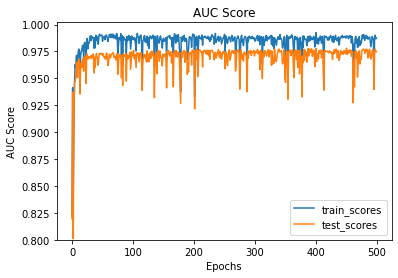

In [61]:
print("weight_decay: ", params_deepl['weight_decay'], "epochs: ", params_deepl['epochs'])
plot_train_stats(params_deepl)

weight_decay:  0.02 epochs:  200


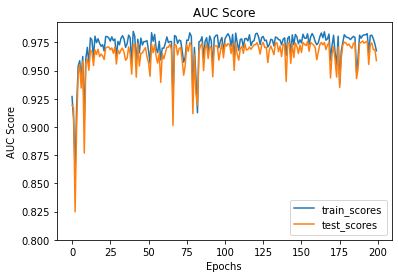

In [58]:
print("weight_decay: ", params_deepl['weight_decay'], "epochs: ", params_deepl['epochs'])
plot_train_stats(params_deepl)

weight_decay:  0.01 epochs:  200


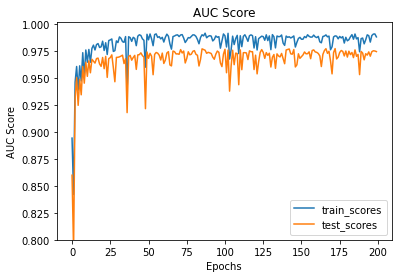

In [55]:
print("weight_decay: ", params_deepl['weight_decay'], "epochs: ", params_deepl['epochs'])
plot_train_stats(params_deepl)

weight_decay:  0.008 epochs:  200


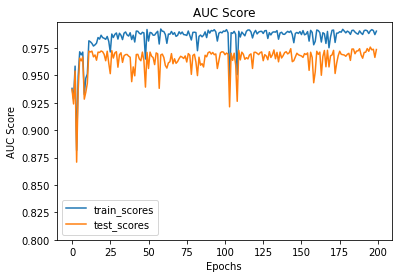

In [52]:
print("weight_decay: ", params_deepl['weight_decay'], "epochs: ", params_deepl['epochs'])
plot_train_stats(params_deepl)

weight_decay:  0.0001 epochs:  200


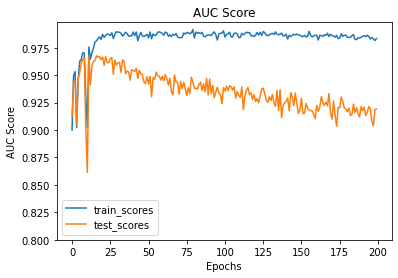

In [49]:
print("weight_decay: ", params_deepl['weight_decay'], "epochs: ", params_deepl['epochs'])
plot_train_stats(params_deepl)

weight_decay:  0.005 epochs:  200


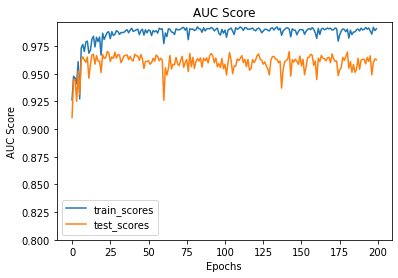

In [46]:
print("weight_decay: ", params_deepl['weight_decay'], "epochs: ", params_deepl['epochs'])
plot_train_stats(params_deepl)

In [62]:
from sklearn.metrics import roc_auc_score

In [63]:
from xgboost import XGBClassifier

In [64]:
import json

Na tłumaczeniu deepl:

In [65]:
preds = train.predict(X_test, y_test, params_deepl)
roc_auc_score(y_test, preds)

0.9747090944331936

In [66]:
preds = train.predict(X_test, y_test, params_google)
roc_auc_score(y_test, preds)

0.980463711159679

In [67]:
xgb = XGBClassifier(booster = 'gblinear')
xgb.fit(X_train, y_train.ravel())

XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [68]:
pred = xgb.predict_proba(X_test)

In [69]:
roc_auc_score(y_test, pred[:,1])

0.9483020204653152

In [70]:
important_vars = xgb.feature_importances_!=0

In [71]:
f_names = load_feature_names(Path(params_deepl['model_dir'], "one_hot_feature_names.json"))

In [72]:
nn = f_names[0] + f_names[1]+['trans_'+str(i) for i in range(768)]

In [73]:
i=0
dd = dict()
for _ in important_vars:
  if _:
    dd[nn[i]]=xgb.feature_importances_[i]
  i+=1

In [74]:
x = pd.DataFrame(index = dd.keys(), data = abs(xgb.feature_importances_[xgb.feature_importances_!=0]), columns=['imp'])
xx = x.sort_values('imp',ascending=False).head(30)
xx

,imp
x0_OH,0.059196
x0_AK,0.056775
x0_DC,0.047273
x0_VA,0.044461
x0_OR,0.042295
x0_CO,0.040638
x0_NM,0.040482
trans_498,0.037772
trans_227,0.037458
x0_PA,0.037322


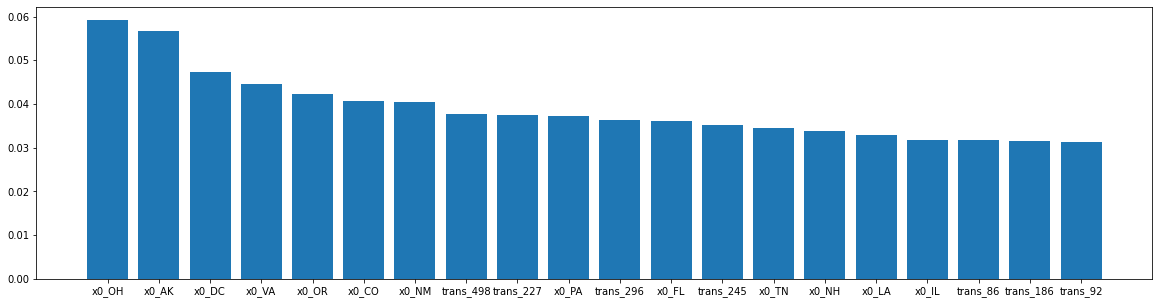

In [75]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.bar(xx.index[:20], xx.imp[:20])
plt.show()

Na tłumaczeniu google:

In [77]:
preds = train.predict(X_test, y_test, params_deepl)
roc_auc_score(y_test, preds)

0.9865458263990536

In [78]:
preds = train.predict(X_test, y_test, params_google)
roc_auc_score(y_test, preds)

0.9793274918292463

In [79]:
xgb = XGBClassifier(booster = 'gblinear')
xgb.fit(X_train, y_train.ravel())

XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [80]:
pred = xgb.predict_proba(X_test)

In [81]:
roc_auc_score(y_test, pred[:,1])

0.9673971888597037

In [82]:
important_vars = xgb.feature_importances_!=0

In [83]:
import json

In [84]:
f_names = load_feature_names(Path(params_google['model_dir'], "one_hot_feature_names.json"))

In [85]:
nn = f_names[0] + f_names[1]+['trans_'+str(i) for i in range(768)]

In [86]:
i=0
dd = dict()
for _ in important_vars:
  if _:
    dd[nn[i]]=xgb.feature_importances_[i]
  i+=1

In [87]:
x = pd.DataFrame(index = dd.keys(), data = abs(xgb.feature_importances_[xgb.feature_importances_!=0]), columns=['imp'])
xx = x.sort_values('imp',ascending=False).head(30)
xx

,imp
x0_AK,0.046527
x0_DC,0.041939
x0_OH,0.041615
x0_VA,0.038709
x0_PA,0.032714
x0_AR,0.032168
trans_668,0.031453
x0_LA,0.031423
trans_498,0.030652
x0_MA,0.029870


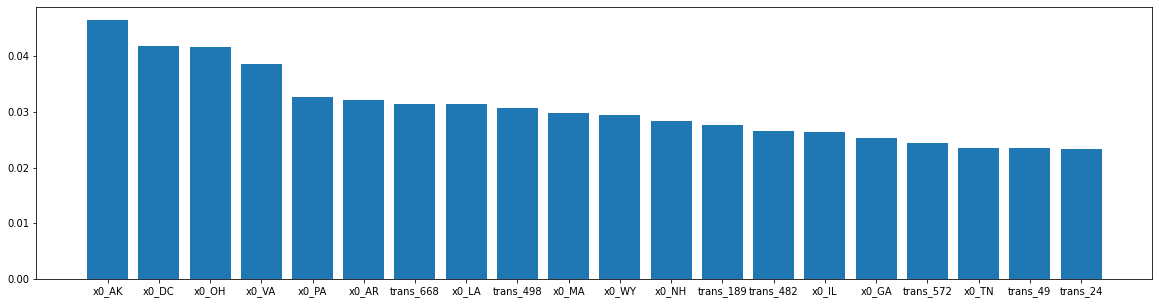

In [88]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.bar(xx.index[:20], xx.imp[:20])
plt.show()